In [15]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

import wandb
from sklearn.preprocessing import OneHotEncoder

In [17]:
data_df = pd.read_csv('advertisement.csv')

In [18]:
categorical_columns = ["education", "city", "occupation", "most bought item"]
data_df_preprocess = pd.get_dummies(data_df, columns=categorical_columns)

In [19]:
data_df_preprocess["gender"] = data_df["gender"].apply(lambda x: 1 if x == "Male" else 0)
data_df_preprocess["married"] = data_df["married"].astype(int)

In [20]:
x = data_df_preprocess.drop(columns=["labels"]).values
y = mlb.fit_transform(data_df_preprocess["labels"].str.split())

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [21]:
scaler = StandardScaler()
normalizer = MinMaxScaler()

In [22]:
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

X_train_normalized = normalizer.fit_transform(X_train_standardized)
X_val_normalized = normalizer.transform(X_val_standardized)
X_test_normalized = normalizer.transform(X_test_standardized)

In [23]:
from sklearn.metrics import hamming_loss


In [32]:
class MLPMultiLabel:
    def __init__(self, input_dim, hidden_layers, output_dim, learning_rate=0.01, activation="relu", log_flag=0):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.activation = activation
        self.weights = []
        self.biases = []
        self.log_flag = log_flag
        self.__initialize_weights_and_biases()

    def __initialize_weights_and_biases(self):
        layers = [self.input_dim] + self.hidden_layers + [self.output_dim]
        for i in range(len(layers) - 1):
            # Use Xavier initialization for weights
            weight_scale = np.sqrt(2 / (layers[i] + layers[i + 1]))
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * weight_scale)
            # Initialize biases to zeros
            self.biases.append(np.zeros(layers[i + 1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x <= 0, 0, 1)

    def calculate_accuracy(self, y_true, y_pred):
        # Convert probabilities to binary outputs
        y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    
        # Calculate Hamming error using sklearn's function
        hamming_error = hamming_loss(y_true, y_pred_binary)
    
        # Calculate accuracy as 1 - Hamming error
        accuracy = 1 - hamming_error
    
        return accuracy

    def forward_propagation(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            if self.activation == "relu":
                a = self.relu(z)
            elif self.activation == "sigmoid":
                a = self.sigmoid(z)
            elif self.activation == "tanh":
                a = self.tanh(z)
            self.z.append(z)
            self.a.append(a)
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        a = self.sigmoid(z)  # Use sigmoid for multi-label classification
        self.z.append(z)
        self.a.append(a)
        return a

    def back_propagation(self, X, y):
        m = X.shape[0]
        dz = [self.a[-1] - y]
        for i in range(len(self.hidden_layers), -1, -1):
            dw = 1/m * np.dot(self.a[i].T, dz[-1])
            db = 1/m * np.sum(dz[-1], axis=0)
            if i != 0:
                derivative = None
                if self.activation == "relu":
                    derivative = self.relu_derivative(self.a[i])
                elif self.activation == "sigmoid":
                    derivative = self.sigmoid_derivative(self.a[i])
                elif self.activation == "tanh":
                    derivative = self.tanh_derivative(self.a[i])
                dz.append(np.dot(dz[-1], self.weights[i].T) * derivative)
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db

    def binary_cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-10
        num_samples = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / num_samples
        return loss
    
    def train_mini_batch(self, X, y, X_val, y_val, epochs=1000, batch_size=32):
        train_losses = []
        val_losses = []
        accuracies = []
        val_accuracies = []
        indices = np.arange(X.shape[0])
        for epoch in range(epochs):
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                self.forward_propagation(X_batch)
                self.back_propagation(X_batch, y_batch)
            y_pred = self.forward_propagation(X)
            loss = self.binary_cross_entropy_loss(y, y_pred)
            train_accuracy = self.calculate_accuracy(y, y_pred)

            # Validation loss and accuracy
            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.binary_cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)

            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')

            if self.log_flag == 1:
                wandb.log({
                    "train_loss": loss,
                    "accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })

            train_losses.append(loss)
            val_losses.append(val_loss)
            accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        self.plot(train_losses, val_losses, accuracies, val_accuracies)
        
    def train_batch(self, X, y, X_val, y_val, epochs=1000):
        losses = []
        val_losses = []
        accuracies = []
        val_accuracies = []
        for epoch in range(epochs):
            y_pred = self.forward_propagation(X)
            loss = self.binary_cross_entropy_loss(y, y_pred)
            train_accuracy = self.calculate_accuracy(y, y_pred)
            
            self.back_propagation(X, y)

            # Validation loss and accuracy
            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.binary_cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)

            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')

            if self.log_flag == 1:
                wandb.log({
                    "train_loss": loss,
                    "accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })

            losses.append(loss)
            val_losses.append(val_loss)
            accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        self.plot(losses, val_losses, accuracies, val_accuracies)

    def train_sgd(self, X, y, X_val, y_val, epochs=1000):
        losses = []
        val_losses = []
        accuracies = []
        val_accuracies = []
        indices = np.arange(X.shape[0])
        for epoch in range(epochs):
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(X.shape[0]):
                X_i = np.expand_dims(X[i], axis=0)
                y_i = np.expand_dims(y[i], axis=0)
                self.forward_propagation(X_i)
                self.back_propagation(X_i, y_i)

            y_pred = self.forward_propagation(X)
            loss = self.binary_cross_entropy_loss(y, y_pred)
            train_accuracy = self.calculate_accuracy(y, y_pred)

            # Validation loss and accuracy
            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.binary_cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)

            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')

            if self.log_flag == 1:
                wandb.log({
                    "train_loss": loss,
                    "accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })

            losses.append(loss)
            val_losses.append(val_loss)
            accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        self.plot(losses, val_losses, accuracies, val_accuracies)
    
    def plot(self, losses, val_losses, accuracies, val_accuracies):
        plt.figure(figsize=(10, 4))
    
        plt.subplot(1, 2, 1)
        plt.plot(losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title('Loss over time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Val Accuracy')
        plt.title('Accuracy over time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return y_pred

Epoch 0:
Train Loss 5.54897799314437
Train Acc 0.5016666666666667
Val Loss 5.548261682705954
Val Acc 0.50234375

Epoch 50:
Train Loss 5.407664310473414
Train Acc 0.6479166666666667
Val Loss 5.402582514395733
Val Acc 0.65359375

Epoch 100:
Train Loss 5.318224964986006
Train Acc 0.64625
Val Loss 5.309903791749424
Val Acc 0.65234375

Epoch 150:
Train Loss 5.257486000512004
Train Acc 0.6458333333333333
Val Loss 5.246826100302112
Val Acc 0.651875

Epoch 200:
Train Loss 5.2130162396559125
Train Acc 0.6458333333333333
Val Loss 5.2009131332691325
Val Acc 0.651875

Epoch 250:
Train Loss 5.178672772971402
Train Acc 0.6460416666666666
Val Loss 5.166037821152076
Val Acc 0.6520312500000001

Epoch 300:
Train Loss 5.150394516919522
Train Acc 0.6466666666666667
Val Loss 5.137976942363293
Val Acc 0.6525000000000001

Epoch 350:
Train Loss 5.126470428315397
Train Acc 0.6475
Val Loss 5.114644563299269
Val Acc 0.653125

Epoch 400:
Train Loss 5.105473305414112
Train Acc 0.6483333333333333
Val Loss 5.0944062

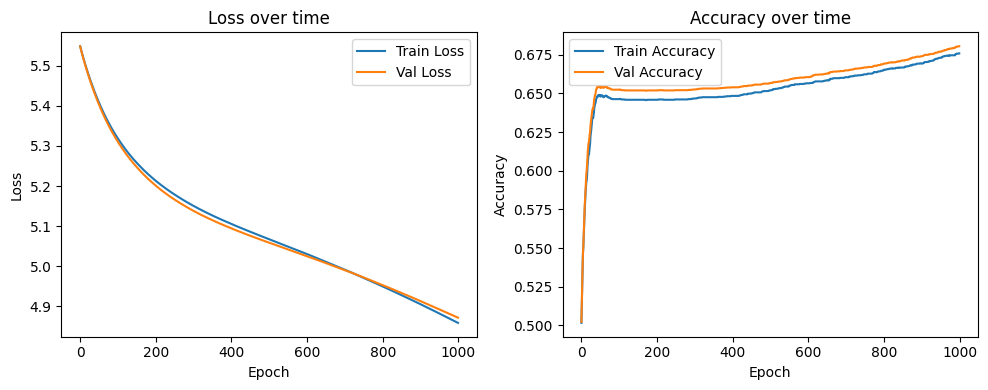

In [33]:
mlp = MLPMultiLabel(input_dim=1014, hidden_layers=[5], output_dim=8, learning_rate=0.001, activation="relu", log_flag=0)
mlp.train_mini_batch(X_train_normalized, y_train, X_val_normalized, y_val, epochs=1000)





In [35]:
learning_rates = [0.001, 0.01, 0.025]
num_epochs = [100, 500, 1000]
activations_multi = ['sigmoid', 'tanh', 'relu']
hidden_layers_multi = [[5], [10], [10, 10]]

optimizers_multi = {
    'train_sgd': MLPMultiLabel.train_sgd,
    'train_gd': MLPMultiLabel.train_batch,
    'train_mini_batch': MLPMultiLabel.train_mini_batch
}

In [38]:
best_hyperparameters_multi

{'learning_rate': 0.001,
 'num_epochs': 1500,
 'activation': 'relu',
 'hidden_layers': [10],
 'optimizer': 'train_mini_batch'}

In [36]:
best_model_multi = None
best_accuracy_multi = 0.0
best_hyperparameters_multi = {}

Epoch 0:
Train Loss 5.376022470740663
Train Acc 0.6039583333333334
Val Loss 5.351885055329432
Val Acc 0.61109375

Epoch 50:
Train Loss 5.1457878473464795
Train Acc 0.6452083333333334
Val Loss 5.126087915582913
Val Acc 0.65140625



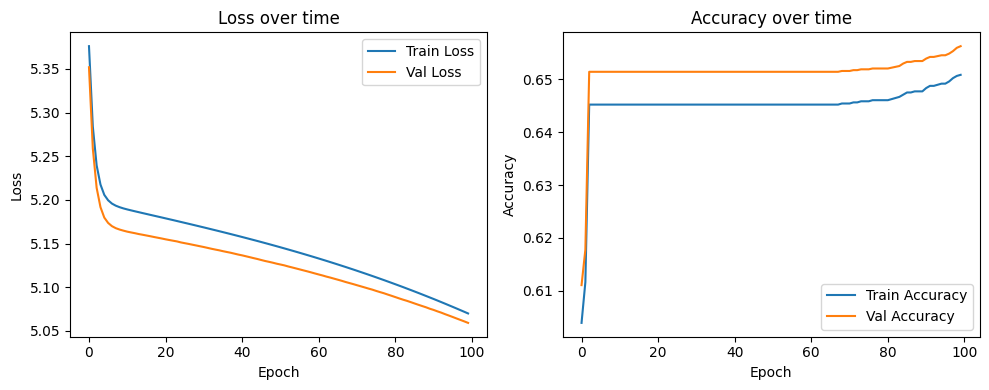

Epoch 0:
Train Loss 5.494734459348562
Train Acc 0.5702083333333333
Val Loss 5.484288770817404
Val Acc 0.57421875

Epoch 50:
Train Loss 5.479028159631467
Train Acc 0.57875
Val Loss 5.46814530438451
Val Acc 0.58203125



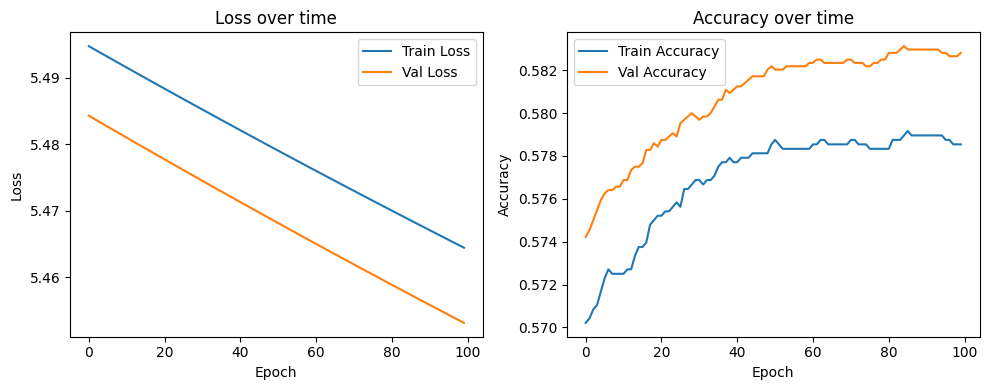

Epoch 0:
Train Loss 5.552899736715763
Train Acc 0.5804166666666667
Val Loss 5.553334986035154
Val Acc 0.5818749999999999

Epoch 50:
Train Loss 5.316806706122389
Train Acc 0.6135416666666667
Val Loss 5.306054158652668
Val Acc 0.61640625



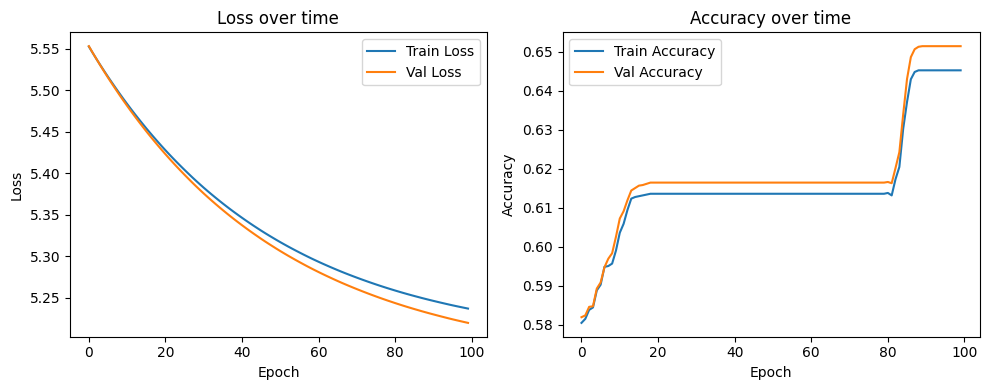

Epoch 0:
Train Loss 5.444223767433882
Train Acc 0.580625
Val Loss 5.446309825568062
Val Acc 0.5823437499999999

Epoch 50:
Train Loss 5.130793180769558
Train Acc 0.6452083333333334
Val Loss 5.111581068453019
Val Acc 0.65140625



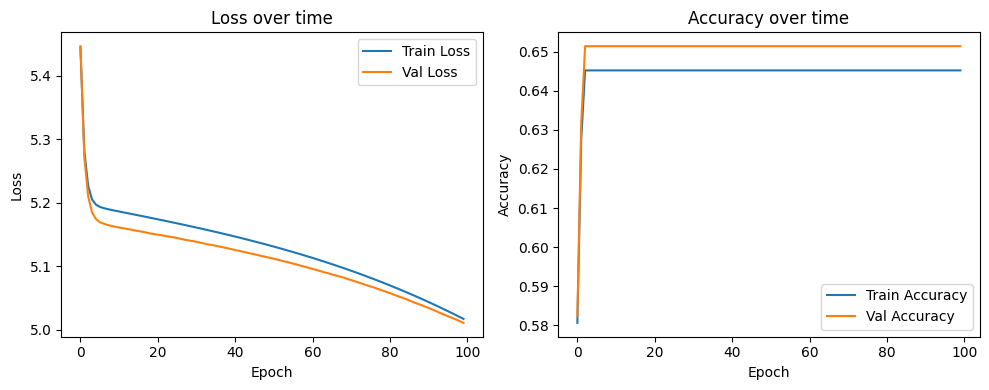

Epoch 0:
Train Loss 5.476357743869729
Train Acc 0.56125
Val Loss 5.4595307725511795
Val Acc 0.56703125

Epoch 50:
Train Loss 5.451566737598909
Train Acc 0.5695833333333333
Val Loss 5.434274467897427
Val Acc 0.5743750000000001



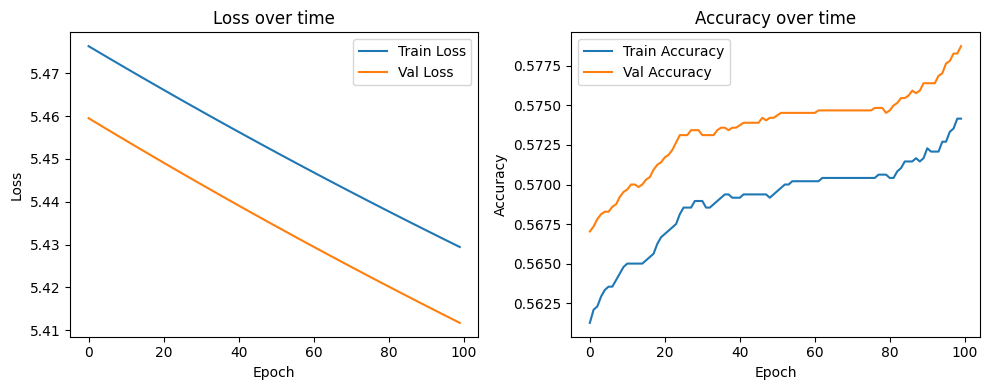

Epoch 0:
Train Loss 5.853407346503525
Train Acc 0.46229166666666666
Val Loss 5.856061252990956
Val Acc 0.45765625

Epoch 50:
Train Loss 5.324322414008157
Train Acc 0.6445833333333333
Val Loss 5.311100072055792
Val Acc 0.650625



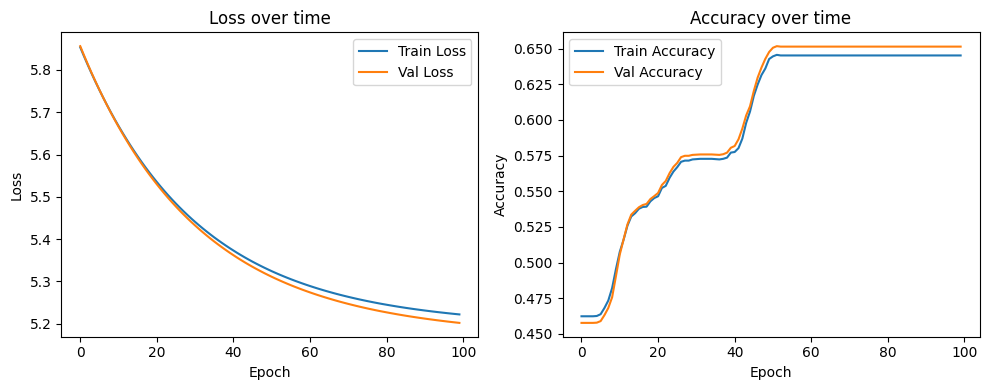

Epoch 0:
Train Loss 5.3502497880287265
Train Acc 0.6054166666666667
Val Loss 5.337413936990171
Val Acc 0.6125

Epoch 50:
Train Loss 5.19655282564002
Train Acc 0.6452083333333334
Val Loss 5.169535447141678
Val Acc 0.65140625



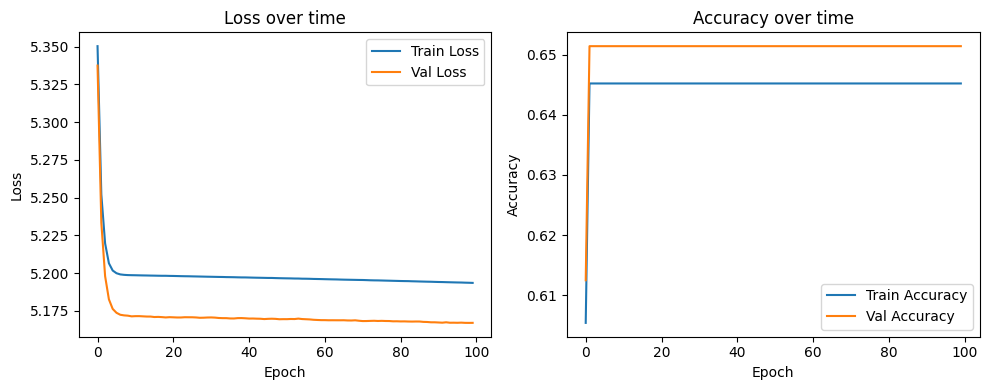

Epoch 0:
Train Loss 6.27670654242141
Train Acc 0.4247916666666667
Val Loss 6.266050019116816
Val Acc 0.42578125

Epoch 50:
Train Loss 6.181770019133075
Train Acc 0.46020833333333333
Val Loss 6.170540231026869
Val Acc 0.46078125000000003



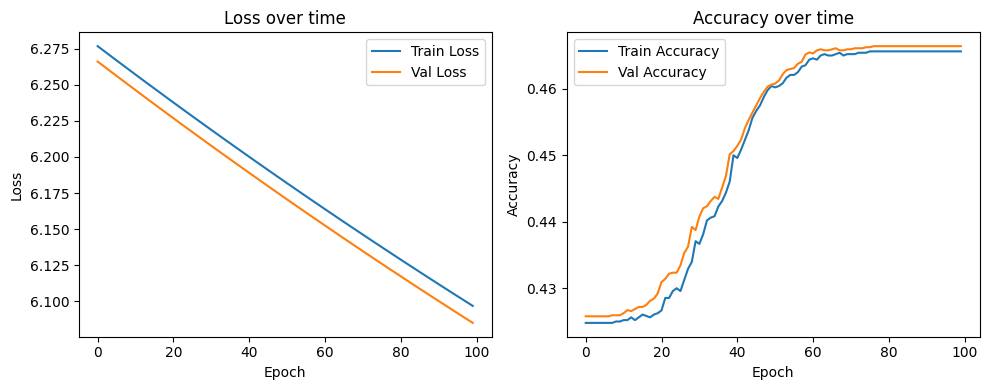

Epoch 0:
Train Loss 5.689068529604944
Train Acc 0.5052083333333333
Val Loss 5.698906471707757
Val Acc 0.50484375

Epoch 50:
Train Loss 5.283469703241677
Train Acc 0.6452083333333334
Val Loss 5.271461681407701
Val Acc 0.65140625



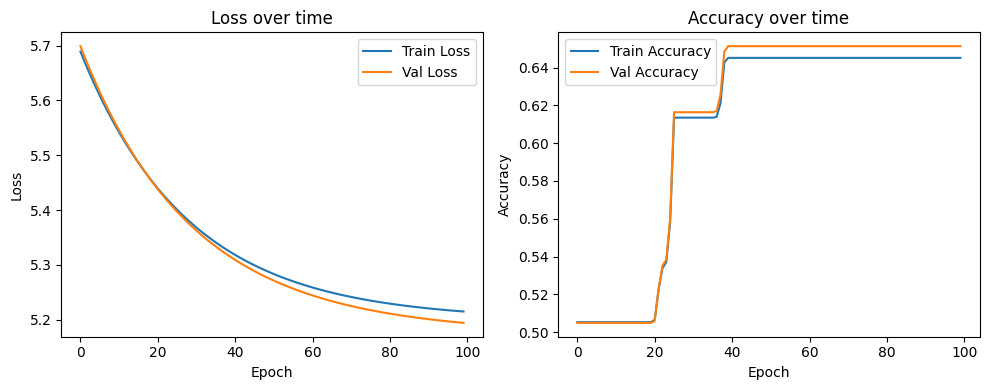

Epoch 0:
Train Loss 5.31400465940349
Train Acc 0.6275
Val Loss 5.300547203075713
Val Acc 0.63390625

Epoch 50:
Train Loss 4.5753645523685265
Train Acc 0.7177083333333334
Val Loss 4.613947242989851
Val Acc 0.7167187500000001



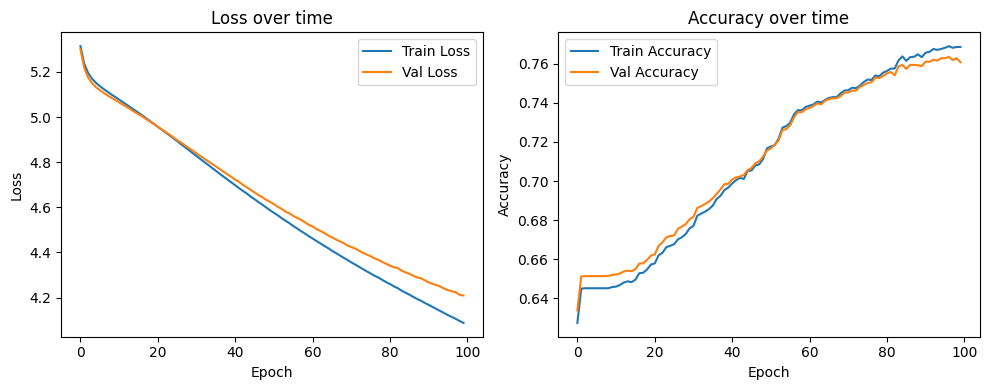

Epoch 0:
Train Loss 5.545456429901715
Train Acc 0.51
Val Loss 5.5461606718466125
Val Acc 0.5075000000000001

Epoch 50:
Train Loss 5.513858045365237
Train Acc 0.5522916666666666
Val Loss 5.5138004772973295
Val Acc 0.55125



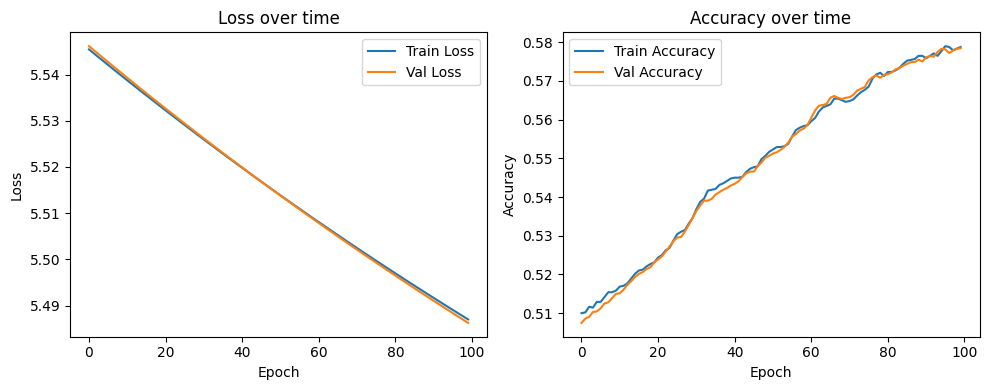

Epoch 0:
Train Loss 5.550808180311122
Train Acc 0.4977083333333333
Val Loss 5.555332527000644
Val Acc 0.49265625

Epoch 50:
Train Loss 5.25630667157088
Train Acc 0.6452083333333334
Val Loss 5.2423653369891925
Val Acc 0.65140625



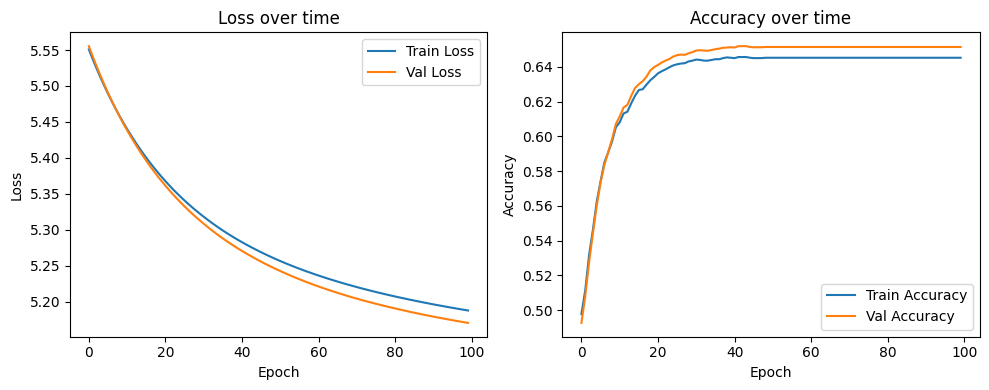

Epoch 0:
Train Loss 5.292081150010335
Train Acc 0.6443749999999999
Val Loss 5.280333189789567
Val Acc 0.65078125

Epoch 50:
Train Loss 4.235229234899322
Train Acc 0.7604166666666666
Val Loss 4.322768009200673
Val Acc 0.7575000000000001



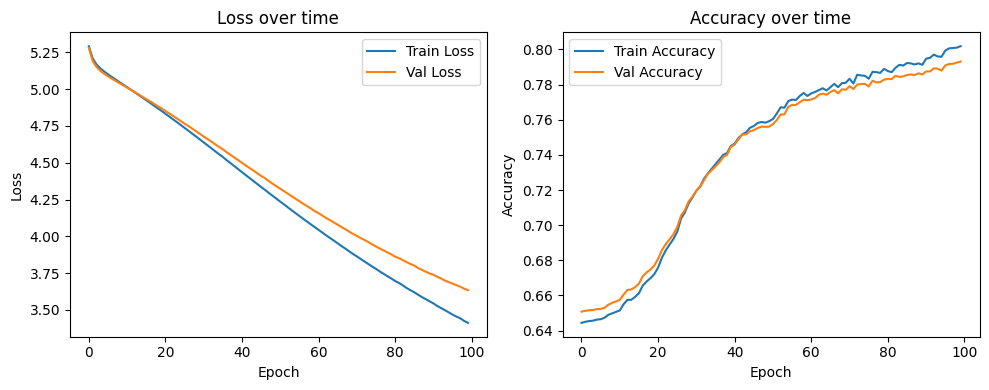

Epoch 0:
Train Loss 5.547454834856544
Train Acc 0.5154166666666666
Val Loss 5.541432788401428
Val Acc 0.52125

Epoch 50:
Train Loss 5.49555573136259
Train Acc 0.5577083333333333
Val Loss 5.487064081202038
Val Acc 0.56203125



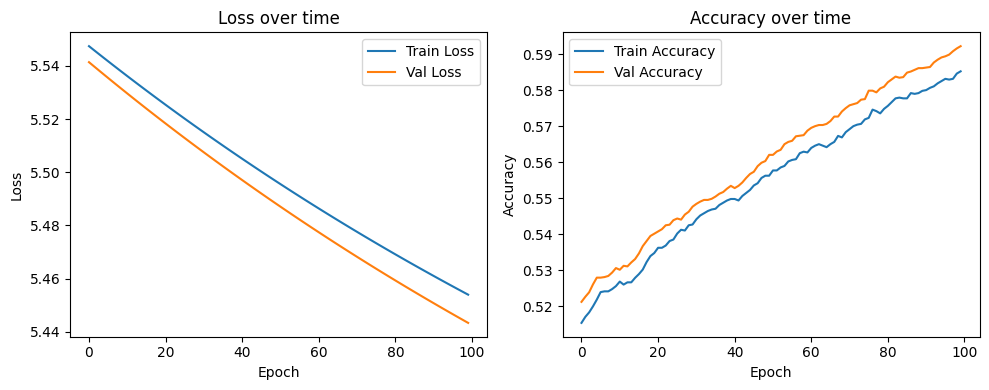

Epoch 0:
Train Loss 5.556751096432299
Train Acc 0.4916666666666667
Val Loss 5.556045379372485
Val Acc 0.495

Epoch 50:
Train Loss 5.23069923393735
Train Acc 0.645
Val Loss 5.212368464769704
Val Acc 0.65125



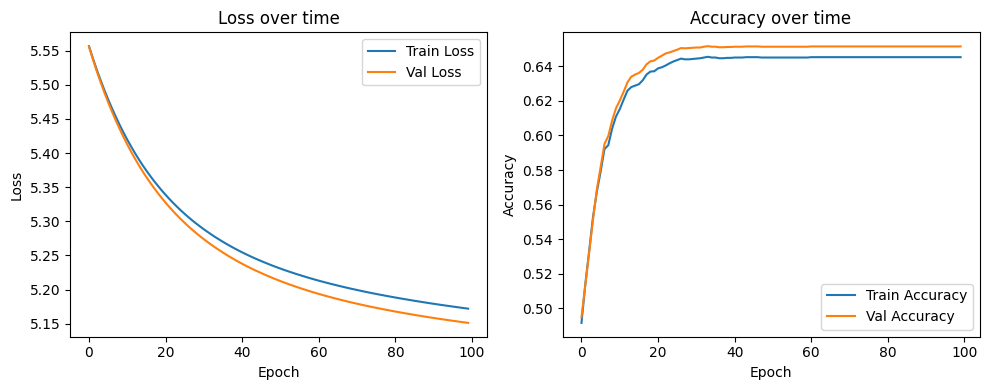

Epoch 0:
Train Loss 5.357272552516194
Train Acc 0.611875
Val Loss 5.352319787803249
Val Acc 0.6146875

Epoch 50:
Train Loss 3.9735002707001406
Train Acc 0.79
Val Loss 4.131046698596276
Val Acc 0.7776562499999999



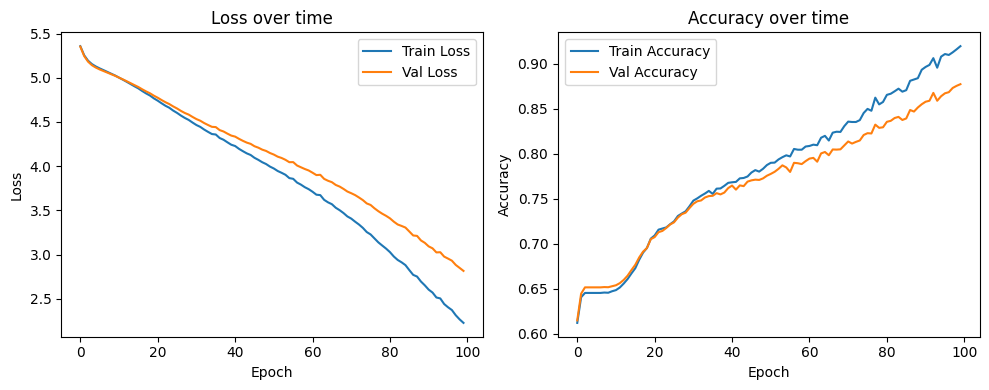

Epoch 0:
Train Loss 5.5987550982498036
Train Acc 0.4641666666666666
Val Loss 5.598202547110425
Val Acc 0.46640625

Epoch 50:
Train Loss 5.544349050792622
Train Acc 0.5185416666666667
Val Loss 5.5433016866629945
Val Acc 0.5196875000000001



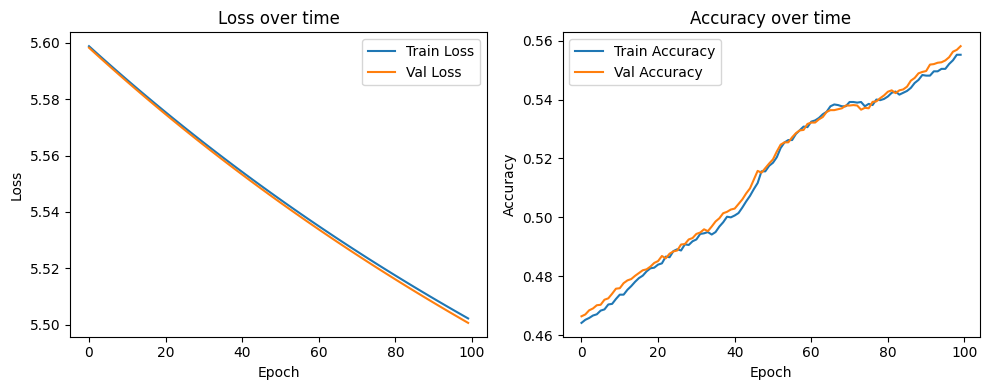

Epoch 0:
Train Loss 5.549362284033652
Train Acc 0.5033333333333334
Val Loss 5.547311577248532
Val Acc 0.506875

Epoch 50:
Train Loss 5.250860432384505
Train Acc 0.6245833333333333
Val Loss 5.238999009496803
Val Acc 0.63109375



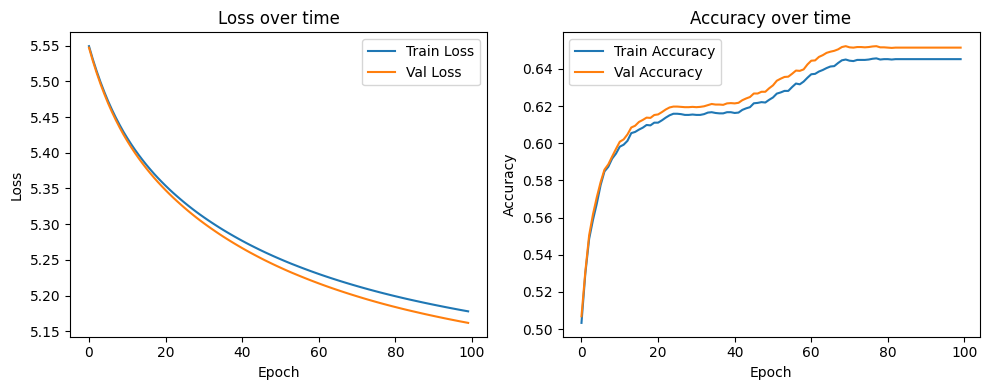

Epoch 0:
Train Loss 5.453380539552986
Train Acc 0.64125
Val Loss 5.449051456052527
Val Acc 0.64703125

Epoch 50:
Train Loss 4.7106659538744085
Train Acc 0.6891666666666667
Val Loss 4.731902488434663
Val Acc 0.69359375



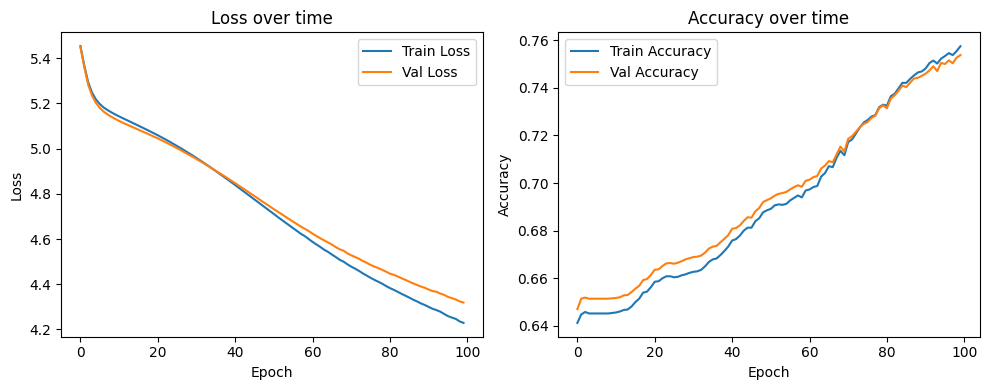

Epoch 0:
Train Loss 5.5510900836426815
Train Acc 0.4972916666666667
Val Loss 5.55052689669606
Val Acc 0.5003124999999999

Epoch 50:
Train Loss 5.537429351202
Train Acc 0.524375
Val Loss 5.536178974962143
Val Acc 0.5253125000000001



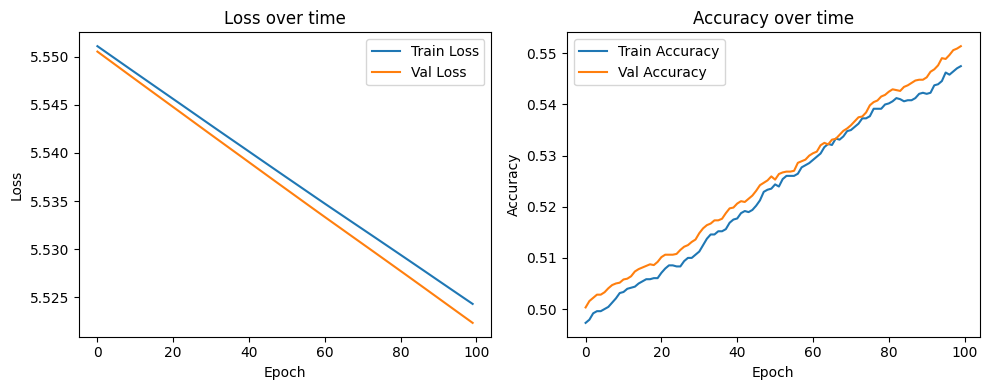

Epoch 0:
Train Loss 5.580434278612512
Train Acc 0.4654166666666667
Val Loss 5.587537932435021
Val Acc 0.45953124999999995

Epoch 50:
Train Loss 5.396400628765735
Train Acc 0.6479166666666667
Val Loss 5.391433622663685
Val Acc 0.6528125



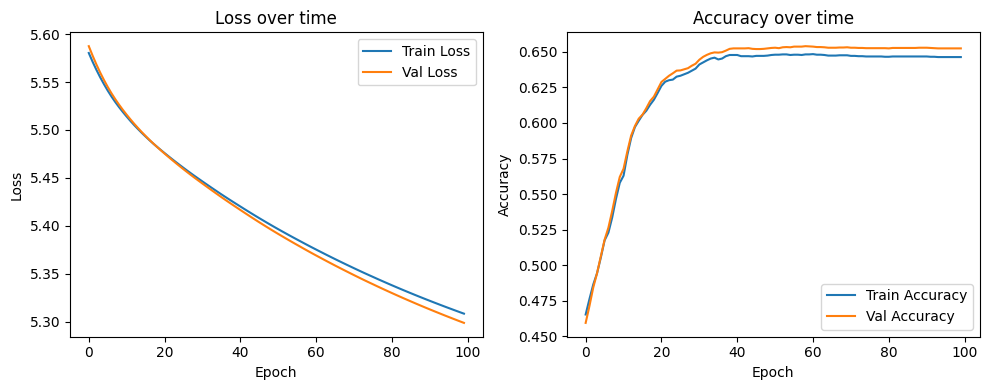

Epoch 0:
Train Loss 5.435461215711625
Train Acc 0.638125
Val Loss 5.428761214224838
Val Acc 0.64171875

Epoch 50:
Train Loss 4.509348269803143
Train Acc 0.7339583333333333
Val Loss 4.562888461768814
Val Acc 0.73546875



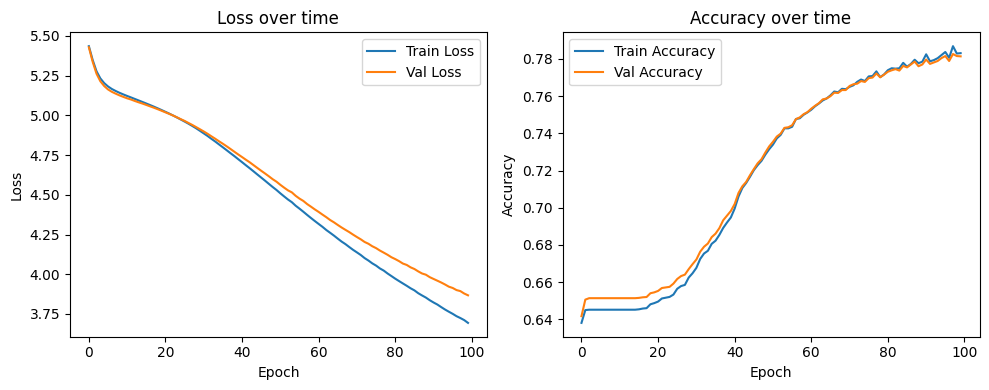

Epoch 0:
Train Loss 5.561901610239473
Train Acc 0.49354166666666666
Val Loss 5.561577762771308
Val Acc 0.49390625

Epoch 50:
Train Loss 5.542728068863316
Train Acc 0.5283333333333333
Val Loss 5.541906012995291
Val Acc 0.5310937499999999



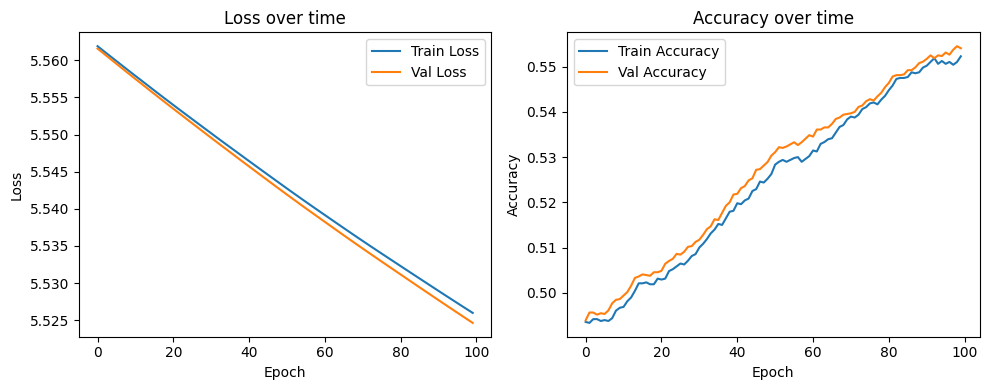

Epoch 0:
Train Loss 5.5483721295401995
Train Acc 0.5095833333333333
Val Loss 5.545425378769421
Val Acc 0.515

Epoch 50:
Train Loss 5.356924449060607
Train Acc 0.645625
Val Loss 5.344685460990474
Val Acc 0.6520312500000001



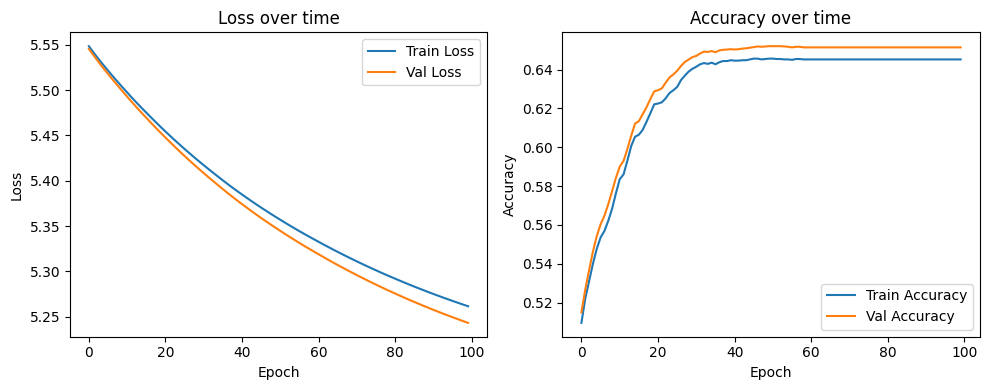

Epoch 0:
Train Loss 5.450625760777283
Train Acc 0.6454166666666667
Val Loss 5.447543134317057
Val Acc 0.650625

Epoch 50:
Train Loss 4.4322103482617194
Train Acc 0.7410416666666666
Val Loss 4.516696021394977
Val Acc 0.73734375



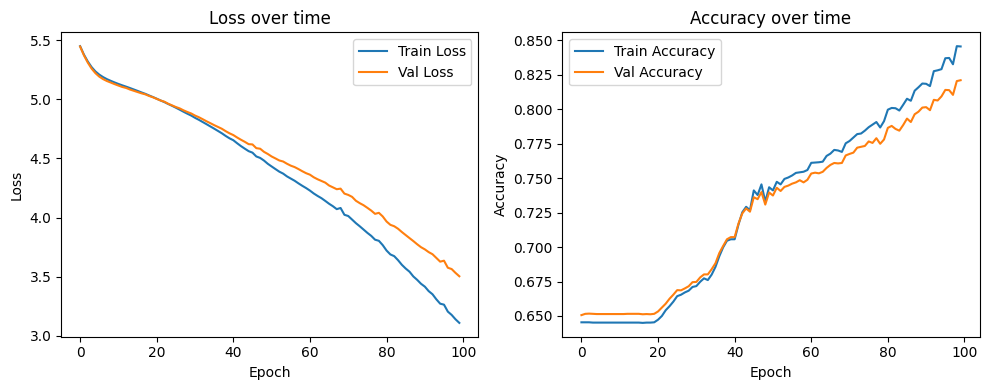

Epoch 0:
Train Loss 5.567730842651958
Train Acc 0.44666666666666666
Val Loss 5.568866495236071
Val Acc 0.44671875000000005

Epoch 50:
Train Loss 5.550784301916243
Train Acc 0.5066666666666666
Val Loss 5.551522347367655
Val Acc 0.5025



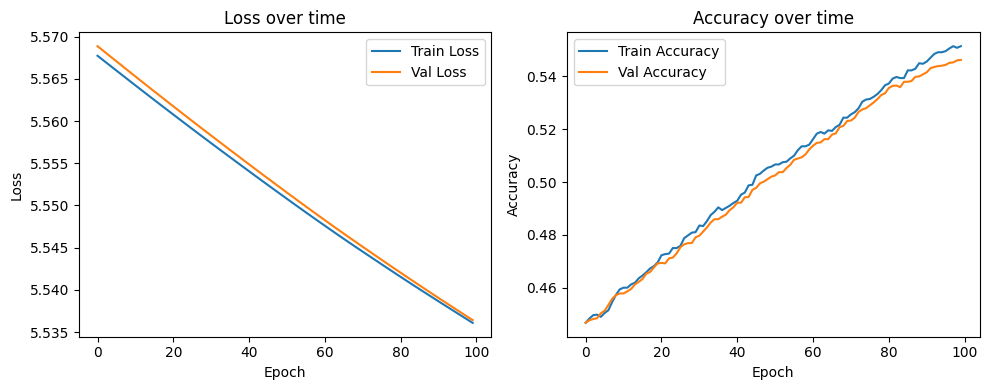

Epoch 0:
Train Loss 5.521669365045028
Train Acc 0.5716666666666667
Val Loss 5.521183396332925
Val Acc 0.5782812500000001

Epoch 50:
Train Loss 5.32560742765471
Train Acc 0.640625
Val Loss 5.314429356318199
Val Acc 0.64375



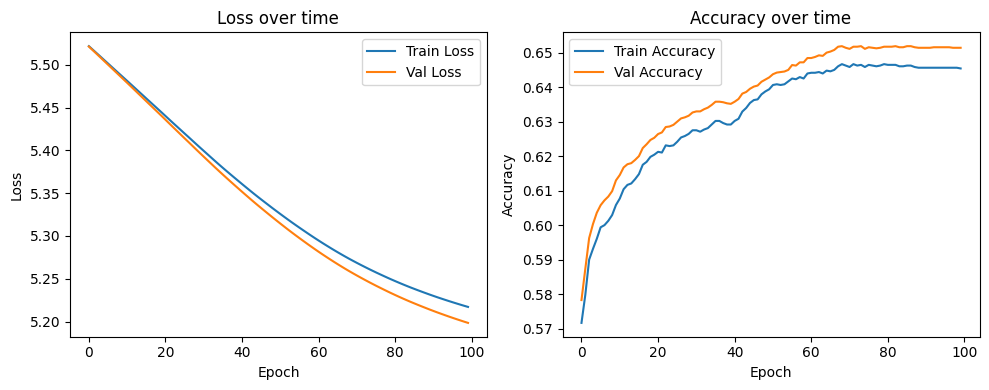

Epoch 0:
Train Loss 5.529517318653139
Train Acc 0.568125
Val Loss 5.537269764304748
Val Acc 0.566875

Epoch 50:
Train Loss 5.1668005391965295
Train Acc 0.6452083333333334
Val Loss 5.141591235308474
Val Acc 0.65140625

Epoch 100:
Train Loss 5.112650886731655
Train Acc 0.6452083333333334
Val Loss 5.092538700622972
Val Acc 0.65140625

Epoch 150:
Train Loss 5.015195063107211
Train Acc 0.646875
Val Loss 5.004849162850742
Val Acc 0.6526562499999999

Epoch 200:
Train Loss 4.866363460577452
Train Acc 0.66625
Val Loss 4.869928972800211
Val Acc 0.66953125

Epoch 250:
Train Loss 4.680230494191885
Train Acc 0.708125
Val Loss 4.700397885682269
Val Acc 0.7103125

Epoch 300:
Train Loss 4.4913356577567844
Train Acc 0.7375
Val Loss 4.529552258385474
Val Acc 0.73875

Epoch 350:
Train Loss 4.327688353788613
Train Acc 0.7535416666666667
Val Loss 4.385545768703731
Val Acc 0.7528125

Epoch 400:
Train Loss 4.1924154565593215
Train Acc 0.7595833333333333
Val Loss 4.271350552929255
Val Acc 0.75703125

Epoch 45

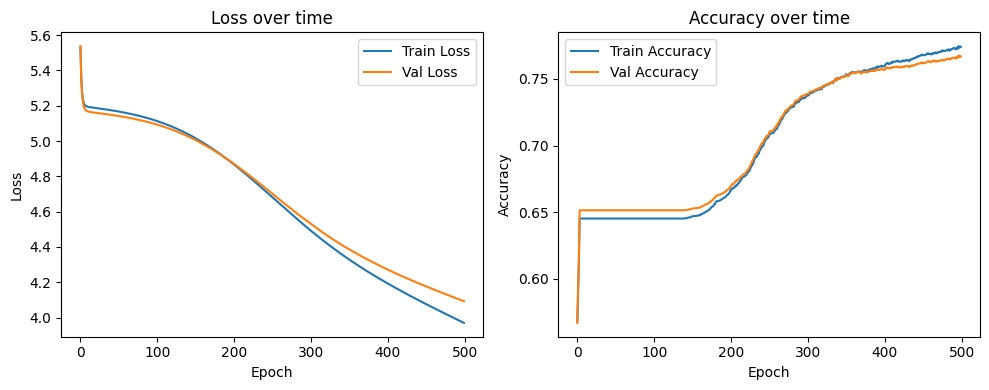

Epoch 0:
Train Loss 5.833626275061732
Train Acc 0.5385416666666667
Val Loss 5.826694780127956
Val Acc 0.54171875

Epoch 50:
Train Loss 5.796145397988864
Train Acc 0.5385416666666667
Val Loss 5.7886926476827965
Val Acc 0.54171875

Epoch 100:
Train Loss 5.761026183028892
Train Acc 0.5385416666666667
Val Loss 5.753068409993684
Val Acc 0.54171875

Epoch 150:
Train Loss 5.728111251200229
Train Acc 0.5385416666666667
Val Loss 5.719664003744474
Val Acc 0.54171875

Epoch 200:
Train Loss 5.697253691119375
Train Acc 0.5385416666666667
Val Loss 5.688331876072546
Val Acc 0.54171875

Epoch 250:
Train Loss 5.66831647315695
Train Acc 0.5385416666666667
Val Loss 5.65893439571274
Val Acc 0.54171875

Epoch 300:
Train Loss 5.641171868473527
Train Acc 0.5385416666666667
Val Loss 5.63134326914252
Val Acc 0.54171875

Epoch 350:
Train Loss 5.615700879779459
Train Acc 0.5385416666666667
Val Loss 5.605438968595101
Val Acc 0.54171875

Epoch 400:
Train Loss 5.5917926889843566
Train Acc 0.5385416666666667
Val Los

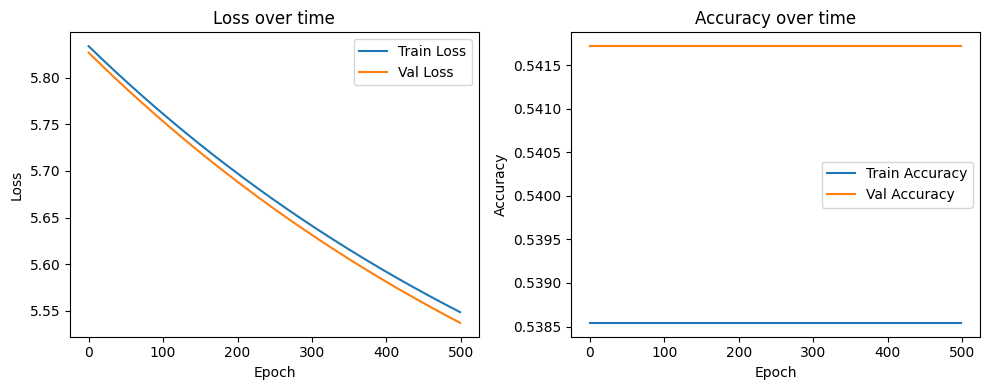

Epoch 0:
Train Loss 5.824405445124757
Train Acc 0.45395833333333335
Val Loss 5.823704113511587
Val Acc 0.45453125000000005

Epoch 50:
Train Loss 5.407802746906681
Train Acc 0.5856250000000001
Val Loss 5.396998443943866
Val Acc 0.58765625

Epoch 100:
Train Loss 5.271389743802238
Train Acc 0.6452083333333334
Val Loss 5.254542894578598
Val Acc 0.65140625

Epoch 150:
Train Loss 5.223161780435592
Train Acc 0.6452083333333334
Val Loss 5.202600820334081
Val Acc 0.65140625

Epoch 200:
Train Loss 5.205204575288224
Train Acc 0.6452083333333334
Val Loss 5.182393299764471
Val Acc 0.65140625

Epoch 250:
Train Loss 5.197953440948598
Train Acc 0.6452083333333334
Val Loss 5.173771263182708
Val Acc 0.65140625

Epoch 300:
Train Loss 5.194621859333746
Train Acc 0.6452083333333334
Val Loss 5.1696418331162795
Val Acc 0.65140625

Epoch 350:
Train Loss 5.19271065173138
Train Acc 0.6452083333333334
Val Loss 5.16728697776492
Val Acc 0.65140625

Epoch 400:
Train Loss 5.191322091207266
Train Acc 0.64520833333333

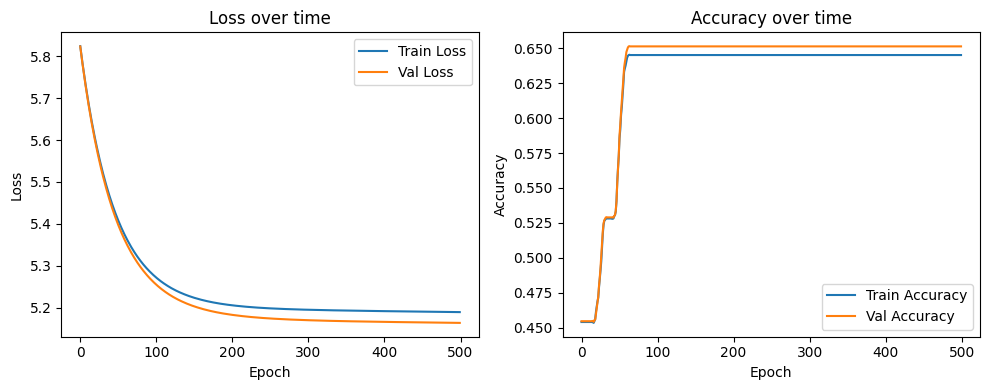

Epoch 0:
Train Loss 5.403239819020805
Train Acc 0.5706249999999999
Val Loss 5.383875585608877
Val Acc 0.57421875

Epoch 50:
Train Loss 5.124053103690536
Train Acc 0.6452083333333334
Val Loss 5.105590168929141
Val Acc 0.65140625

Epoch 100:
Train Loss 5.004841940269151
Train Acc 0.6460416666666666
Val Loss 4.99952442448031
Val Acc 0.6520312500000001

Epoch 150:
Train Loss 4.809726333529719
Train Acc 0.678125
Val Loss 4.8265161597466415
Val Acc 0.68140625

Epoch 200:
Train Loss 4.559697074154653
Train Acc 0.7354166666666666
Val Loss 4.603798107391789
Val Acc 0.736875

Epoch 250:
Train Loss 4.309421748039377
Train Acc 0.7579166666666667
Val Loss 4.382233157073536
Val Acc 0.7584375

Epoch 300:
Train Loss 4.091132223206079
Train Acc 0.771875
Val Loss 4.191624042306059
Val Acc 0.7698437499999999

Epoch 350:
Train Loss 3.899666956727236
Train Acc 0.7785416666666667
Val Loss 4.028658743037821
Val Acc 0.77625

Epoch 400:
Train Loss 3.7202376525530014
Train Acc 0.7870833333333334
Val Loss 3.8769

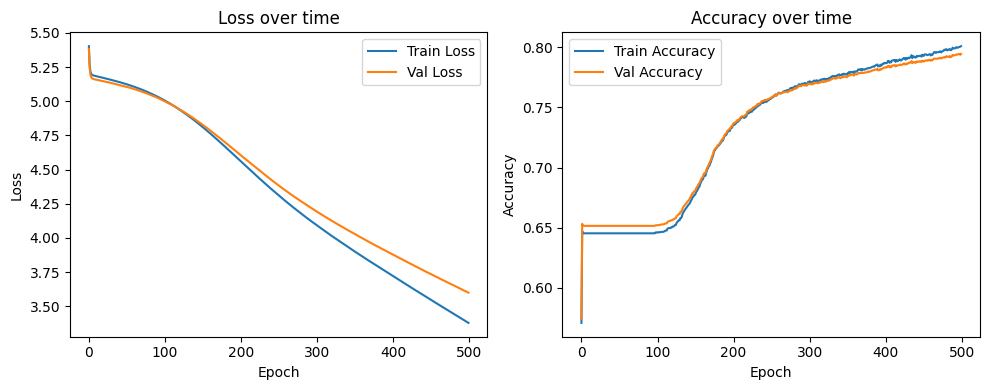

Epoch 0:
Train Loss 5.927895095255761
Train Acc 0.43895833333333334
Val Loss 5.94211023826441
Val Acc 0.4340625

Epoch 50:
Train Loss 5.86434333807378
Train Acc 0.4458333333333333
Val Loss 5.876623227483558
Val Acc 0.44125000000000003

Epoch 100:
Train Loss 5.806449890022661
Train Acc 0.46187500000000004
Val Loss 5.816888363774954
Val Acc 0.45734375000000005

Epoch 150:
Train Loss 5.753703065383132
Train Acc 0.46854166666666663
Val Loss 5.762388656716222
Val Acc 0.46390624999999996

Epoch 200:
Train Loss 5.705637323378922
Train Acc 0.46895833333333337
Val Loss 5.7126536555199285
Val Acc 0.46421875

Epoch 250:
Train Loss 5.661829294985782
Train Acc 0.46895833333333337
Val Loss 5.667255437499685
Val Acc 0.46421875

Epoch 300:
Train Loss 5.621894096905736
Train Acc 0.46895833333333337
Val Loss 5.625804887779825
Val Acc 0.46421875

Epoch 350:
Train Loss 5.585481925493083
Train Acc 0.46958333333333335
Val Loss 5.5879482626863455
Val Acc 0.4653125

Epoch 400:
Train Loss 5.5522749198507135
Tr

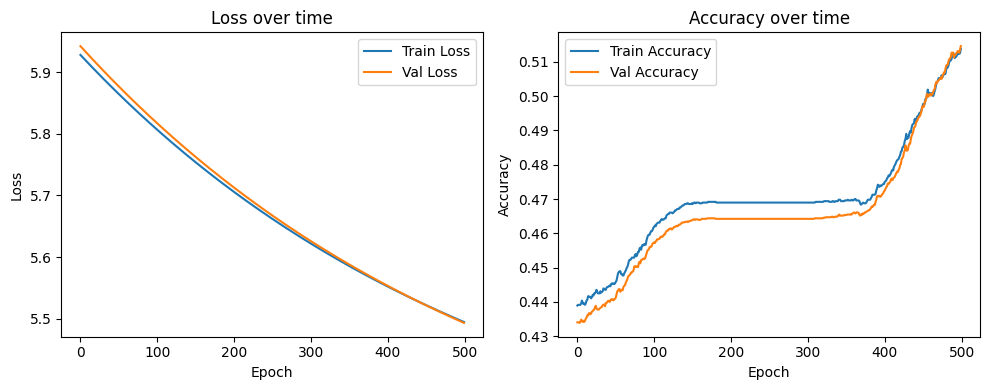

wandb: Network error (ConnectionError), entering retry loop.


Epoch 0:
Train Loss 5.7398679194358415
Train Acc 0.5110416666666666
Val Loss 5.742969118380312
Val Acc 0.5114062500000001



wandb: Network error resolved after 0:01:13.963419, resuming normal operation.


Epoch 50:
Train Loss 5.293491759378957
Train Acc 0.6135416666666667
Val Loss 5.279257087773308
Val Acc 0.61640625

Epoch 100:
Train Loss 5.212867602048994
Train Acc 0.6452083333333334
Val Loss 5.191229166461958
Val Acc 0.65140625

Epoch 150:
Train Loss 5.196499060665619
Train Acc 0.6452083333333334
Val Loss 5.171777237138349
Val Acc 0.65140625

Epoch 200:
Train Loss 5.19177890787925
Train Acc 0.6452083333333334
Val Loss 5.165846279453133
Val Acc 0.65140625

Epoch 250:
Train Loss 5.189261526209284
Train Acc 0.6452083333333334
Val Loss 5.162943835511194
Val Acc 0.65140625

Epoch 300:
Train Loss 5.187144769266365
Train Acc 0.6452083333333334
Val Loss 5.1607822718066645
Val Acc 0.65140625

Epoch 350:
Train Loss 5.185106635259126
Train Acc 0.6452083333333334
Val Loss 5.15886915910249
Val Acc 0.65140625

Epoch 400:
Train Loss 5.18307824787937
Train Acc 0.6452083333333334
Val Loss 5.157027092293149
Val Acc 0.65140625

Epoch 450:
Train Loss 5.181045251961542
Train Acc 0.6452083333333334
Val Lo

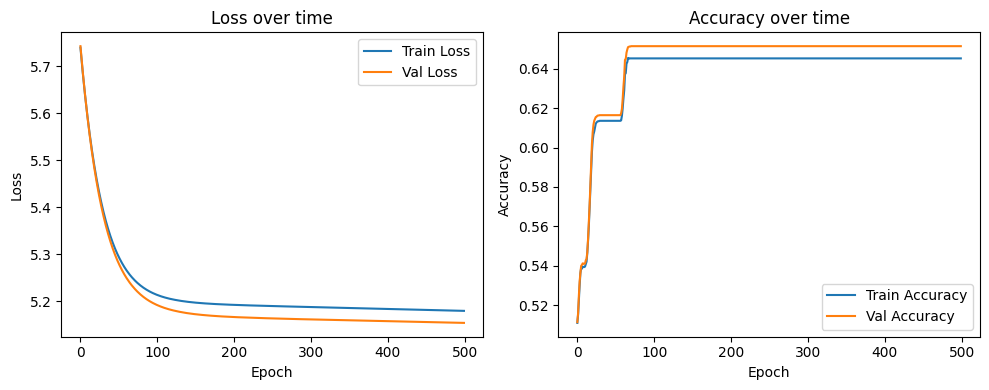

Epoch 0:
Train Loss 5.245190943690116
Train Acc 0.6452083333333334
Val Loss 5.229041488538348
Val Acc 0.65140625

Epoch 50:
Train Loss 5.1955106369622115
Train Acc 0.6452083333333334
Val Loss 5.1688818674268076
Val Acc 0.65140625

Epoch 100:
Train Loss 5.190736883469202
Train Acc 0.6452083333333334
Val Loss 5.164484144478579
Val Acc 0.65140625

Epoch 150:
Train Loss 5.183896004112683
Train Acc 0.6452083333333334
Val Loss 5.158615956712556
Val Acc 0.65140625

Epoch 200:
Train Loss 5.1726731325677076
Train Acc 0.6452083333333334
Val Loss 5.148530935764143
Val Acc 0.65140625

Epoch 250:
Train Loss 5.152473766309403
Train Acc 0.6452083333333334
Val Loss 5.130481606163621
Val Acc 0.65140625

Epoch 300:
Train Loss 5.113439146226727
Train Acc 0.6452083333333334
Val Loss 5.095933017533906
Val Acc 0.65140625

Epoch 350:
Train Loss 5.037872598276699
Train Acc 0.645625
Val Loss 5.029139927380582
Val Acc 0.651875

Epoch 400:
Train Loss 4.914239154983128
Train Acc 0.6775
Val Loss 4.919734146806324


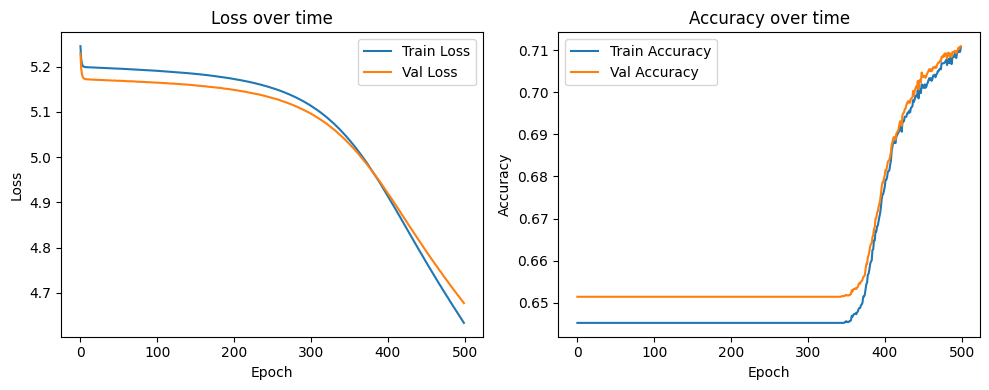

Epoch 0:
Train Loss 5.867249152730445
Train Acc 0.4564583333333333
Val Loss 5.863070115029376
Val Acc 0.46078125000000003

Epoch 50:
Train Loss 5.81098273118238
Train Acc 0.4564583333333333
Val Loss 5.805856054784649
Val Acc 0.46078125000000003

Epoch 100:
Train Loss 5.759623091627379
Train Acc 0.4564583333333333
Val Loss 5.7535878981450574
Val Acc 0.46078125000000003

Epoch 150:
Train Loss 5.712721372940358
Train Acc 0.4564583333333333
Val Loss 5.705814924252115
Val Acc 0.46078125000000003

Epoch 200:
Train Loss 5.6698721912912635
Train Acc 0.4966666666666667
Val Loss 5.662130024409687
Val Acc 0.5015625

Epoch 250:
Train Loss 5.630709208738347
Train Acc 0.49687499999999996
Val Loss 5.622165254942058
Val Acc 0.50171875

Epoch 300:
Train Loss 5.594901156182056
Train Acc 0.49687499999999996
Val Loss 5.585587846679953
Val Acc 0.50171875

Epoch 350:
Train Loss 5.562148270339549
Train Acc 0.49687499999999996
Val Loss 5.552096630386679
Val Acc 0.50171875

Epoch 400:
Train Loss 5.532179105410

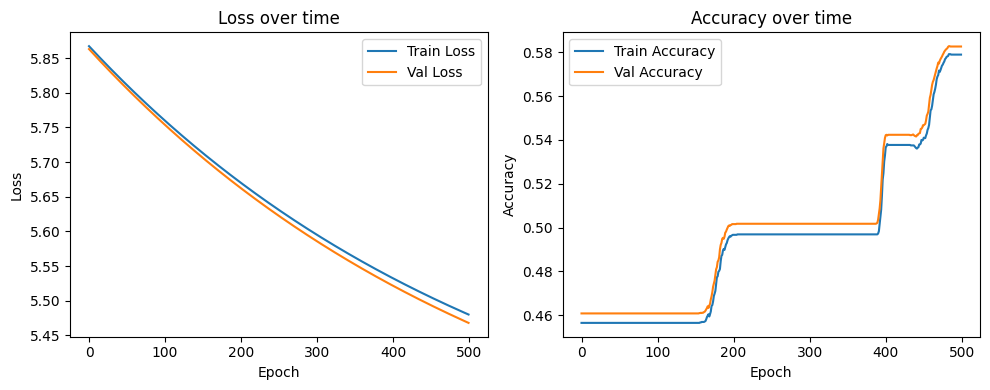

Epoch 0:
Train Loss 6.093990080701939
Train Acc 0.395625
Val Loss 6.118155079395524
Val Acc 0.38921874999999995

Epoch 50:
Train Loss 5.367310223030531
Train Acc 0.58875
Val Loss 5.3623091079256895
Val Acc 0.5901562499999999

Epoch 100:
Train Loss 5.23271503788817
Train Acc 0.6452083333333334
Val Loss 5.21534944489823
Val Acc 0.65140625

Epoch 150:
Train Loss 5.2059603948347455
Train Acc 0.6452083333333334
Val Loss 5.183140949724507
Val Acc 0.65140625

Epoch 200:
Train Loss 5.200378873687497
Train Acc 0.6452083333333334
Val Loss 5.175110256285755
Val Acc 0.65140625

Epoch 250:
Train Loss 5.1991424441728125
Train Acc 0.6452083333333334
Val Loss 5.172827250126367
Val Acc 0.65140625

Epoch 300:
Train Loss 5.198763757471986
Train Acc 0.6452083333333334
Val Loss 5.17196535171133
Val Acc 0.65140625

Epoch 350:
Train Loss 5.198573857358784
Train Acc 0.6452083333333334
Val Loss 5.1715450927391835
Val Acc 0.65140625

Epoch 400:
Train Loss 5.198421099146126
Train Acc 0.6452083333333334
Val Loss 

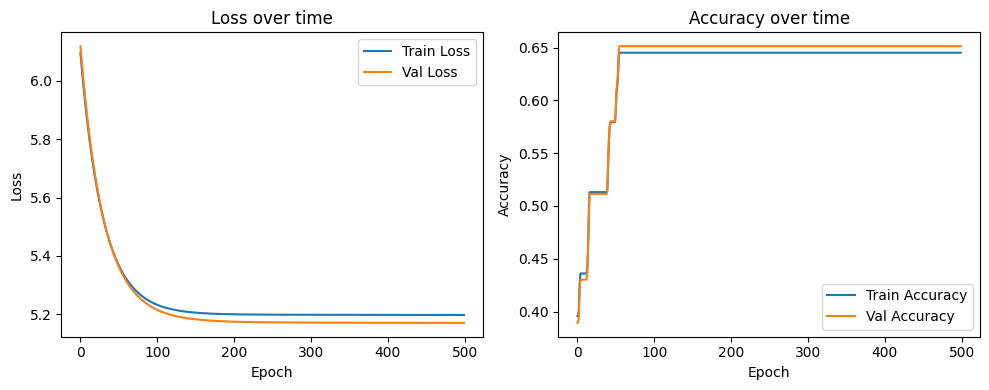

Epoch 0:
Train Loss 5.375866641261843
Train Acc 0.6377083333333333
Val Loss 5.3712473495539665
Val Acc 0.63953125

Epoch 50:
Train Loss 4.4874955044113705
Train Acc 0.7472916666666667
Val Loss 4.535417057823442
Val Acc 0.7442187499999999

Epoch 100:
Train Loss 4.0444170117542155
Train Acc 0.763125
Val Loss 4.172543105780255
Val Acc 0.75609375

Epoch 150:
Train Loss 3.6364351479492263
Train Acc 0.8033333333333333
Val Loss 3.871071052546639
Val Acc 0.78453125

Epoch 200:
Train Loss 3.1289495298170125
Train Acc 0.8472916666666667
Val Loss 3.48625370176807
Val Acc 0.81796875

Epoch 250:
Train Loss 2.652846535692213
Train Acc 0.8845833333333333
Val Loss 3.1327790832616405
Val Acc 0.84921875

Epoch 300:
Train Loss 2.2907095753322557
Train Acc 0.901875
Val Loss 2.883947336357819
Val Acc 0.86171875

Epoch 350:
Train Loss 2.0254807787539666
Train Acc 0.9141666666666667
Val Loss 2.7183064444173617
Val Acc 0.87

Epoch 400:
Train Loss 1.8298871097369078
Train Acc 0.9220833333333334
Val Loss 2.6136

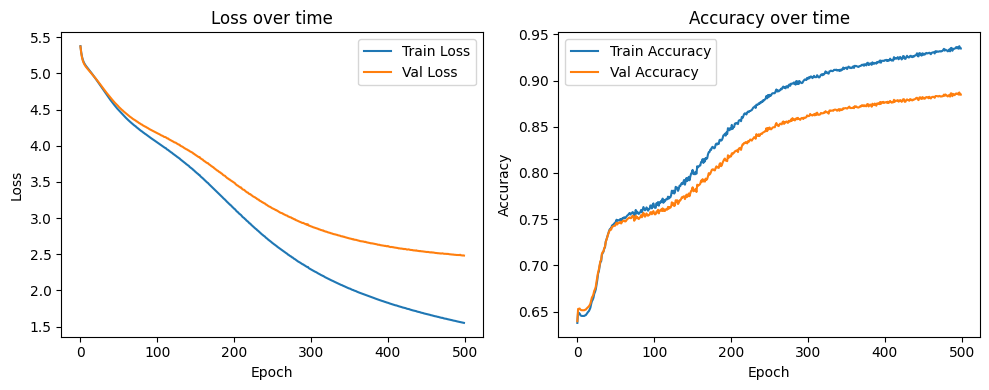

Epoch 0:
Train Loss 5.534032755206368
Train Acc 0.5075000000000001
Val Loss 5.534467773560095
Val Acc 0.5028125

Epoch 50:
Train Loss 5.514212270896029
Train Acc 0.5347916666666667
Val Loss 5.51440225924392
Val Acc 0.530625

Epoch 100:
Train Loss 5.495727005581475
Train Acc 0.5591666666666666
Val Loss 5.495669643587402
Val Acc 0.5549999999999999

Epoch 150:
Train Loss 5.478446155671801
Train Acc 0.5745833333333333
Val Loss 5.478138644196413
Val Acc 0.5765625

Epoch 200:
Train Loss 5.462256073929599
Train Acc 0.58875
Val Loss 5.461695279138914
Val Acc 0.59109375

Epoch 250:
Train Loss 5.447057701348881
Train Acc 0.6033333333333333
Val Loss 5.4462402776790375
Val Acc 0.604375

Epoch 300:
Train Loss 5.432764396041369
Train Acc 0.6108333333333333
Val Loss 5.431686891269599
Val Acc 0.6135937499999999

Epoch 350:
Train Loss 5.419300099299339
Train Acc 0.6231249999999999
Val Loss 5.417959044292556
Val Acc 0.62734375

Epoch 400:
Train Loss 5.406597787020112
Train Acc 0.625
Val Loss 5.404989772

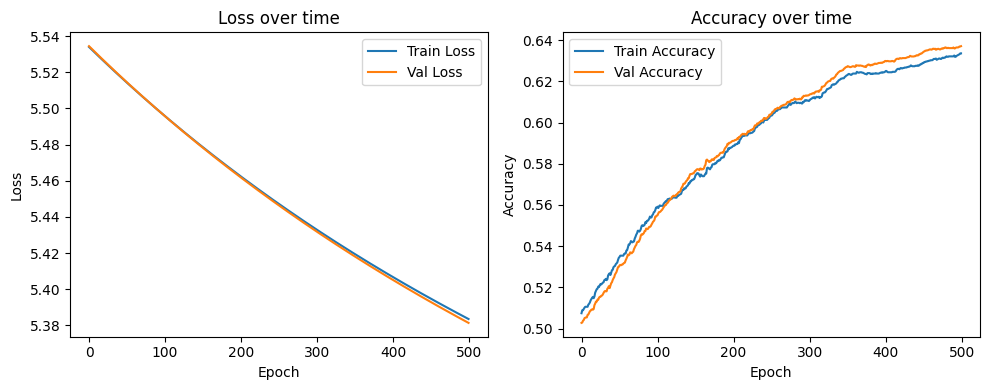

Epoch 0:
Train Loss 5.486408479541867
Train Acc 0.5460416666666666
Val Loss 5.482524650012644
Val Acc 0.5528124999999999

Epoch 50:
Train Loss 5.259126956098226
Train Acc 0.6447916666666667
Val Loss 5.247496885468756
Val Acc 0.6504687499999999

Epoch 100:
Train Loss 5.197463209570763
Train Acc 0.6452083333333334
Val Loss 5.183098634897717
Val Acc 0.65140625

Epoch 150:
Train Loss 5.160800500415784
Train Acc 0.6452083333333334
Val Loss 5.145863027332381
Val Acc 0.65140625

Epoch 200:
Train Loss 5.133943668813572
Train Acc 0.6452083333333334
Val Loss 5.119603034593692
Val Acc 0.65140625

Epoch 250:
Train Loss 5.111732009081347
Train Acc 0.6452083333333334
Val Loss 5.098687879087968
Val Acc 0.65140625

Epoch 300:
Train Loss 5.091756411004111
Train Acc 0.6452083333333334
Val Loss 5.080387598650879
Val Acc 0.65140625

Epoch 350:
Train Loss 5.072843831329271
Train Acc 0.6460416666666666
Val Loss 5.063412066777116
Val Acc 0.6520312500000001

Epoch 400:
Train Loss 5.054403923255968
Train Acc 0

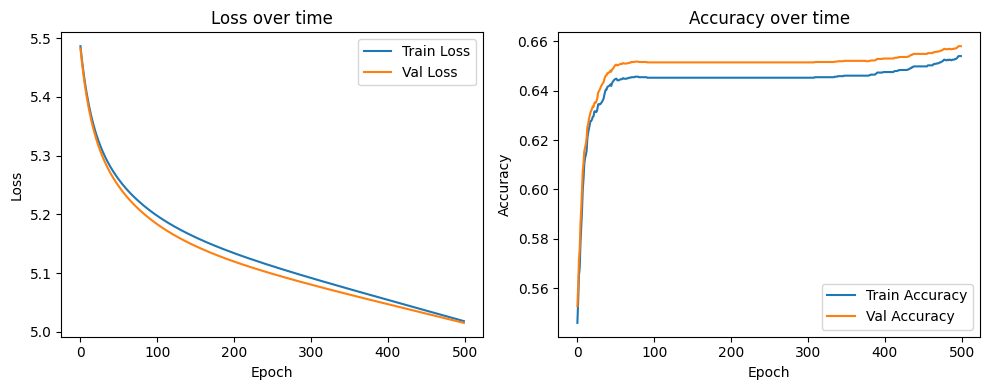

Epoch 0:
Train Loss 5.30203867385437
Train Acc 0.6427083333333333
Val Loss 5.281212004984123
Val Acc 0.6496875

Epoch 50:
Train Loss 4.25394658674092
Train Acc 0.774375
Val Loss 4.326933162665422
Val Acc 0.77234375

Epoch 100:
Train Loss 3.4802062522842014
Train Acc 0.8049999999999999
Val Loss 3.6884754709718535
Val Acc 0.79625

Epoch 150:
Train Loss 2.728144622577099
Train Acc 0.854375
Val Loss 3.1136752256218427
Val Acc 0.833125

Epoch 200:
Train Loss 1.9383739500469055
Train Acc 0.94625
Val Loss 2.5352874388829747
Val Acc 0.9020312500000001

Epoch 250:
Train Loss 1.2631733905603937
Train Acc 0.9920833333333333
Val Loss 2.056986866302084
Val Acc 0.93671875

Epoch 300:
Train Loss 0.820313909369878
Train Acc 0.9985416666666667
Val Loss 1.7676439740143823
Val Acc 0.9403125

Epoch 350:
Train Loss 0.5633321320745577
Train Acc 0.9995833333333334
Val Loss 1.6241612080383583
Val Acc 0.94140625

Epoch 400:
Train Loss 0.4114284555432888
Train Acc 1.0
Val Loss 1.5512947186250385
Val Acc 0.94078

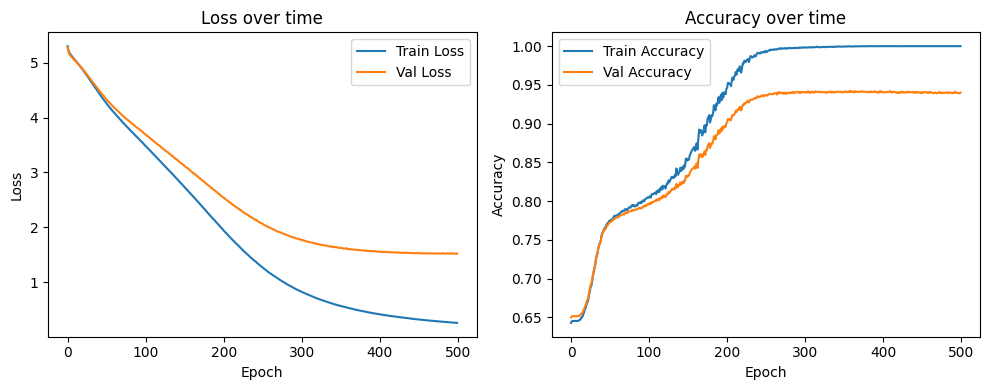

Epoch 0:
Train Loss 5.505140536639312
Train Acc 0.5535416666666666
Val Loss 5.50443199029613
Val Acc 0.5543750000000001

Epoch 50:
Train Loss 5.475432703182876
Train Acc 0.5808333333333333
Val Loss 5.4736135356677895
Val Acc 0.58359375

Epoch 100:
Train Loss 5.4497573405474355
Train Acc 0.5914583333333333
Val Loss 5.446934159836803
Val Acc 0.5971875

Epoch 150:
Train Loss 5.427357728529434
Train Acc 0.60375
Val Loss 5.423624563942396
Val Acc 0.61109375

Epoch 200:
Train Loss 5.407631385057321
Train Acc 0.6110416666666667
Val Loss 5.403071390226139
Val Acc 0.618125

Epoch 250:
Train Loss 5.390099127155568
Train Acc 0.6170833333333333
Val Loss 5.384786064193086
Val Acc 0.6248437499999999

Epoch 300:
Train Loss 5.374379555416183
Train Acc 0.6212500000000001
Val Loss 5.368379072974335
Val Acc 0.62984375

Epoch 350:
Train Loss 5.360168471949813
Train Acc 0.6264583333333333
Val Loss 5.353539198020339
Val Acc 0.6346875000000001

Epoch 400:
Train Loss 5.347222509691978
Train Acc 0.63
Val Loss 

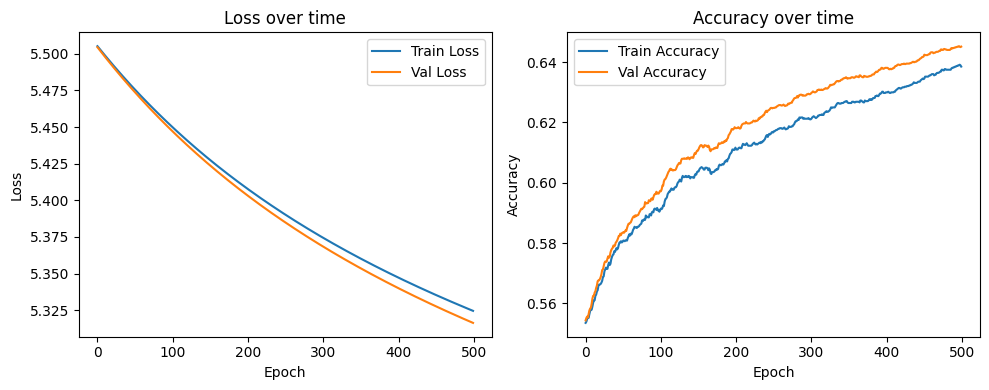

Epoch 0:
Train Loss 5.579656247332155
Train Acc 0.5025
Val Loss 5.575658256293771
Val Acc 0.50453125

Epoch 50:
Train Loss 5.292404518133927
Train Acc 0.6266666666666667
Val Loss 5.284272582169148
Val Acc 0.630625

Epoch 100:
Train Loss 5.201827037352034
Train Acc 0.6452083333333334
Val Loss 5.189954529684192
Val Acc 0.6509375

Epoch 150:
Train Loss 5.149576355539175
Train Acc 0.6452083333333334
Val Loss 5.135824538866871
Val Acc 0.65140625

Epoch 200:
Train Loss 5.112356014544623
Train Acc 0.6452083333333334
Val Loss 5.098302494371917
Val Acc 0.65140625

Epoch 250:
Train Loss 5.081312025928998
Train Acc 0.6460416666666666
Val Loss 5.067984578887235
Val Acc 0.6520312500000001

Epoch 300:
Train Loss 5.052593879246168
Train Acc 0.6470833333333333
Val Loss 5.040672177834718
Val Acc 0.653125

Epoch 350:
Train Loss 5.02452208801022
Train Acc 0.6489583333333333
Val Loss 5.014407476207918
Val Acc 0.6546875

Epoch 400:
Train Loss 4.99636556852456
Train Acc 0.650625
Val Loss 4.988347445083755
V

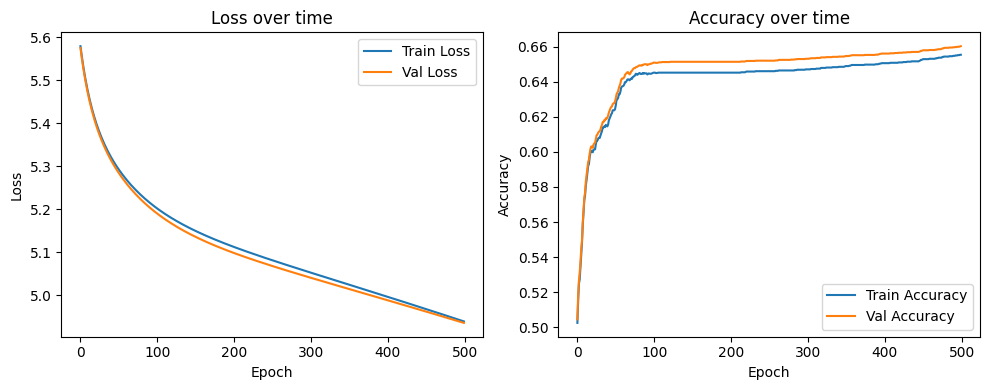

Epoch 0:
Train Loss 5.334443432657998
Train Acc 0.645
Val Loss 5.320379564751436
Val Acc 0.64984375

Epoch 50:
Train Loss 4.112612852842499
Train Acc 0.7664583333333334
Val Loss 4.236701595429409
Val Acc 0.75578125

Epoch 100:
Train Loss 2.5403429815352263
Train Acc 0.8939583333333333
Val Loss 3.0364156260316486
Val Acc 0.85546875

Epoch 150:
Train Loss 1.0143659662673732
Train Acc 0.9845833333333334
Val Loss 2.034791531394474
Val Acc 0.9225

Epoch 200:
Train Loss 0.4530146261960408
Train Acc 0.9995833333333334
Val Loss 1.848903217716859
Val Acc 0.93296875

Epoch 250:
Train Loss 0.2757654478293462
Train Acc 1.0
Val Loss 1.9274606115970758
Val Acc 0.93171875

Epoch 300:
Train Loss 0.1971019621415312
Train Acc 1.0
Val Loss 2.047837773588614
Val Acc 0.93140625

Epoch 350:
Train Loss 0.15110189013800632
Train Acc 1.0
Val Loss 2.1597232045055885
Val Acc 0.9290625

Epoch 400:
Train Loss 0.12282363117359353
Train Acc 1.0
Val Loss 2.262276223129917
Val Acc 0.92796875

Epoch 450:
Train Loss 0.1

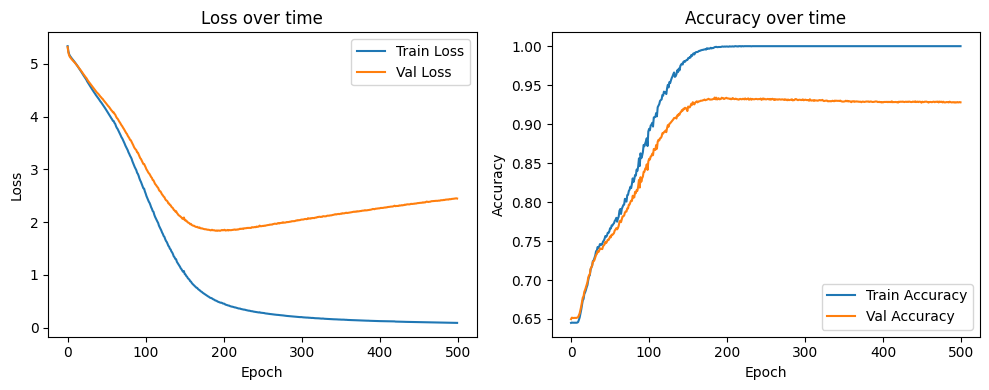

Epoch 0:
Train Loss 5.596869518190883
Train Acc 0.4822916666666667
Val Loss 5.598407994934048
Val Acc 0.47875

Epoch 50:
Train Loss 5.562322124479808
Train Acc 0.4960416666666667
Val Loss 5.562970292926777
Val Acc 0.49765625

Epoch 100:
Train Loss 5.533060166485854
Train Acc 0.5329166666666667
Val Loss 5.532896558088076
Val Acc 0.53359375

Epoch 150:
Train Loss 5.507816632317979
Train Acc 0.5579166666666666
Val Loss 5.506905529944038
Val Acc 0.55375

Epoch 200:
Train Loss 5.485636408937923
Train Acc 0.5733333333333333
Val Loss 5.484031351412695
Val Acc 0.57140625

Epoch 250:
Train Loss 5.465811835634619
Train Acc 0.5854166666666667
Val Loss 5.463558092250121
Val Acc 0.584375

Epoch 300:
Train Loss 5.447824164953774
Train Acc 0.5933333333333333
Val Loss 5.444960496520232
Val Acc 0.5940624999999999

Epoch 350:
Train Loss 5.431295122956849
Train Acc 0.6
Val Loss 5.427855067435798
Val Acc 0.59984375

Epoch 400:
Train Loss 5.415949110148719
Train Acc 0.604375
Val Loss 5.4119619524354405
Val

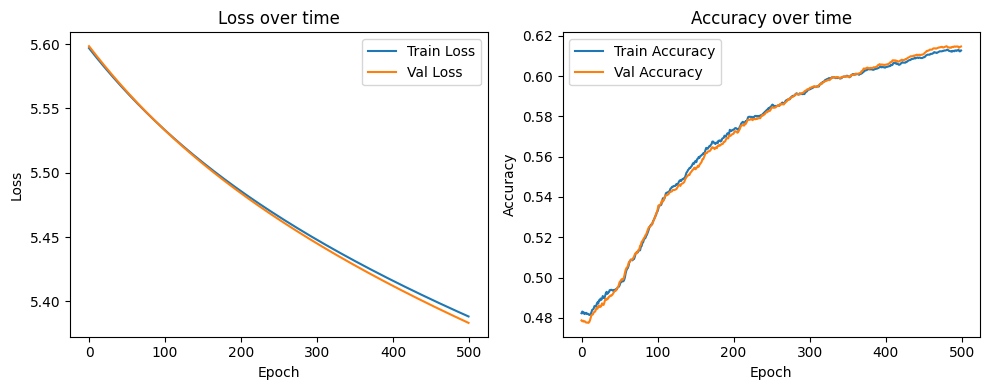

Epoch 0:
Train Loss 5.527067021306542
Train Acc 0.52875
Val Loss 5.529759529731896
Val Acc 0.53

Epoch 50:
Train Loss 5.262928700773291
Train Acc 0.6404166666666666
Val Loss 5.255720491216871
Val Acc 0.64515625

Epoch 100:
Train Loss 5.1752946997816265
Train Acc 0.6452083333333334
Val Loss 5.162606406171444
Val Acc 0.65140625

Epoch 150:
Train Loss 5.137703884055727
Train Acc 0.6452083333333334
Val Loss 5.123442634755701
Val Acc 0.65140625

Epoch 200:
Train Loss 5.112683700571634
Train Acc 0.6452083333333334
Val Loss 5.09923230649881
Val Acc 0.65140625

Epoch 250:
Train Loss 5.089159185803175
Train Acc 0.6452083333333334
Val Loss 5.077799683179482
Val Acc 0.65140625

Epoch 300:
Train Loss 5.064395921840713
Train Acc 0.6460416666666666
Val Loss 5.055865645349468
Val Acc 0.6521874999999999

Epoch 350:
Train Loss 5.037618094224929
Train Acc 0.6472916666666666
Val Loss 5.0324019742738635
Val Acc 0.65359375

Epoch 400:
Train Loss 5.008622196942413
Train Acc 0.6514583333333333
Val Loss 5.007

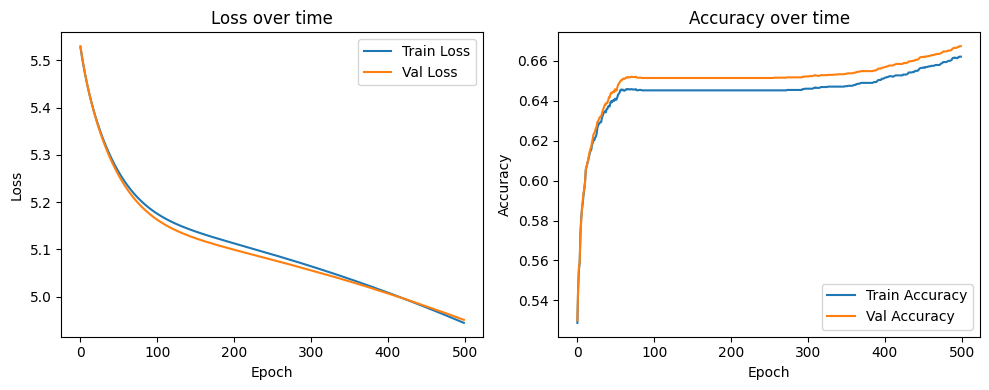

Epoch 0:
Train Loss 5.428915145208815
Train Acc 0.6258333333333334
Val Loss 5.427020050959495
Val Acc 0.6278125

Epoch 50:
Train Loss 4.4624827475497515
Train Acc 0.7347916666666667
Val Loss 4.53895026685327
Val Acc 0.73109375

Epoch 100:
Train Loss 4.00567930358387
Train Acc 0.7625
Val Loss 4.1764434990293084
Val Acc 0.7553125

Epoch 150:
Train Loss 3.5722486098611252
Train Acc 0.7895833333333333
Val Loss 3.854424995596464
Val Acc 0.7753125

Epoch 200:
Train Loss 3.0625106229385954
Train Acc 0.8395833333333333
Val Loss 3.4761808241700534
Val Acc 0.81421875

Epoch 250:
Train Loss 2.6217963523173697
Train Acc 0.8708333333333333
Val Loss 3.154152417524509
Val Acc 0.8375

Epoch 300:
Train Loss 2.3213194966036603
Train Acc 0.885625
Val Loss 2.955107256478659
Val Acc 0.8484375

Epoch 350:
Train Loss 2.1119046774919887
Train Acc 0.8935416666666667
Val Loss 2.8366518063522177
Val Acc 0.855

Epoch 400:
Train Loss 1.950781196602061
Train Acc 0.9010416666666666
Val Loss 2.754846719583847
Val Acc

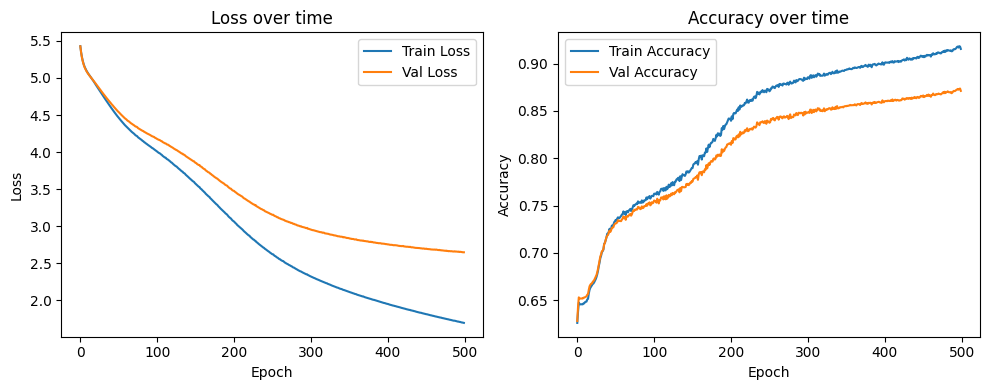

Epoch 0:
Train Loss 5.502893511880081
Train Acc 0.5483333333333333
Val Loss 5.49918439839558
Val Acc 0.5525

Epoch 50:
Train Loss 5.487353663814366
Train Acc 0.5560416666666667
Val Loss 5.482983332972112
Val Acc 0.5589062499999999

Epoch 100:
Train Loss 5.472702542911733
Train Acc 0.5652083333333333
Val Loss 5.467706666882601
Val Acc 0.5671875

Epoch 150:
Train Loss 5.45866369698452
Train Acc 0.5760416666666667
Val Loss 5.453066282721452
Val Acc 0.57765625

Epoch 200:
Train Loss 5.4450218708581435
Train Acc 0.5918749999999999
Val Loss 5.43879635557562
Val Acc 0.5940624999999999

Epoch 250:
Train Loss 5.4310148759584
Train Acc 0.5966666666666667
Val Loss 5.424225523307441
Val Acc 0.5996874999999999

Epoch 300:
Train Loss 5.416940804304584
Train Acc 0.6066666666666667
Val Loss 5.409688568155615
Val Acc 0.60796875

Epoch 350:
Train Loss 5.402716038787323
Train Acc 0.6120833333333333
Val Loss 5.395019323610199
Val Acc 0.61328125

Epoch 400:
Train Loss 5.388423094502677
Train Acc 0.61583333

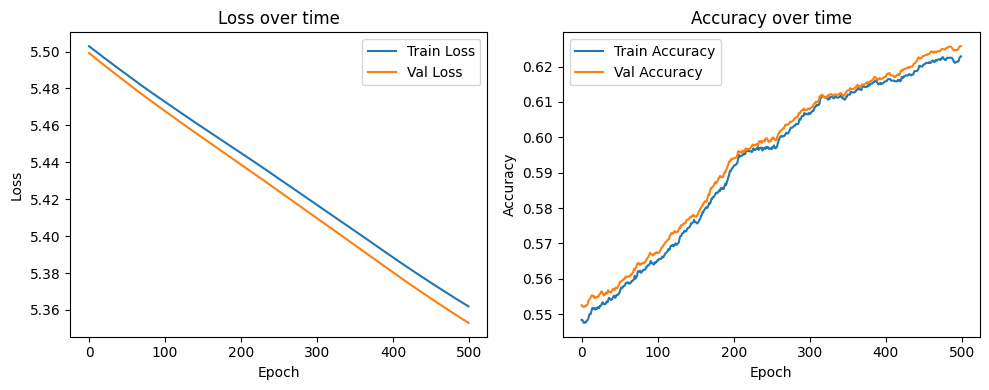

Epoch 0:
Train Loss 5.505570676442525
Train Acc 0.5933333333333333
Val Loss 5.5020139542815425
Val Acc 0.5996874999999999

Epoch 50:
Train Loss 5.242744283637009
Train Acc 0.6452083333333334
Val Loss 5.214680723494418
Val Acc 0.65140625

Epoch 100:
Train Loss 5.19563797451712
Train Acc 0.6452083333333334
Val Loss 5.168271224032947
Val Acc 0.65140625

Epoch 150:
Train Loss 5.16369048670143
Train Acc 0.6452083333333334
Val Loss 5.139755436645523
Val Acc 0.65140625

Epoch 200:
Train Loss 5.139025876063502
Train Acc 0.6452083333333334
Val Loss 5.118750073857288
Val Acc 0.65140625

Epoch 250:
Train Loss 5.117981300121485
Train Acc 0.6452083333333334
Val Loss 5.101240466300401
Val Acc 0.65140625

Epoch 300:
Train Loss 5.098698079052177
Train Acc 0.6452083333333334
Val Loss 5.08524211917565
Val Acc 0.65140625

Epoch 350:
Train Loss 5.080065949066732
Train Acc 0.6454166666666667
Val Loss 5.069772508278685
Val Acc 0.65171875

Epoch 400:
Train Loss 5.061730569624815
Train Acc 0.645625
Val Loss 5

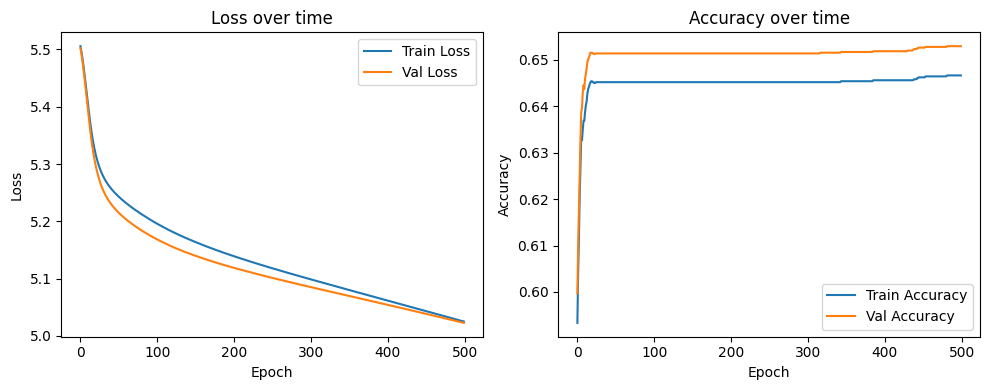

Epoch 0:
Train Loss 5.372482773223255
Train Acc 0.6322916666666667
Val Loss 5.364799407043002
Val Acc 0.635

Epoch 50:
Train Loss 4.338743845929085
Train Acc 0.7658333333333334
Val Loss 4.412083642704462
Val Acc 0.76328125

Epoch 100:
Train Loss 3.477601128302772
Train Acc 0.803125
Val Loss 3.6918301079713025
Val Acc 0.7934375

Epoch 150:
Train Loss 2.7003240243904383
Train Acc 0.8572916666666667
Val Loss 3.101874257616763
Val Acc 0.834375

Epoch 200:
Train Loss 1.8856178206443952
Train Acc 0.9491666666666667
Val Loss 2.513038055308593
Val Acc 0.9028125

Epoch 250:
Train Loss 1.1967635038703899
Train Acc 0.9879166666666667
Val Loss 2.0321915346109485
Val Acc 0.9321875

Epoch 300:
Train Loss 0.7605533149188216
Train Acc 0.9977083333333333
Val Loss 1.7581422306374312
Val Acc 0.94046875

Epoch 350:
Train Loss 0.5061686255801586
Train Acc 0.999375
Val Loss 1.628782433107971
Val Acc 0.9421875

Epoch 400:
Train Loss 0.3591895814305444
Train Acc 0.9997916666666666
Val Loss 1.5747282522823054


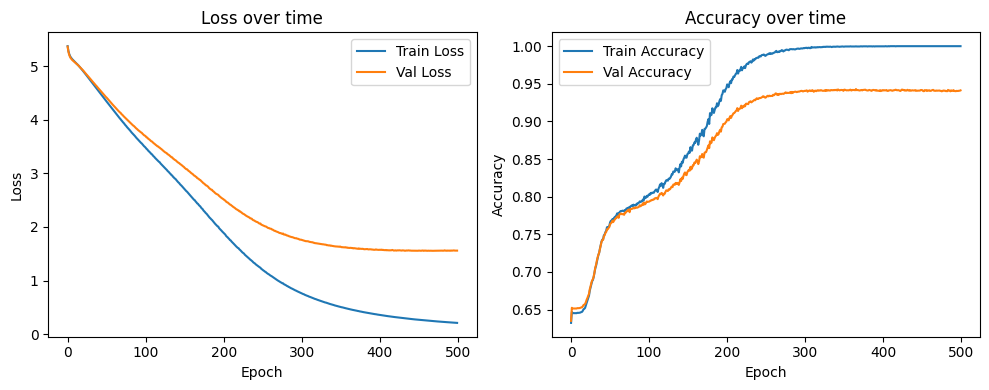

Epoch 0:
Train Loss 5.538183528442417
Train Acc 0.5127083333333333
Val Loss 5.535967876074085
Val Acc 0.5134375

Epoch 50:
Train Loss 5.5197344529687
Train Acc 0.5266666666666666
Val Loss 5.516304795013975
Val Acc 0.52609375

Epoch 100:
Train Loss 5.503003786770169
Train Acc 0.5360416666666667
Val Loss 5.498401501418093
Val Acc 0.5375

Epoch 150:
Train Loss 5.487897349056662
Train Acc 0.5449999999999999
Val Loss 5.482244008089425
Val Acc 0.54515625

Epoch 200:
Train Loss 5.473896214569135
Train Acc 0.5583333333333333
Val Loss 5.467274487873523
Val Acc 0.5578125

Epoch 250:
Train Loss 5.46098320430173
Train Acc 0.5670833333333334
Val Loss 5.453467558719976
Val Acc 0.56546875

Epoch 300:
Train Loss 5.448912036305466
Train Acc 0.5764583333333333
Val Loss 5.44054939331274
Val Acc 0.575

Epoch 350:
Train Loss 5.437611562084642
Train Acc 0.584375
Val Loss 5.4284322749551555
Val Acc 0.58484375

Epoch 400:
Train Loss 5.426989207502668
Train Acc 0.595
Val Loss 5.417050226598499
Val Acc 0.596093

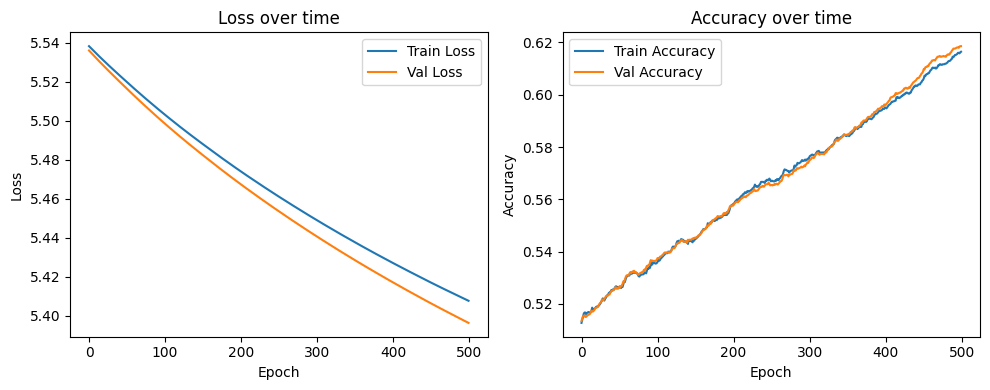

Epoch 0:
Train Loss 5.548751824355575
Train Acc 0.5025
Val Loss 5.545700947226833
Val Acc 0.50703125

Epoch 50:
Train Loss 5.380466722963653
Train Acc 0.63125
Val Loss 5.373087286959102
Val Acc 0.6387499999999999

Epoch 100:
Train Loss 5.28618331788377
Train Acc 0.6452083333333334
Val Loss 5.274756551807058
Val Acc 0.6515625

Epoch 150:
Train Loss 5.226595478332626
Train Acc 0.6452083333333334
Val Loss 5.212490633830055
Val Acc 0.65140625

Epoch 200:
Train Loss 5.188024534134484
Train Acc 0.6452083333333334
Val Loss 5.172615710219137
Val Acc 0.65140625

Epoch 250:
Train Loss 5.161657030542546
Train Acc 0.6452083333333334
Val Loss 5.145844202435576
Val Acc 0.65140625

Epoch 300:
Train Loss 5.14131380662145
Train Acc 0.6452083333333334
Val Loss 5.125840950763063
Val Acc 0.65140625

Epoch 350:
Train Loss 5.124507559671713
Train Acc 0.6452083333333334
Val Loss 5.109722834624956
Val Acc 0.65140625

Epoch 400:
Train Loss 5.109246765817116
Train Acc 0.6452083333333334
Val Loss 5.0955004807289

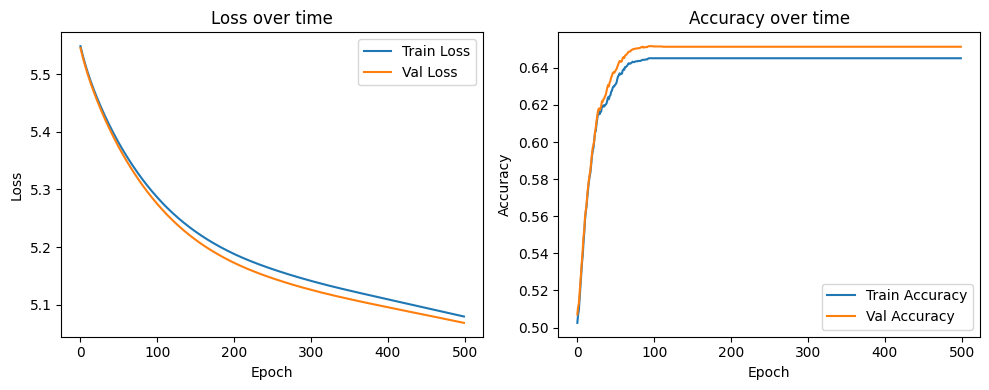

Epoch 0:
Train Loss 5.3930692375289455
Train Acc 0.6325000000000001
Val Loss 5.386468299761289
Val Acc 0.63625

Epoch 50:
Train Loss 4.055872293635884
Train Acc 0.768125
Val Loss 4.196059532713159
Val Acc 0.7609375

Epoch 100:
Train Loss 2.243772326592603
Train Acc 0.8954166666666666
Val Loss 2.8661114970062003
Val Acc 0.85640625

Epoch 150:
Train Loss 0.8614338573883739
Train Acc 0.9747916666666667
Val Loss 2.1464202153529577
Val Acc 0.91671875

Epoch 200:
Train Loss 0.33676440032851634
Train Acc 0.9945833333333334
Val Loss 2.175616439891351
Val Acc 0.930625

Epoch 250:
Train Loss 0.1635656375480991
Train Acc 0.9979166666666667
Val Loss 2.4069995788743834
Val Acc 0.935

Epoch 300:
Train Loss 0.08711732374195319
Train Acc 0.9997916666666666
Val Loss 2.609847890488678
Val Acc 0.93578125

Epoch 350:
Train Loss 0.052775915028720914
Train Acc 1.0
Val Loss 2.785128107065071
Val Acc 0.93640625

Epoch 400:
Train Loss 0.0358805180463398
Train Acc 1.0
Val Loss 2.9174322717988574
Val Acc 0.93671

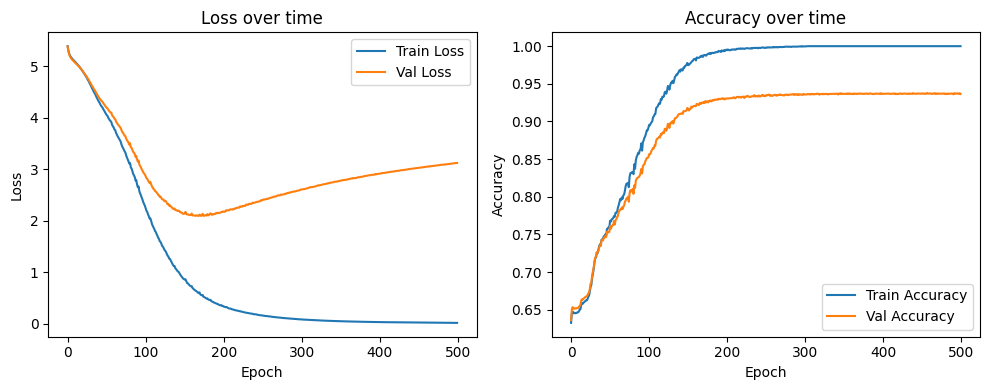

Epoch 0:
Train Loss 5.567146552035773
Train Acc 0.42166666666666663
Val Loss 5.568626581004623
Val Acc 0.42125

Epoch 50:
Train Loss 5.5516527341329
Train Acc 0.5008333333333334
Val Loss 5.55263879990295
Val Acc 0.49875

Epoch 100:
Train Loss 5.537443963544759
Train Acc 0.549375
Val Loss 5.537906280188795
Val Acc 0.55078125

Epoch 150:
Train Loss 5.524284959256066
Train Acc 0.5825
Val Loss 5.524202700110984
Val Acc 0.5809375

Epoch 200:
Train Loss 5.511960755964615
Train Acc 0.6004166666666666
Val Loss 5.51143708903887
Val Acc 0.6025

Epoch 250:
Train Loss 5.500432639894471
Train Acc 0.6154166666666667
Val Loss 5.4995012241423185
Val Acc 0.6178125

Epoch 300:
Train Loss 5.489582788657518
Train Acc 0.625
Val Loss 5.488275767311114
Val Acc 0.6292187499999999

Epoch 350:
Train Loss 5.479422176189755
Train Acc 0.634375
Val Loss 5.477738875309493
Val Acc 0.63734375

Epoch 400:
Train Loss 5.46976988817728
Train Acc 0.6377083333333333
Val Loss 5.467713281152583
Val Acc 0.64296875

Epoch 450:


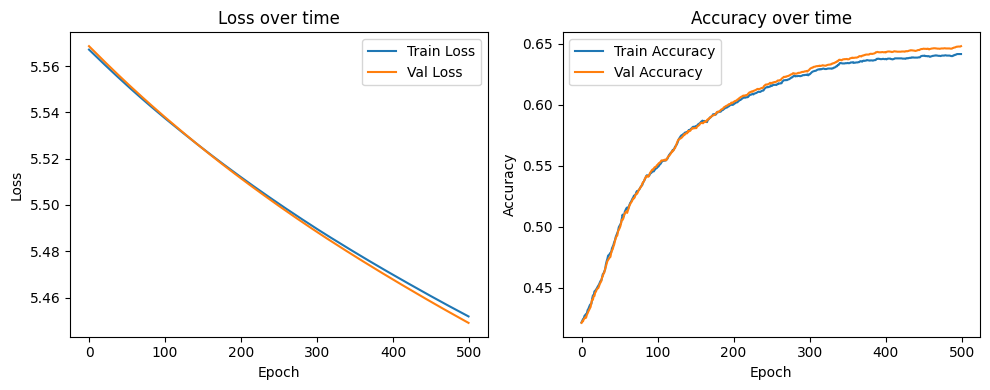

Epoch 0:
Train Loss 5.537312531067324
Train Acc 0.5185416666666667
Val Loss 5.533540245067635
Val Acc 0.52265625

Epoch 50:
Train Loss 5.3391930376561385
Train Acc 0.6445833333333333
Val Loss 5.322806568144706
Val Acc 0.6509375

Epoch 100:
Train Loss 5.248452028293943
Train Acc 0.6452083333333334
Val Loss 5.226669057837423
Val Acc 0.65140625

Epoch 150:
Train Loss 5.205349679743869
Train Acc 0.6452083333333334
Val Loss 5.181705036958981
Val Acc 0.65140625

Epoch 200:
Train Loss 5.1837335884099245
Train Acc 0.6452083333333334
Val Loss 5.1600585236003305
Val Acc 0.65140625

Epoch 250:
Train Loss 5.169985364587756
Train Acc 0.6452083333333334
Val Loss 5.147206824024404
Val Acc 0.65140625

Epoch 300:
Train Loss 5.159189676742077
Train Acc 0.6452083333333334
Val Loss 5.137644000841111
Val Acc 0.65140625

Epoch 350:
Train Loss 5.148926762915565
Train Acc 0.6452083333333334
Val Loss 5.128632592929603
Val Acc 0.65140625

Epoch 400:
Train Loss 5.137784770581384
Train Acc 0.6452083333333334
Val 

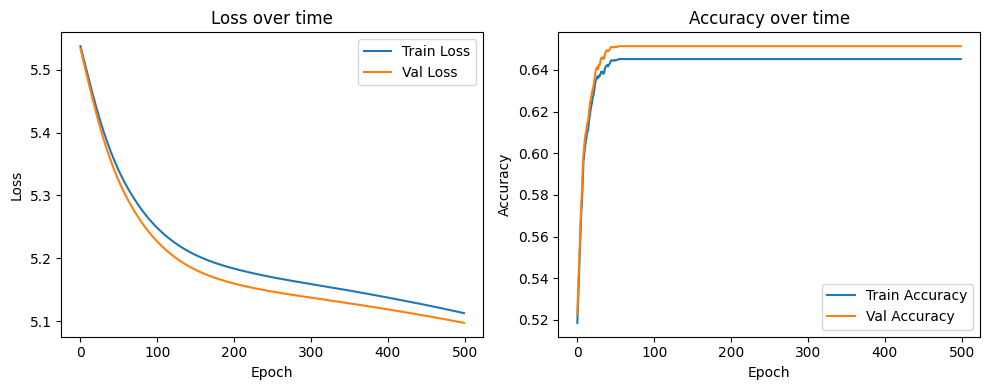

Epoch 0:
Train Loss 5.575895359290177
Train Acc 0.5297916666666667
Val Loss 5.571871639751482
Val Acc 0.53359375

Epoch 50:
Train Loss 5.138578649723443
Train Acc 0.6452083333333334
Val Loss 5.118650206688965
Val Acc 0.65140625

Epoch 100:
Train Loss 5.0598232140941555
Train Acc 0.6452083333333334
Val Loss 5.04831768000811
Val Acc 0.65140625

Epoch 150:
Train Loss 4.946181679327587
Train Acc 0.6627083333333333
Val Loss 4.9462584171121735
Val Acc 0.66671875

Epoch 200:
Train Loss 4.800979973733086
Train Acc 0.6829166666666666
Val Loss 4.816406981482959
Val Acc 0.68609375

Epoch 250:
Train Loss 4.6401239628091595
Train Acc 0.705625
Val Loss 4.67424259340621
Val Acc 0.7078125

Epoch 300:
Train Loss 4.484276299639332
Train Acc 0.7314583333333333
Val Loss 4.539488731176312
Val Acc 0.73328125

Epoch 350:
Train Loss 4.346358124885486
Train Acc 0.7495833333333333
Val Loss 4.422858187292136
Val Acc 0.7498437499999999

Epoch 400:
Train Loss 4.227825621608875
Train Acc 0.7589583333333334
Val Loss

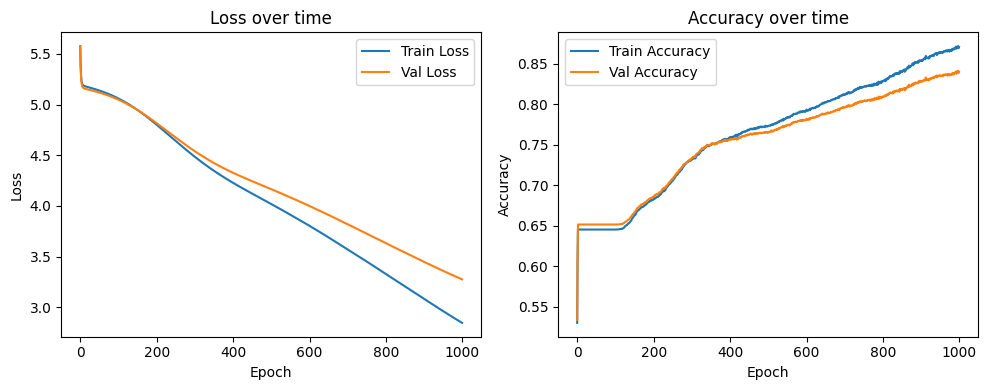

Epoch 0:
Train Loss 6.380952807753832
Train Acc 0.48416666666666663
Val Loss 6.408106537854078
Val Acc 0.4828125

Epoch 50:
Train Loss 6.309479539198315
Train Acc 0.49479166666666663
Val Loss 6.334918134787638
Val Acc 0.49421875000000004

Epoch 100:
Train Loss 6.242894266272927
Train Acc 0.5004166666666667
Val Loss 6.266690526537716
Val Acc 0.49953125

Epoch 150:
Train Loss 6.180828208712748
Train Acc 0.500625
Val Loss 6.203050917411892
Val Acc 0.49953125

Epoch 200:
Train Loss 6.122940705287777
Train Acc 0.5010416666666666
Val Loss 6.143654860711674
Val Acc 0.49984375000000003

Epoch 250:
Train Loss 6.068917493284016
Train Acc 0.5010416666666666
Val Loss 6.088184532164274
Val Acc 0.49984375000000003

Epoch 300:
Train Loss 6.018468968569176
Train Acc 0.5010416666666666
Val Loss 6.036346982111345
Val Acc 0.49984375000000003

Epoch 350:
Train Loss 5.971328463158042
Train Acc 0.5010416666666666
Val Loss 5.9878724039215365
Val Acc 0.49984375000000003

Epoch 400:
Train Loss 5.92725056792372

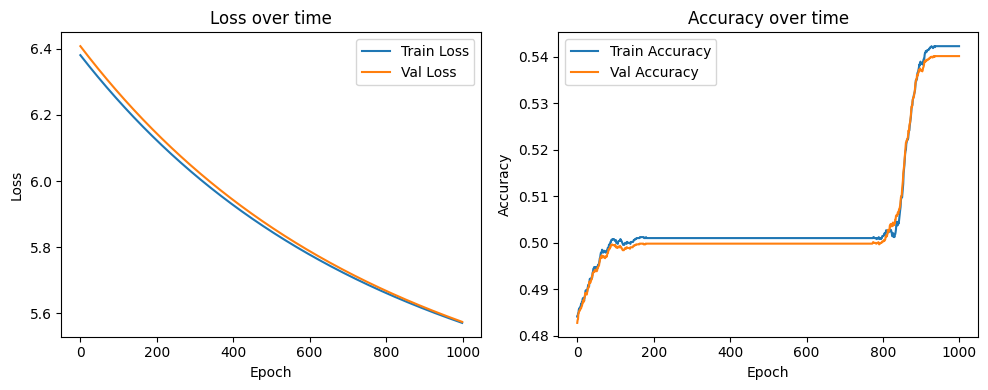

Epoch 0:
Train Loss 5.808289188597078
Train Acc 0.4614583333333333
Val Loss 5.803260268668015
Val Acc 0.46046875

Epoch 50:
Train Loss 5.399480488905627
Train Acc 0.5725
Val Loss 5.385352024434881
Val Acc 0.57640625

Epoch 100:
Train Loss 5.267166688919069
Train Acc 0.6452083333333334
Val Loss 5.247793746230759
Val Acc 0.65140625

Epoch 150:
Train Loss 5.221509752271689
Train Acc 0.6452083333333334
Val Loss 5.199035934012567
Val Acc 0.65140625

Epoch 200:
Train Loss 5.205084367732542
Train Acc 0.6452083333333334
Val Loss 5.180789400104264
Val Acc 0.65140625

Epoch 250:
Train Loss 5.1988512135252885
Train Acc 0.6452083333333334
Val Loss 5.173498057273732
Val Acc 0.65140625

Epoch 300:
Train Loss 5.19622709454074
Train Acc 0.6452083333333334
Val Loss 5.170273449460768
Val Acc 0.65140625

Epoch 350:
Train Loss 5.1948910635941
Train Acc 0.6452083333333334
Val Loss 5.168605652235589
Val Acc 0.65140625

Epoch 400:
Train Loss 5.194003678158262
Train Acc 0.6452083333333334
Val Loss 5.167562816

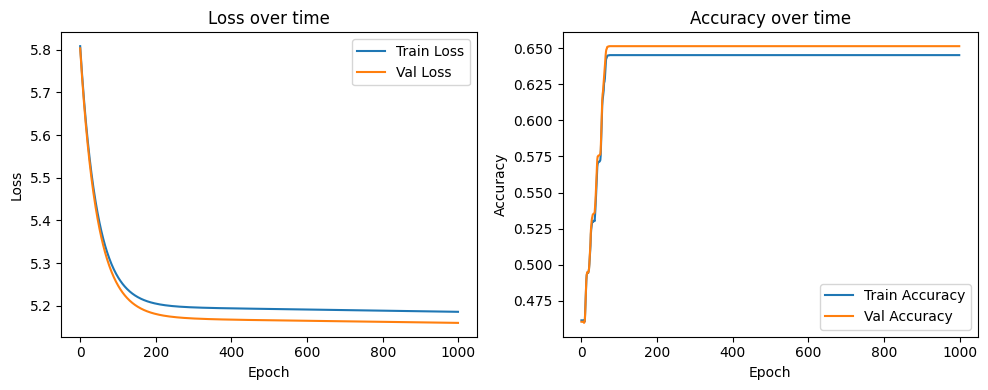

Epoch 0:
Train Loss 5.248217173924544
Train Acc 0.6452083333333334
Val Loss 5.231194244693006
Val Acc 0.65140625

Epoch 50:
Train Loss 5.094938045418942
Train Acc 0.6452083333333334
Val Loss 5.081878010356193
Val Acc 0.65140625

Epoch 100:
Train Loss 4.948244413527016
Train Acc 0.6516666666666666
Val Loss 4.953687145504293
Val Acc 0.65734375

Epoch 150:
Train Loss 4.74264242816809
Train Acc 0.69
Val Loss 4.77141798291718
Val Acc 0.6925

Epoch 200:
Train Loss 4.511744672532782
Train Acc 0.7364583333333333
Val Loss 4.565202096348331
Val Acc 0.7379687500000001

Epoch 250:
Train Loss 4.292617583879552
Train Acc 0.7654166666666666
Val Loss 4.370914527106226
Val Acc 0.76625

Epoch 300:
Train Loss 4.101047816514597
Train Acc 0.7758333333333334
Val Loss 4.204634235695177
Val Acc 0.7746875

Epoch 350:
Train Loss 3.9302433592135504
Train Acc 0.7814583333333334
Val Loss 4.059091256584904
Val Acc 0.779375

Epoch 400:
Train Loss 3.7655356552125583
Train Acc 0.7883333333333333
Val Loss 3.92240655379

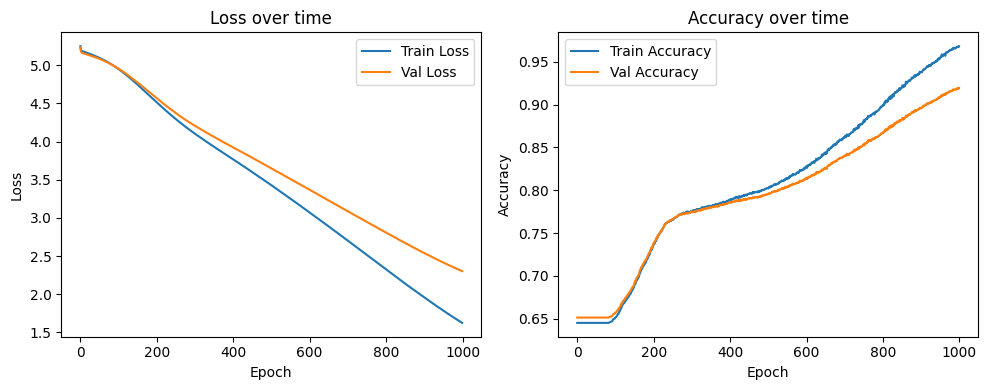

Epoch 0:
Train Loss 5.661809929680501
Train Acc 0.47520833333333334
Val Loss 5.662455690013811
Val Acc 0.47734374999999996

Epoch 50:
Train Loss 5.623501836841598
Train Acc 0.49083333333333334
Val Loss 5.623025985821256
Val Acc 0.49468749999999995

Epoch 100:
Train Loss 5.588390958956597
Train Acc 0.5116666666666667
Val Loss 5.586839276474965
Val Acc 0.51625

Epoch 150:
Train Loss 5.556207031151554
Train Acc 0.54625
Val Loss 5.5536232271200525
Val Acc 0.5526562500000001

Epoch 200:
Train Loss 5.526702836064005
Train Acc 0.5714583333333334
Val Loss 5.523128682413585
Val Acc 0.57546875

Epoch 250:
Train Loss 5.499652227801999
Train Acc 0.5716666666666667
Val Loss 5.495127677034675
Val Acc 0.5760937500000001

Epoch 300:
Train Loss 5.474848326554445
Train Acc 0.575
Val Loss 5.469411618586363
Val Acc 0.5782812500000001

Epoch 350:
Train Loss 5.45210186856279
Train Acc 0.5956250000000001
Val Loss 5.44578962737138
Val Acc 0.5996874999999999

Epoch 400:
Train Loss 5.431239697722418
Train Acc 0

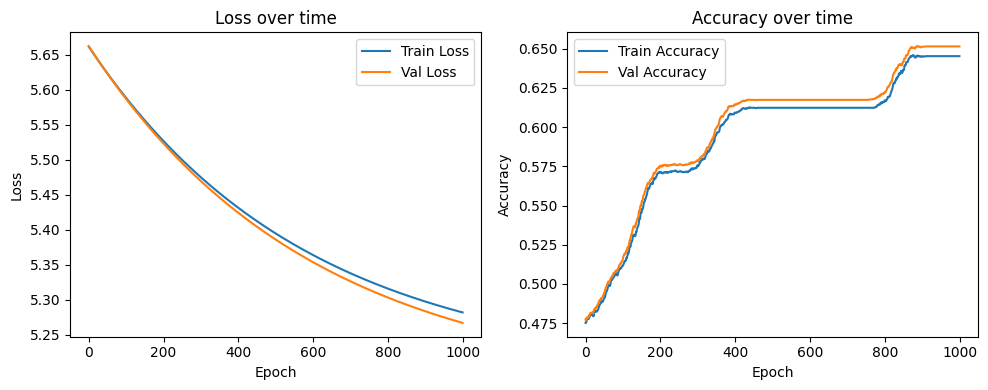

Epoch 0:
Train Loss 6.114202756826165
Train Acc 0.4002083333333334
Val Loss 6.131764442279798
Val Acc 0.39375000000000004

Epoch 50:
Train Loss 5.353342951332267
Train Acc 0.6070833333333333
Val Loss 5.344031364747957
Val Acc 0.611875

Epoch 100:
Train Loss 5.224076712260051
Train Acc 0.6452083333333334
Val Loss 5.204052451606014
Val Acc 0.65140625

Epoch 150:
Train Loss 5.199139244869131
Train Acc 0.6452083333333334
Val Loss 5.174733855810218
Val Acc 0.65140625

Epoch 200:
Train Loss 5.192633025299282
Train Acc 0.6452083333333334
Val Loss 5.166500356039749
Val Acc 0.65140625

Epoch 250:
Train Loss 5.1895462397336924
Train Acc 0.6452083333333334
Val Loss 5.162835467327013
Val Acc 0.65140625

Epoch 300:
Train Loss 5.187097854011194
Train Acc 0.6452083333333334
Val Loss 5.16030339667451
Val Acc 0.65140625

Epoch 350:
Train Loss 5.184772912234769
Train Acc 0.6452083333333334
Val Loss 5.158106377932075
Val Acc 0.65140625

Epoch 400:
Train Loss 5.182466027258647
Train Acc 0.6452083333333334

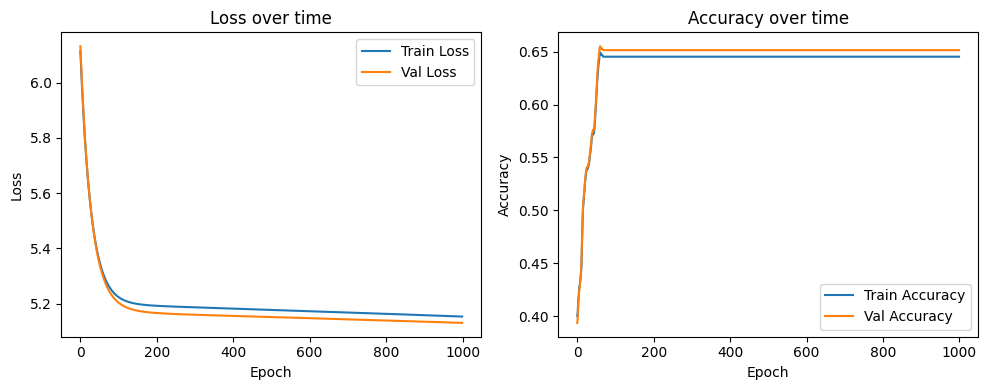

Epoch 0:
Train Loss 5.280603751675902
Train Acc 0.6110416666666667
Val Loss 5.262170153170512
Val Acc 0.6151562500000001

Epoch 50:
Train Loss 5.1959831577467765
Train Acc 0.6452083333333334
Val Loss 5.169065436487449
Val Acc 0.65140625

Epoch 100:
Train Loss 5.19264394443064
Train Acc 0.6452083333333334
Val Loss 5.166250501594156
Val Acc 0.65140625

Epoch 150:
Train Loss 5.187900986919726
Train Acc 0.6452083333333334
Val Loss 5.161878830119066
Val Acc 0.65140625

Epoch 200:
Train Loss 5.180446222935549
Train Acc 0.6452083333333334
Val Loss 5.155276115454893
Val Acc 0.65140625

Epoch 250:
Train Loss 5.167651268730214
Train Acc 0.6452083333333334
Val Loss 5.143550381213049
Val Acc 0.65140625

Epoch 300:
Train Loss 5.143659750610293
Train Acc 0.6452083333333334
Val Loss 5.122524661492982
Val Acc 0.65140625

Epoch 350:
Train Loss 5.097512547278359
Train Acc 0.6452083333333334
Val Loss 5.081452325561778
Val Acc 0.65140625

Epoch 400:
Train Loss 5.017579989621021
Train Acc 0.65125
Val Loss 

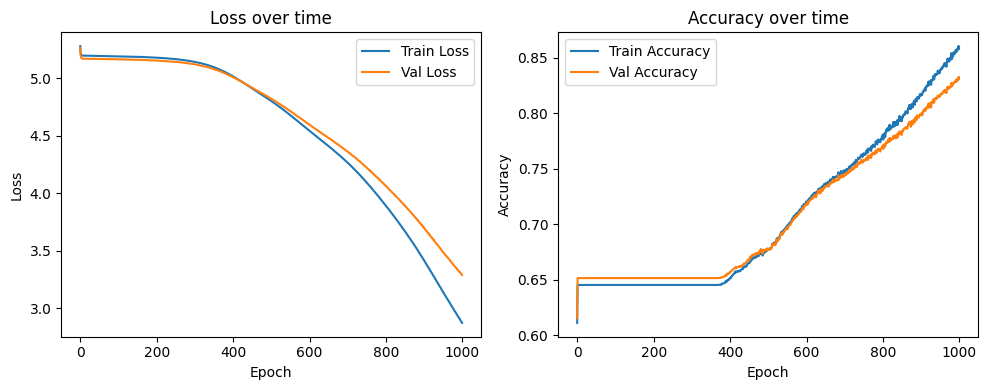

Epoch 0:
Train Loss 5.992343121210878
Train Acc 0.510625
Val Loss 6.010950228966846
Val Acc 0.50515625

Epoch 50:
Train Loss 5.917871978761486
Train Acc 0.510625
Val Loss 5.9341046170082565
Val Acc 0.50515625

Epoch 100:
Train Loss 5.849957724625513
Train Acc 0.510625
Val Loss 5.863943378047879
Val Acc 0.50515625

Epoch 150:
Train Loss 5.788098882589833
Train Acc 0.5170833333333333
Val Loss 5.799957830393242
Val Acc 0.5114062500000001

Epoch 200:
Train Loss 5.731822971296628
Train Acc 0.5447916666666667
Val Loss 5.741668689780258
Val Acc 0.54140625

Epoch 250:
Train Loss 5.68068510864392
Train Acc 0.5447916666666667
Val Loss 5.688624662714147
Val Acc 0.54140625

Epoch 300:
Train Loss 5.634266970219539
Train Acc 0.5447916666666667
Val Loss 5.640401390814109
Val Acc 0.54140625

Epoch 350:
Train Loss 5.592175988687471
Train Acc 0.5447916666666667
Val Loss 5.596600633759952
Val Acc 0.54140625

Epoch 400:
Train Loss 5.554044688311842
Train Acc 0.5447916666666667
Val Loss 5.556849585724081
V

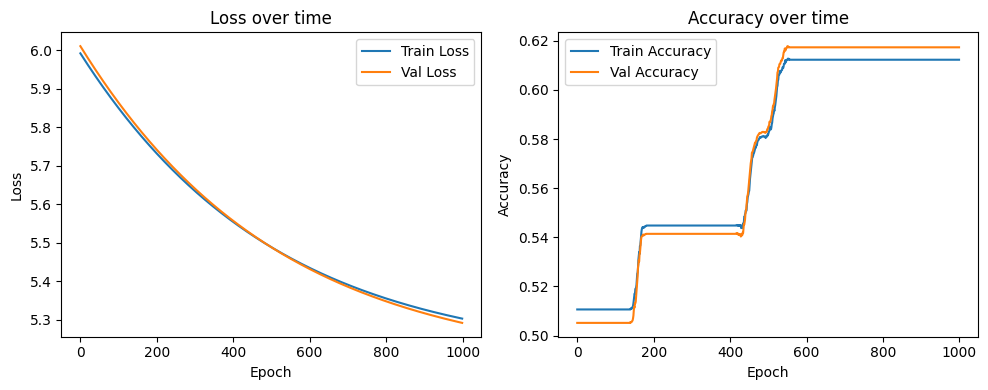

Epoch 0:
Train Loss 5.79307145226884
Train Acc 0.5364583333333333
Val Loss 5.795045244210676
Val Acc 0.53515625

Epoch 50:
Train Loss 5.279471010526479
Train Acc 0.6308333333333334
Val Loss 5.2625673863669
Val Acc 0.63625

Epoch 100:
Train Loss 5.21042452997317
Train Acc 0.6452083333333334
Val Loss 5.187025653606188
Val Acc 0.65140625

Epoch 150:
Train Loss 5.20002768012294
Train Acc 0.6452083333333334
Val Loss 5.174244666463162
Val Acc 0.65140625

Epoch 200:
Train Loss 5.198232630840148
Train Acc 0.6452083333333334
Val Loss 5.171540451017854
Val Acc 0.65140625

Epoch 250:
Train Loss 5.197772356798817
Train Acc 0.6452083333333334
Val Loss 5.170740757749618
Val Acc 0.65140625

Epoch 300:
Train Loss 5.19752676027358
Train Acc 0.6452083333333334
Val Loss 5.170378127594076
Val Acc 0.65140625

Epoch 350:
Train Loss 5.197313329686703
Train Acc 0.6452083333333334
Val Loss 5.170143197080271
Val Acc 0.65140625

Epoch 400:
Train Loss 5.197105440422965
Train Acc 0.6452083333333334
Val Loss 5.1699

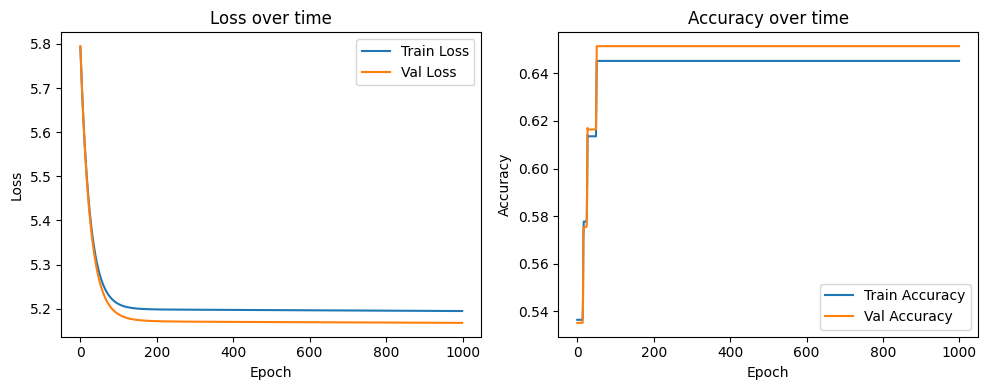

Epoch 0:
Train Loss 5.343602765165989
Train Acc 0.634375
Val Loss 5.341127000228294
Val Acc 0.63578125

Epoch 50:
Train Loss 4.501403301794894
Train Acc 0.7322916666666667
Val Loss 4.558258495143843
Val Acc 0.7303124999999999

Epoch 100:
Train Loss 3.983134588347744
Train Acc 0.7704166666666666
Val Loss 4.125291453027028
Val Acc 0.760625

Epoch 150:
Train Loss 3.501899836012798
Train Acc 0.80875
Val Loss 3.756015973630538
Val Acc 0.7909375

Epoch 200:
Train Loss 2.9821568789449167
Train Acc 0.8522916666666667
Val Loss 3.3737714119764415
Val Acc 0.82203125

Epoch 250:
Train Loss 2.5314243817513558
Train Acc 0.8827083333333333
Val Loss 3.0521151096933896
Val Acc 0.84421875

Epoch 300:
Train Loss 2.217472164518694
Train Acc 0.8958333333333334
Val Loss 2.844304928957668
Val Acc 0.85421875

Epoch 350:
Train Loss 2.0046992418089413
Train Acc 0.9025
Val Loss 2.724413454382443
Val Acc 0.85875

Epoch 400:
Train Loss 1.8457355067351031
Train Acc 0.9102083333333333
Val Loss 2.6418386969720418
Val

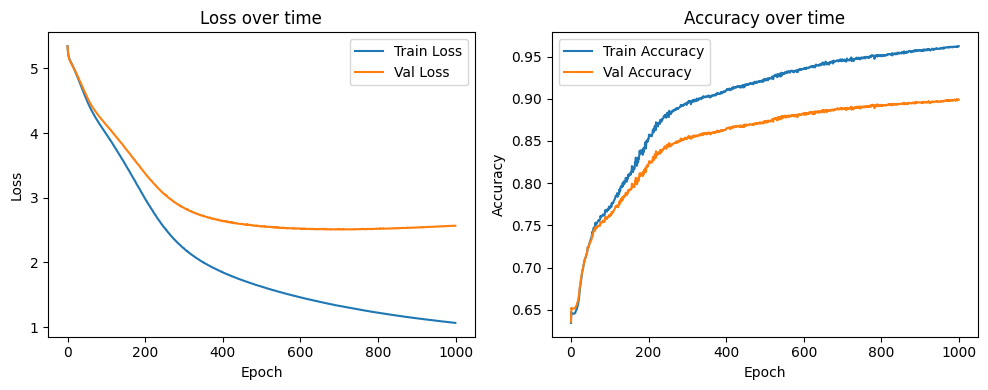

Epoch 0:
Train Loss 5.549684481837817
Train Acc 0.49583333333333335
Val Loss 5.551992049875694
Val Acc 0.49234374999999997

Epoch 50:
Train Loss 5.518709269892629
Train Acc 0.5360416666666667
Val Loss 5.520598345368983
Val Acc 0.531875

Epoch 100:
Train Loss 5.491452767597948
Train Acc 0.5670833333333334
Val Loss 5.492936741250096
Val Acc 0.56515625

Epoch 150:
Train Loss 5.467362372281288
Train Acc 0.5908333333333333
Val Loss 5.46845137371009
Val Acc 0.58921875

Epoch 200:
Train Loss 5.445957276716825
Train Acc 0.5972916666666667
Val Loss 5.446658976817664
Val Acc 0.59765625

Epoch 250:
Train Loss 5.426826948238648
Train Acc 0.60625
Val Loss 5.427147257071608
Val Acc 0.6071875

Epoch 300:
Train Loss 5.409625606467874
Train Acc 0.6089583333333333
Val Loss 5.409569242122228
Val Acc 0.6121875

Epoch 350:
Train Loss 5.394064676514236
Train Acc 0.6141666666666667
Val Loss 5.393635608404522
Val Acc 0.61765625

Epoch 400:
Train Loss 5.379904660620929
Train Acc 0.6164583333333333
Val Loss 5.3

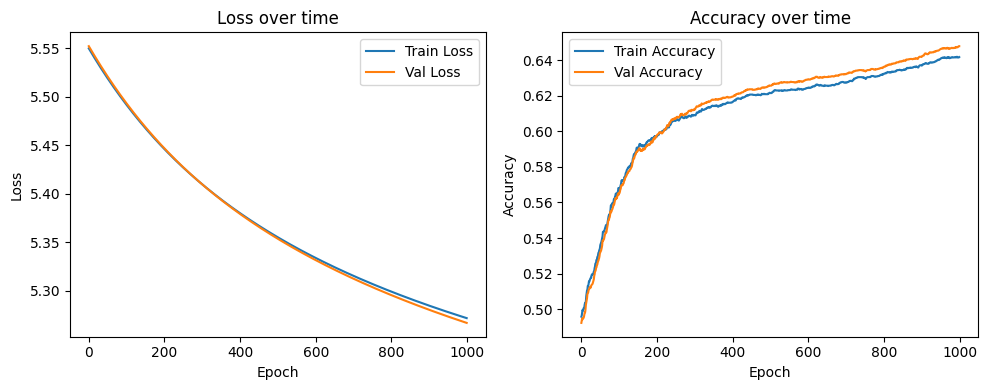

Epoch 0:
Train Loss 5.561414465537336
Train Acc 0.499375
Val Loss 5.5570612496658605
Val Acc 0.50671875

Epoch 50:
Train Loss 5.328102259578244
Train Acc 0.6170833333333333
Val Loss 5.317916617656328
Val Acc 0.6209374999999999

Epoch 100:
Train Loss 5.21488233430067
Train Acc 0.6460416666666666
Val Loss 5.2043493992686205
Val Acc 0.65125

Epoch 150:
Train Loss 5.142102810621695
Train Acc 0.6472916666666666
Val Loss 5.132366070883595
Val Acc 0.653125

Epoch 200:
Train Loss 5.0906190253425185
Train Acc 0.646875
Val Loss 5.082466382386291
Val Acc 0.65296875

Epoch 250:
Train Loss 5.049976737599859
Train Acc 0.6489583333333333
Val Loss 5.043911834610636
Val Acc 0.6546875

Epoch 300:
Train Loss 5.014718173106396
Train Acc 0.6552083333333334
Val Loss 5.011057448329513
Val Acc 0.6603125000000001

Epoch 350:
Train Loss 4.982240245617004
Train Acc 0.6610416666666667
Val Loss 4.981194107173874
Val Acc 0.66578125

Epoch 400:
Train Loss 4.951317647838963
Train Acc 0.6654166666666667
Val Loss 4.952

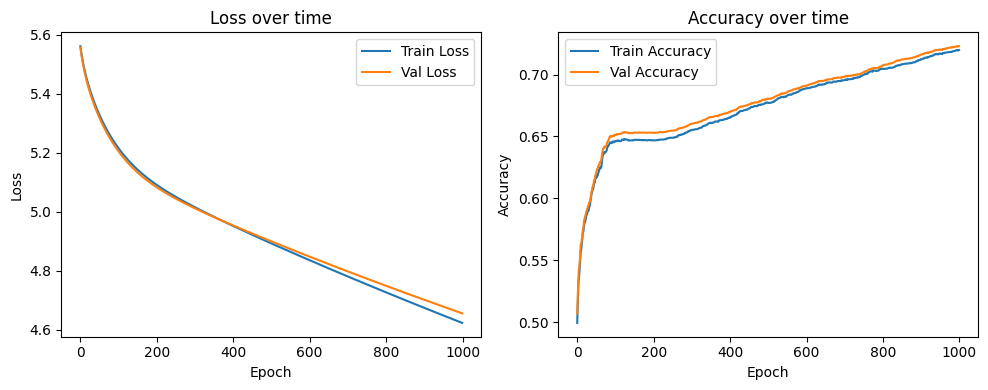

Epoch 0:
Train Loss 5.419204655648506
Train Acc 0.610625
Val Loss 5.4164529326291255
Val Acc 0.614375

Epoch 50:
Train Loss 4.152494121716024
Train Acc 0.7733333333333333
Val Loss 4.239128484824413
Val Acc 0.77171875

Epoch 100:
Train Loss 3.393964667678286
Train Acc 0.8014583333333334
Val Loss 3.6137900216196757
Val Acc 0.79296875

Epoch 150:
Train Loss 2.7167277366171048
Train Acc 0.8541666666666666
Val Loss 3.102198741020708
Val Acc 0.83265625

Epoch 200:
Train Loss 1.9572301976388462
Train Acc 0.9422916666666666
Val Loss 2.5489069808475135
Val Acc 0.89890625

Epoch 250:
Train Loss 1.2940474748822404
Train Acc 0.9925
Val Loss 2.079118962136615
Val Acc 0.936875

Epoch 300:
Train Loss 0.8452545756383743
Train Acc 0.9989583333333333
Val Loss 1.7821444350092395
Val Acc 0.9409375

Epoch 350:
Train Loss 0.5804461181476475
Train Acc 0.999375
Val Loss 1.6329992761009533
Val Acc 0.94109375

Epoch 400:
Train Loss 0.42456551727479624
Train Acc 1.0
Val Loss 1.5635571566239417
Val Acc 0.94140625

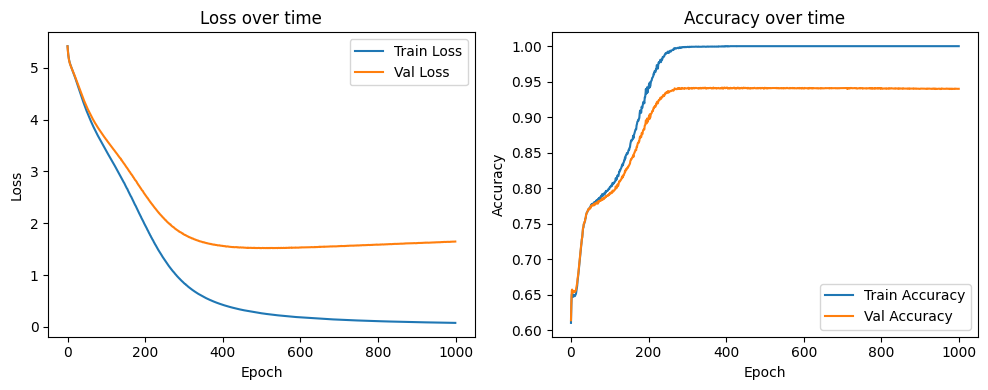

Epoch 0:
Train Loss 5.53627935144247
Train Acc 0.5141666666666667
Val Loss 5.537450789768825
Val Acc 0.5165625

Epoch 50:
Train Loss 5.511295053992215
Train Acc 0.5391666666666667
Val Loss 5.511948571116903
Val Acc 0.5432812499999999

Epoch 100:
Train Loss 5.488363406983703
Train Acc 0.5660416666666667
Val Loss 5.488515582443564
Val Acc 0.5675

Epoch 150:
Train Loss 5.467238891444516
Train Acc 0.5802083333333333
Val Loss 5.466904179439298
Val Acc 0.58203125

Epoch 200:
Train Loss 5.44771251616608
Train Acc 0.5954166666666667
Val Loss 5.4469037184020275
Val Acc 0.5959375

Epoch 250:
Train Loss 5.429606033142651
Train Acc 0.608125
Val Loss 5.428334688952207
Val Acc 0.6090625000000001

Epoch 300:
Train Loss 5.412767091000027
Train Acc 0.6133333333333333
Val Loss 5.411043796506936
Val Acc 0.61625

Epoch 350:
Train Loss 5.3970651505215805
Train Acc 0.620625
Val Loss 5.394899817451518
Val Acc 0.62375

Epoch 400:
Train Loss 5.382388032966505
Train Acc 0.6277083333333333
Val Loss 5.37979009653

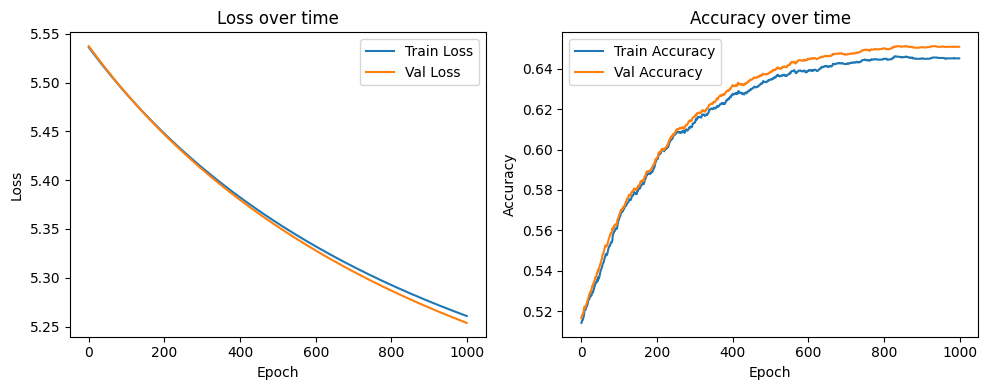

Epoch 0:
Train Loss 5.567274543440913
Train Acc 0.47291666666666665
Val Loss 5.564541190091231
Val Acc 0.48015624999999995

Epoch 50:
Train Loss 5.294262819997503
Train Acc 0.6458333333333333
Val Loss 5.287355443759902
Val Acc 0.6496875

Epoch 100:
Train Loss 5.180566484442789
Train Acc 0.6491666666666667
Val Loss 5.170685154392369
Val Acc 0.65484375

Epoch 150:
Train Loss 5.120869487333115
Train Acc 0.646875
Val Loss 5.110318623339953
Val Acc 0.6526562499999999

Epoch 200:
Train Loss 5.082555257226014
Train Acc 0.6472916666666666
Val Loss 5.073168115602394
Val Acc 0.65296875

Epoch 250:
Train Loss 5.051641896353865
Train Acc 0.65
Val Loss 5.044418703190612
Val Acc 0.65515625

Epoch 300:
Train Loss 5.023191256884564
Train Acc 0.6522916666666667
Val Loss 5.018675159261086
Val Acc 0.65765625

Epoch 350:
Train Loss 4.995457076743874
Train Acc 0.6564583333333334
Val Loss 4.993987425410536
Val Acc 0.66171875

Epoch 400:
Train Loss 4.967785823845862
Train Acc 0.6633333333333333
Val Loss 4.96

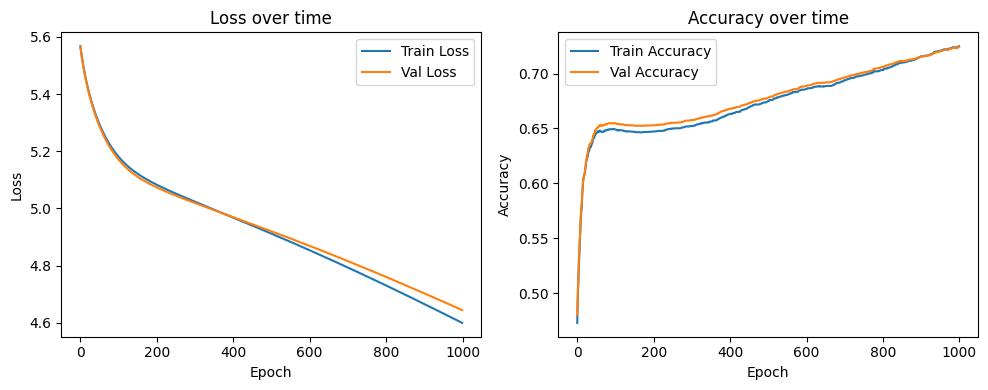

Epoch 0:
Train Loss 5.327350999594446
Train Acc 0.6445833333333333
Val Loss 5.315327498146375
Val Acc 0.65015625

Epoch 50:
Train Loss 4.215435859581886
Train Acc 0.7716666666666667
Val Loss 4.314222168219025
Val Acc 0.76078125

Epoch 100:
Train Loss 2.733718564235656
Train Acc 0.8735416666666667
Val Loss 3.194459985523151
Val Acc 0.838125

Epoch 150:
Train Loss 1.296103961327059
Train Acc 0.9658333333333333
Val Loss 2.257696271112409
Val Acc 0.91015625

Epoch 200:
Train Loss 0.5934144069043935
Train Acc 0.996875
Val Loss 1.9141437787651723
Val Acc 0.9325

Epoch 250:
Train Loss 0.3209288826910143
Train Acc 0.9995833333333334
Val Loss 1.9132338078074924
Val Acc 0.93515625

Epoch 300:
Train Loss 0.20194903627093155
Train Acc 1.0
Val Loss 2.0088092806913576
Val Acc 0.933125

Epoch 350:
Train Loss 0.14569097094393973
Train Acc 1.0
Val Loss 2.1317937798344806
Val Acc 0.93265625

Epoch 400:
Train Loss 0.11398570420900557
Train Acc 1.0
Val Loss 2.2263354418588612
Val Acc 0.9315625

Epoch 450:

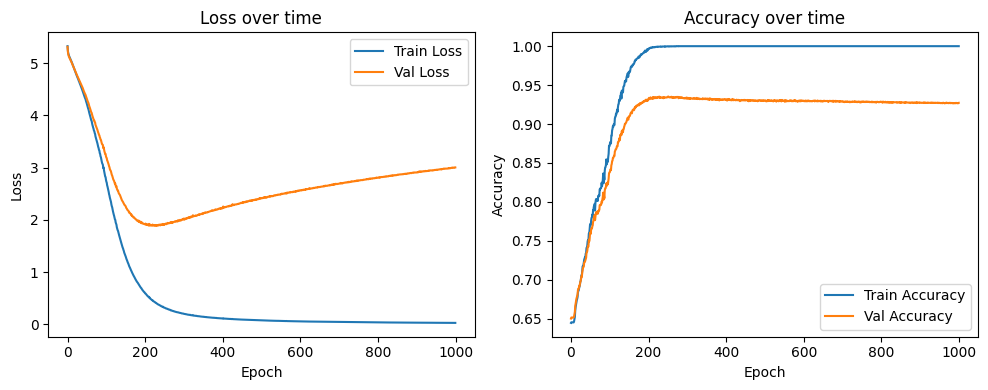

Epoch 0:
Train Loss 5.547390642562
Train Acc 0.5035416666666667
Val Loss 5.545737420208504
Val Acc 0.5042187499999999

Epoch 50:
Train Loss 5.510689275034652
Train Acc 0.5447916666666667
Val Loss 5.507520325181954
Val Acc 0.5453125

Epoch 100:
Train Loss 5.479717407265037
Train Acc 0.5662499999999999
Val Loss 5.475206438526018
Val Acc 0.5696875

Epoch 150:
Train Loss 5.453155856757237
Train Acc 0.584375
Val Loss 5.447455806782201
Val Acc 0.58875

Epoch 200:
Train Loss 5.430009534629271
Train Acc 0.5979166666666667
Val Loss 5.423253077341587
Val Acc 0.6034375000000001

Epoch 250:
Train Loss 5.40953813316963
Train Acc 0.6135416666666667
Val Loss 5.401839597199481
Val Acc 0.61828125

Epoch 300:
Train Loss 5.391193370873651
Train Acc 0.6179166666666667
Val Loss 5.382651176230041
Val Acc 0.6231249999999999

Epoch 350:
Train Loss 5.374568455810402
Train Acc 0.6229166666666667
Val Loss 5.365267569022859
Val Acc 0.6275

Epoch 400:
Train Loss 5.35935976279772
Train Acc 0.6275
Val Loss 5.3493739

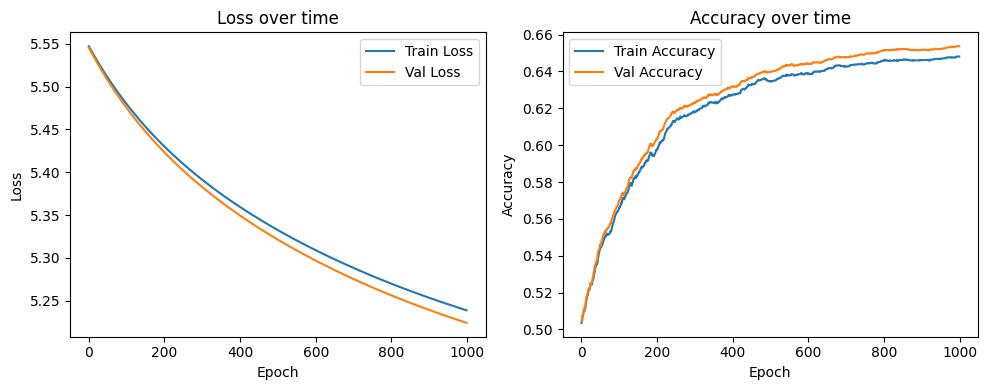

Epoch 0:
Train Loss 5.57564917701678
Train Acc 0.4816666666666667
Val Loss 5.578203635328818
Val Acc 0.47421875

Epoch 50:
Train Loss 5.290384809752568
Train Acc 0.6445833333333333
Val Loss 5.28356270880473
Val Acc 0.650625

Epoch 100:
Train Loss 5.196327000440466
Train Acc 0.6452083333333334
Val Loss 5.182834335107737
Val Acc 0.65140625

Epoch 150:
Train Loss 5.161087264670027
Train Acc 0.6452083333333334
Val Loss 5.144831549022133
Val Acc 0.65140625

Epoch 200:
Train Loss 5.140683779423975
Train Acc 0.6452083333333334
Val Loss 5.124333855520079
Val Acc 0.65140625

Epoch 250:
Train Loss 5.122232574230781
Train Acc 0.6452083333333334
Val Loss 5.10713023250913
Val Acc 0.65140625

Epoch 300:
Train Loss 5.1025472520376765
Train Acc 0.6452083333333334
Val Loss 5.089449708913221
Val Acc 0.65140625

Epoch 350:
Train Loss 5.080621186730319
Train Acc 0.6452083333333334
Val Loss 5.070024716388365
Val Acc 0.65140625

Epoch 400:
Train Loss 5.055951526139197
Train Acc 0.645625
Val Loss 5.048216411

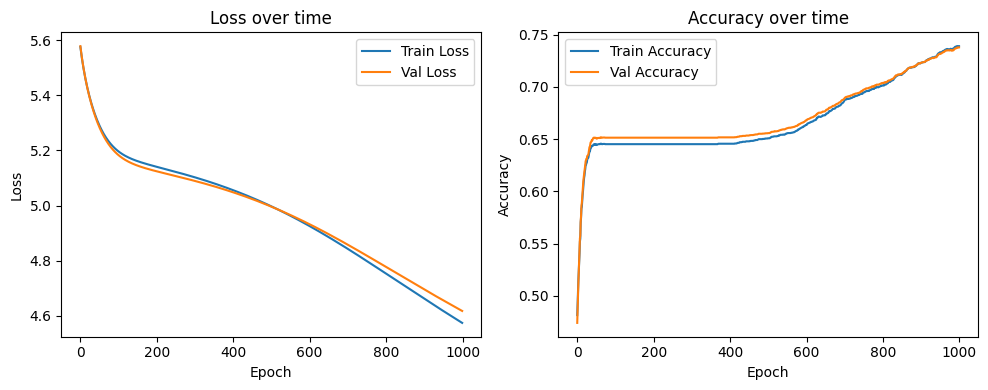

Epoch 0:
Train Loss 5.392623265358405
Train Acc 0.635
Val Loss 5.386229757086059
Val Acc 0.63984375

Epoch 50:
Train Loss 4.4422338470222495
Train Acc 0.7441666666666666
Val Loss 4.501394934902449
Val Acc 0.7424999999999999

Epoch 100:
Train Loss 3.991191793417406
Train Acc 0.7735416666666667
Val Loss 4.13671384727741
Val Acc 0.765

Epoch 150:
Train Loss 3.558389468772557
Train Acc 0.8145833333333333
Val Loss 3.806311547275259
Val Acc 0.79984375

Epoch 200:
Train Loss 3.0457915482657865
Train Acc 0.8564583333333333
Val Loss 3.4204002986978104
Val Acc 0.83

Epoch 250:
Train Loss 2.600812604721149
Train Acc 0.88125
Val Loss 3.100068189157388
Val Acc 0.84625

Epoch 300:
Train Loss 2.2653066004173588
Train Acc 0.899375
Val Loss 2.870054971282808
Val Acc 0.86046875

Epoch 350:
Train Loss 2.0171343915709485
Train Acc 0.9085416666666667
Val Loss 2.7209816811942176
Val Acc 0.8674999999999999

Epoch 400:
Train Loss 1.8248841066150794
Train Acc 0.919375
Val Loss 2.6180809429374223
Val Acc 0.8751

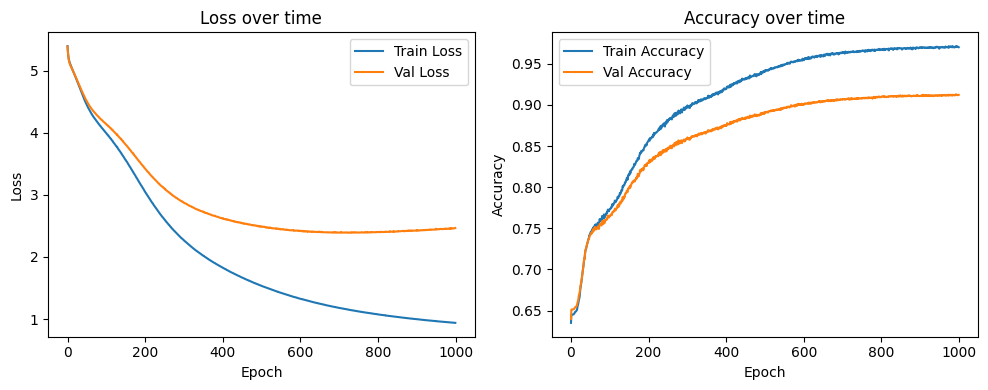

Epoch 0:
Train Loss 5.544874757216573
Train Acc 0.4989583333333333
Val Loss 5.543294065591767
Val Acc 0.50046875

Epoch 50:
Train Loss 5.5305225860335545
Train Acc 0.5408333333333333
Val Loss 5.5284236928784605
Val Acc 0.54609375

Epoch 100:
Train Loss 5.516526451442762
Train Acc 0.5685416666666667
Val Loss 5.513944370137494
Val Acc 0.57328125

Epoch 150:
Train Loss 5.5024294958293885
Train Acc 0.5862499999999999
Val Loss 5.499363102165919
Val Acc 0.593125

Epoch 200:
Train Loss 5.487451047554669
Train Acc 0.595
Val Loss 5.483973411879909
Val Acc 0.60484375

Epoch 250:
Train Loss 5.472021669019328
Train Acc 0.6072916666666667
Val Loss 5.468231323447131
Val Acc 0.61546875

Epoch 300:
Train Loss 5.456505033480449
Train Acc 0.6158333333333333
Val Loss 5.452371358082434
Val Acc 0.62234375

Epoch 350:
Train Loss 5.44148486339391
Train Acc 0.620625
Val Loss 5.437030624974002
Val Acc 0.6275

Epoch 400:
Train Loss 5.426969911910663
Train Acc 0.6264583333333333
Val Loss 5.422286144845291
Val Ac

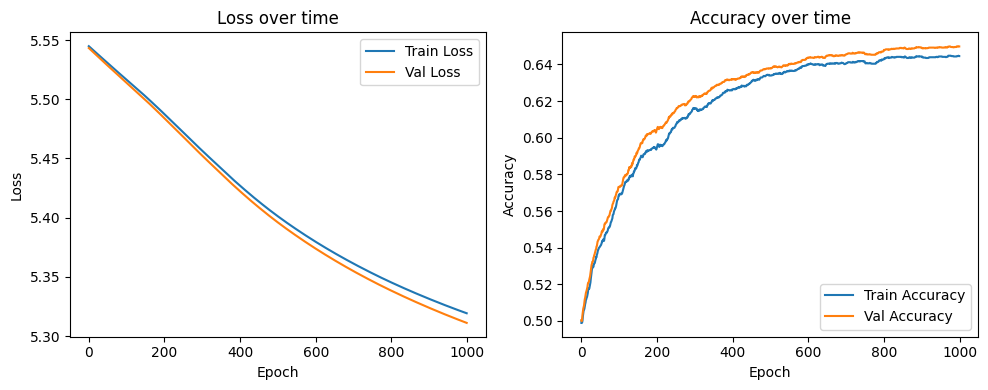

Epoch 0:
Train Loss 5.537600491841965
Train Acc 0.49854166666666666
Val Loss 5.537958095353495
Val Acc 0.494375

Epoch 50:
Train Loss 5.3839832934346195
Train Acc 0.64375
Val Loss 5.37905182839409
Val Acc 0.6496875

Epoch 100:
Train Loss 5.291545563347055
Train Acc 0.6452083333333334
Val Loss 5.283031400822697
Val Acc 0.65140625

Epoch 150:
Train Loss 5.232301547364426
Train Acc 0.6452083333333334
Val Loss 5.22107993122167
Val Acc 0.65140625

Epoch 200:
Train Loss 5.1937387764715295
Train Acc 0.6452083333333334
Val Loss 5.180568441830684
Val Acc 0.65140625

Epoch 250:
Train Loss 5.167346355928836
Train Acc 0.6452083333333334
Val Loss 5.15291132954567
Val Acc 0.65140625

Epoch 300:
Train Loss 5.146895117965672
Train Acc 0.6452083333333334
Val Loss 5.131945903673097
Val Acc 0.65140625

Epoch 350:
Train Loss 5.129340328953565
Train Acc 0.6460416666666666
Val Loss 5.114459614214453
Val Acc 0.6520312500000001

Epoch 400:
Train Loss 5.113008588377147
Train Acc 0.6464583333333334
Val Loss 5.0

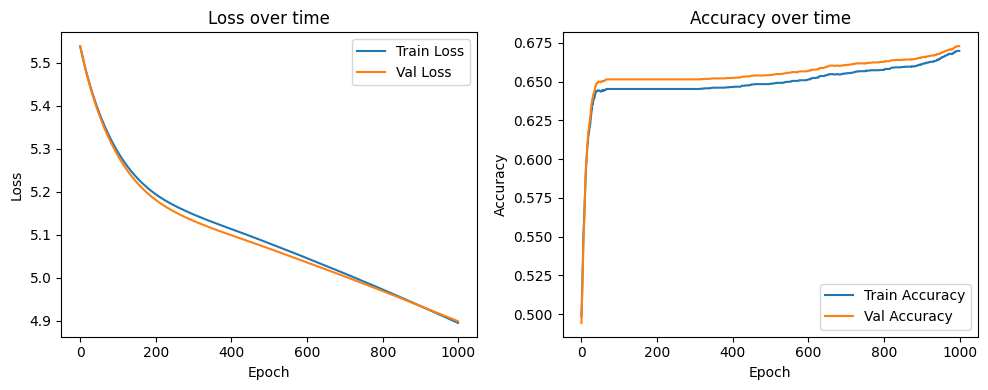

Epoch 0:
Train Loss 5.363821234311261
Train Acc 0.638125
Val Loss 5.358068099874122
Val Acc 0.6415625

Epoch 50:
Train Loss 4.270619072990432
Train Acc 0.7641666666666667
Val Loss 4.358067577032432
Val Acc 0.7640625

Epoch 100:
Train Loss 3.576713938554129
Train Acc 0.799375
Val Loss 3.7952383751248084
Val Acc 0.790625

Epoch 150:
Train Loss 2.776603881637809
Train Acc 0.8608333333333333
Val Loss 3.1682432986913773
Val Acc 0.83671875

Epoch 200:
Train Loss 1.9406740208495066
Train Acc 0.9385416666666667
Val Loss 2.55455162430825
Val Acc 0.8953125

Epoch 250:
Train Loss 1.236718037865722
Train Acc 0.9889583333333334
Val Loss 2.055891146568324
Val Acc 0.9340625

Epoch 300:
Train Loss 0.7779735889941524
Train Acc 0.99875
Val Loss 1.7649787213788068
Val Acc 0.94109375

Epoch 350:
Train Loss 0.5132045918858199
Train Acc 0.9997916666666666
Val Loss 1.6258644175060797
Val Acc 0.94078125

Epoch 400:
Train Loss 0.3598536284416524
Train Acc 1.0
Val Loss 1.562106191887205
Val Acc 0.94046875

Epoc

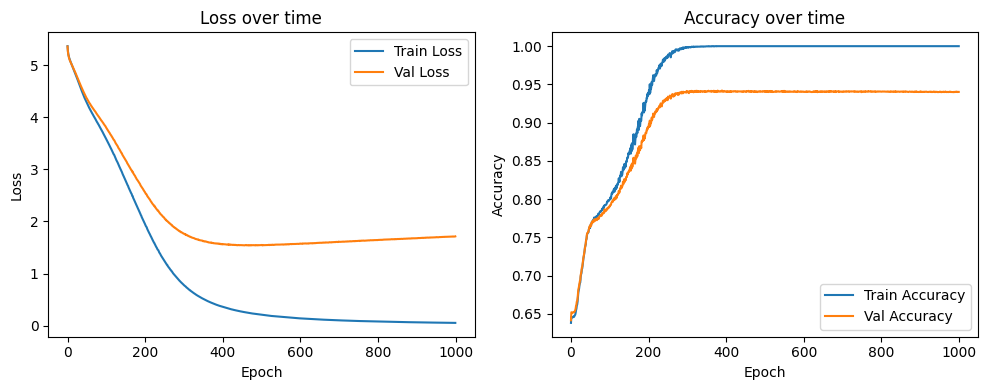

Epoch 0:
Train Loss 5.576242307995361
Train Acc 0.4766666666666667
Val Loss 5.57820052956767
Val Acc 0.47234374999999995

Epoch 50:
Train Loss 5.559871344178421
Train Acc 0.505625
Val Loss 5.5612521816288565
Val Acc 0.50265625

Epoch 100:
Train Loss 5.54617797067395
Train Acc 0.5377083333333333
Val Loss 5.547127323562803
Val Acc 0.53640625

Epoch 150:
Train Loss 5.534163836617127
Train Acc 0.5560416666666667
Val Loss 5.534724728963969
Val Acc 0.5515625

Epoch 200:
Train Loss 5.523068064634911
Train Acc 0.5733333333333333
Val Loss 5.523286972939406
Val Acc 0.5696875

Epoch 250:
Train Loss 5.512830798805412
Train Acc 0.5879166666666666
Val Loss 5.512727507304744
Val Acc 0.5857812499999999

Epoch 300:
Train Loss 5.503252580930095
Train Acc 0.6002083333333333
Val Loss 5.502856001322455
Val Acc 0.6009375

Epoch 350:
Train Loss 5.494139642821791
Train Acc 0.6095833333333334
Val Loss 5.4934749560041105
Val Acc 0.61265625

Epoch 400:
Train Loss 5.485373431129626
Train Acc 0.6168750000000001
Va

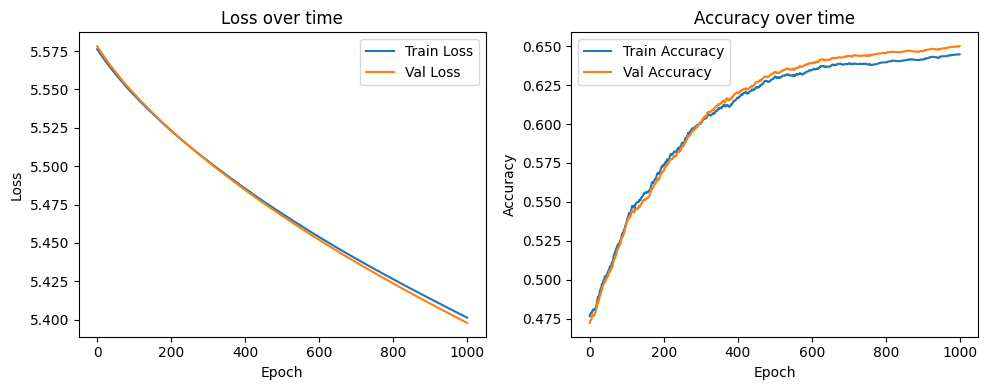

Epoch 0:
Train Loss 5.560885363444456
Train Acc 0.484375
Val Loss 5.558974523293566
Val Acc 0.48734374999999996

Epoch 50:
Train Loss 5.3766035178606675
Train Acc 0.6322916666666667
Val Loss 5.371747806042681
Val Acc 0.6346875000000001

Epoch 100:
Train Loss 5.282633397779245
Train Acc 0.64625
Val Loss 5.273672841360422
Val Acc 0.64953125

Epoch 150:
Train Loss 5.224517129914774
Train Acc 0.6454166666666667
Val Loss 5.2126024417385315
Val Acc 0.65140625

Epoch 200:
Train Loss 5.186523663812662
Train Acc 0.6454166666666667
Val Loss 5.17266623421777
Val Acc 0.65171875

Epoch 250:
Train Loss 5.159624251640077
Train Acc 0.6452083333333334
Val Loss 5.144739698422854
Val Acc 0.6515625

Epoch 300:
Train Loss 5.138244504176919
Train Acc 0.6452083333333334
Val Loss 5.12328872803646
Val Acc 0.6515625

Epoch 350:
Train Loss 5.118528856655088
Train Acc 0.6452083333333334
Val Loss 5.104258846852997
Val Acc 0.6515625

Epoch 400:
Train Loss 5.098849881060071
Train Acc 0.6452083333333334
Val Loss 5.08

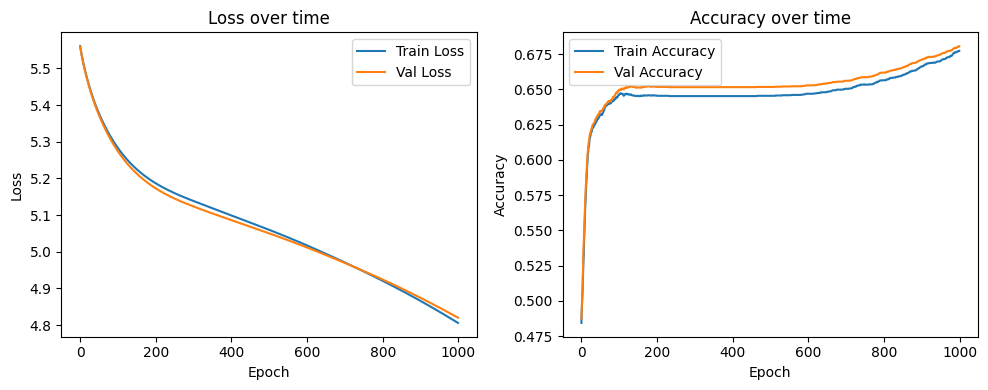

Epoch 0:
Train Loss 5.453558628758551
Train Acc 0.6383333333333333
Val Loss 5.449529770883287
Val Acc 0.645625

Epoch 50:
Train Loss 4.514425122064606
Train Acc 0.72125
Val Loss 4.564296239597365
Val Acc 0.7228125000000001

Epoch 100:
Train Loss 3.231526145706847
Train Acc 0.8295833333333333
Val Loss 3.56602000284568
Val Acc 0.80859375

Epoch 150:
Train Loss 1.6277964696475233
Train Acc 0.9341666666666667
Val Loss 2.508236526045043
Val Acc 0.885

Epoch 200:
Train Loss 0.5134705347964887
Train Acc 0.9933333333333333
Val Loss 2.003459826399892
Val Acc 0.92890625

Epoch 250:
Train Loss 0.15366763053075155
Train Acc 1.0
Val Loss 2.054540380468437
Val Acc 0.93609375

Epoch 300:
Train Loss 0.06897937023270193
Train Acc 1.0
Val Loss 2.2329377347750574
Val Acc 0.93609375

Epoch 350:
Train Loss 0.04102043219778708
Train Acc 1.0
Val Loss 2.3762362010918747
Val Acc 0.93609375

Epoch 400:
Train Loss 0.027966313853045353
Train Acc 1.0
Val Loss 2.485653174921858
Val Acc 0.935625

Epoch 450:
Train Lo

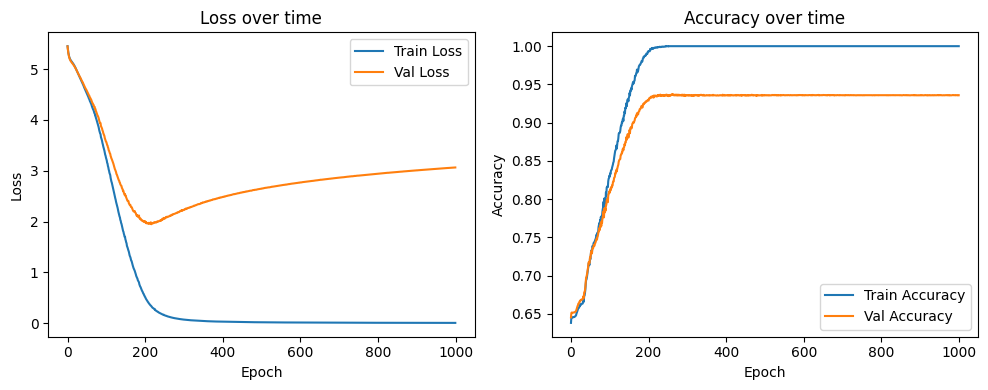

Epoch 0:
Train Loss 5.526208013913935
Train Acc 0.5554166666666667
Val Loss 5.524217434992196
Val Acc 0.5628124999999999

Epoch 50:
Train Loss 5.509746051692423
Train Acc 0.576875
Val Loss 5.506593927404006
Val Acc 0.5815625

Epoch 100:
Train Loss 5.493305291800263
Train Acc 0.58375
Val Loss 5.489055823683593
Val Acc 0.58828125

Epoch 150:
Train Loss 5.476352594561612
Train Acc 0.5872916666666667
Val Loss 5.471142693640383
Val Acc 0.59109375

Epoch 200:
Train Loss 5.459299662807059
Train Acc 0.59375
Val Loss 5.452974876636449
Val Acc 0.5984375

Epoch 250:
Train Loss 5.442752198916498
Train Acc 0.59875
Val Loss 5.435256358609998
Val Acc 0.6059375

Epoch 300:
Train Loss 5.426973719726263
Train Acc 0.6033333333333333
Val Loss 5.418365019454172
Val Acc 0.6103125

Epoch 350:
Train Loss 5.412128029005322
Train Acc 0.6110416666666667
Val Loss 5.40248298025955
Val Acc 0.6184375

Epoch 400:
Train Loss 5.39839444937295
Train Acc 0.619375
Val Loss 5.387742118983149
Val Acc 0.6240625

Epoch 450:
T

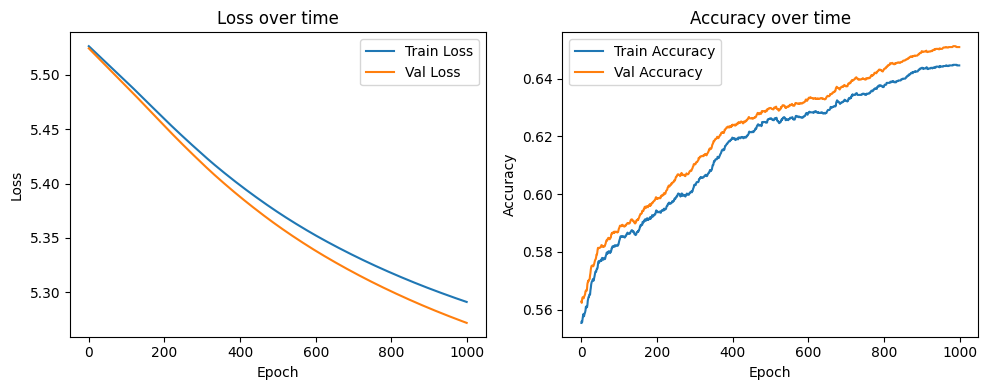

Epoch 0:
Train Loss 5.526847263477175
Train Acc 0.5349999999999999
Val Loss 5.5269989824368375
Val Acc 0.5331250000000001

Epoch 50:
Train Loss 5.301106218978842
Train Acc 0.6427083333333333
Val Loss 5.287083051867489
Val Acc 0.6487499999999999

Epoch 100:
Train Loss 5.208992097210342
Train Acc 0.6452083333333334
Val Loss 5.1896585988674335
Val Acc 0.65140625

Epoch 150:
Train Loss 5.16555888584927
Train Acc 0.6452083333333334
Val Loss 5.146913333490334
Val Acc 0.65140625

Epoch 200:
Train Loss 5.137881839268792
Train Acc 0.6452083333333334
Val Loss 5.121406787541144
Val Acc 0.65140625

Epoch 250:
Train Loss 5.114937128869445
Train Acc 0.6452083333333334
Val Loss 5.101056984428169
Val Acc 0.65140625

Epoch 300:
Train Loss 5.09217569031635
Train Acc 0.6460416666666666
Val Loss 5.081219627980424
Val Acc 0.65234375

Epoch 350:
Train Loss 5.069363533441126
Train Acc 0.6477083333333333
Val Loss 5.061392716114323
Val Acc 0.65359375

Epoch 400:
Train Loss 5.046016759171919
Train Acc 0.6525000

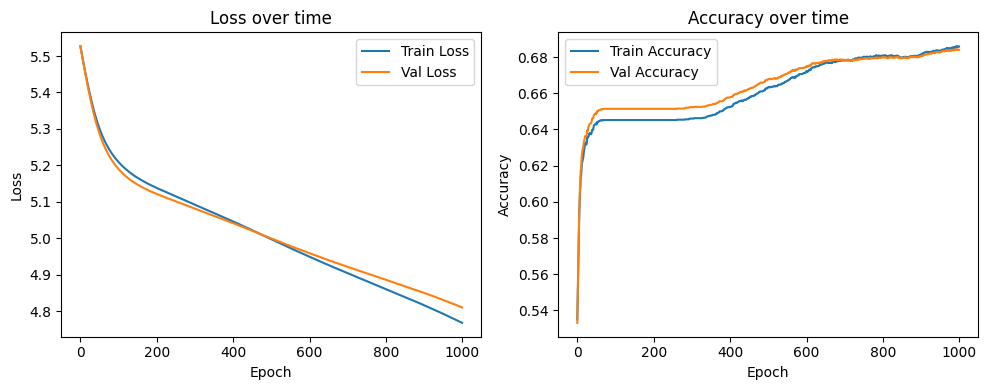

Epoch 0:
Train Loss 5.434344578704938
Train Acc 0.5614583333333334
Val Loss 5.432791722532464
Val Acc 0.561875

Epoch 50:
Train Loss 5.151976784375171
Train Acc 0.6452083333333334
Val Loss 5.129731364780579
Val Acc 0.65140625

Epoch 100:
Train Loss 5.074833804409637
Train Acc 0.6460416666666666
Val Loss 5.062256655950724
Val Acc 0.6525000000000001

Epoch 150:
Train Loss 4.953782574546213
Train Acc 0.6622916666666667
Val Loss 4.9570499876901675
Val Acc 0.6684375

Epoch 200:
Train Loss 4.806031716242891
Train Acc 0.6893750000000001
Val Loss 4.829407191384948
Val Acc 0.69265625

Epoch 250:
Train Loss 4.6570968137179305
Train Acc 0.7147916666666667
Val Loss 4.701993114352412
Val Acc 0.71703125

Epoch 300:
Train Loss 4.517376966954756
Train Acc 0.7377083333333334
Val Loss 4.5835810855374906
Val Acc 0.7353125

Epoch 350:
Train Loss 4.385358876689429
Train Acc 0.7464583333333333
Val Loss 4.471651664378462
Val Acc 0.74328125

Epoch 400:
Train Loss 4.26072899970068
Train Acc 0.754375
Val Loss 4

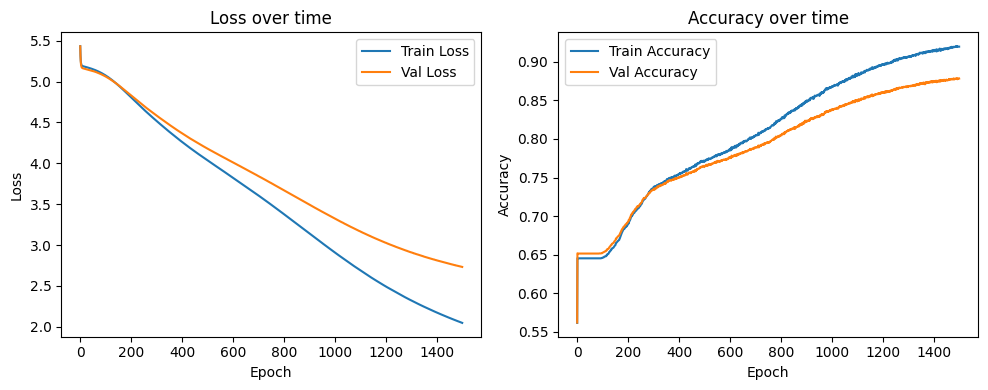

Epoch 0:
Train Loss 5.582771466279569
Train Acc 0.5052083333333333
Val Loss 5.577987429058441
Val Acc 0.50484375

Epoch 50:
Train Loss 5.56115131922777
Train Acc 0.5052083333333333
Val Loss 5.55574402153565
Val Acc 0.505

Epoch 100:
Train Loss 5.540773979157057
Train Acc 0.505
Val Loss 5.534760873470575
Val Acc 0.505

Epoch 150:
Train Loss 5.521565181894286
Train Acc 0.5070833333333333
Val Loss 5.514963127914252
Val Acc 0.5076562499999999

Epoch 200:
Train Loss 5.5034553733857345
Train Acc 0.5135416666666667
Val Loss 5.496280670843436
Val Acc 0.5146875

Epoch 250:
Train Loss 5.486379384918965
Train Acc 0.5233333333333333
Val Loss 5.478647803659149
Val Acc 0.5278125

Epoch 300:
Train Loss 5.470276132813402
Train Acc 0.5414583333333334
Val Loss 5.46200294040221
Val Acc 0.5475

Epoch 350:
Train Loss 5.455088340642771
Train Acc 0.5585416666666667
Val Loss 5.446288327727957
Val Acc 0.5609375

Epoch 400:
Train Loss 5.440762282195677
Train Acc 0.5660416666666667
Val Loss 5.431449785826809
Val

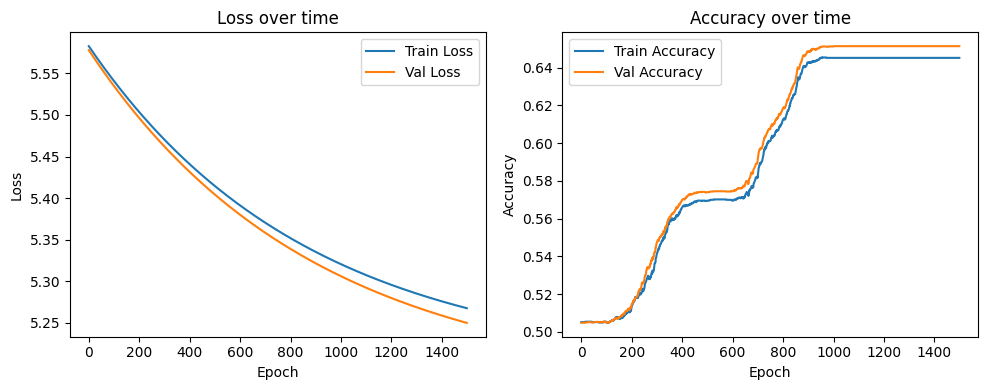

Epoch 0:
Train Loss 5.691299049303539
Train Acc 0.5070833333333333
Val Loss 5.691147755110221
Val Acc 0.5120312499999999

Epoch 50:
Train Loss 5.361675918444837
Train Acc 0.6110416666666667
Val Loss 5.351006287772306
Val Acc 0.6151562500000001

Epoch 100:
Train Loss 5.252319358823868
Train Acc 0.6452083333333334
Val Loss 5.235294765135016
Val Acc 0.65140625

Epoch 150:
Train Loss 5.214432838650516
Train Acc 0.6452083333333334
Val Loss 5.19356305310256
Val Acc 0.65140625

Epoch 200:
Train Loss 5.200342269527851
Train Acc 0.6452083333333334
Val Loss 5.177191966500393
Val Acc 0.65140625

Epoch 250:
Train Loss 5.194392806498803
Train Acc 0.6452083333333334
Val Loss 5.169914206364138
Val Acc 0.65140625

Epoch 300:
Train Loss 5.19121281100182
Train Acc 0.6452083333333334
Val Loss 5.166005356480232
Val Acc 0.65140625

Epoch 350:
Train Loss 5.188998588864259
Train Acc 0.6452083333333334
Val Loss 5.163432668136114
Val Acc 0.65140625

Epoch 400:
Train Loss 5.187101604331717
Train Acc 0.645208333

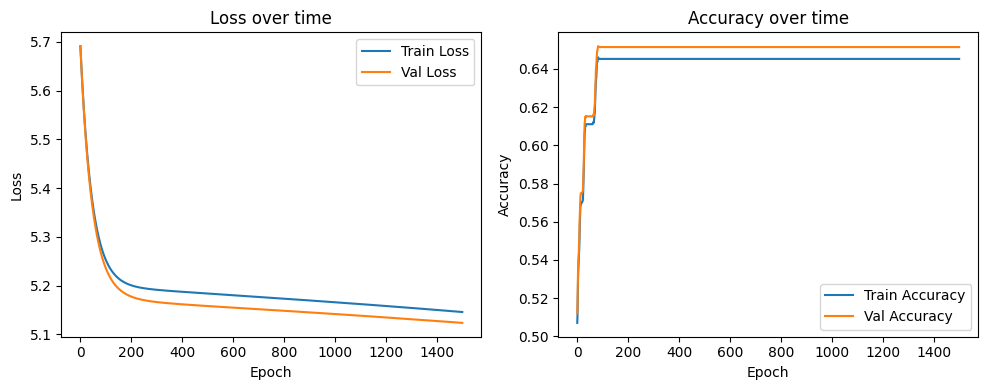

Epoch 0:
Train Loss 5.466162390314679
Train Acc 0.5295833333333333
Val Loss 5.450447112466375
Val Acc 0.53390625

Epoch 50:
Train Loss 5.134221229365358
Train Acc 0.6452083333333334
Val Loss 5.1151499329284915
Val Acc 0.65140625

Epoch 100:
Train Loss 5.028046335140831
Train Acc 0.6452083333333334
Val Loss 5.021472208404599
Val Acc 0.65140625

Epoch 150:
Train Loss 4.8460080632479166
Train Acc 0.6708333333333334
Val Loss 4.859820034645086
Val Acc 0.67484375

Epoch 200:
Train Loss 4.600109244402504
Train Acc 0.7222916666666667
Val Loss 4.6409196388910265
Val Acc 0.7229687499999999

Epoch 250:
Train Loss 4.348349271548167
Train Acc 0.7581249999999999
Val Loss 4.4172791736056105
Val Acc 0.7581249999999999

Epoch 300:
Train Loss 4.129178610237902
Train Acc 0.7670833333333333
Val Loss 4.225494019801542
Val Acc 0.7675

Epoch 350:
Train Loss 3.9374572833094788
Train Acc 0.7727083333333333
Val Loss 4.061534553140356
Val Acc 0.7715625

Epoch 400:
Train Loss 3.758217367932648
Train Acc 0.7795833

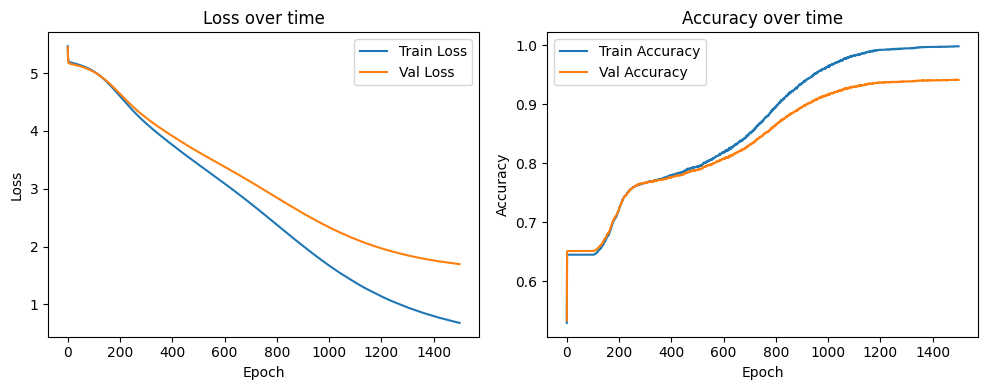

Epoch 0:
Train Loss 6.075213973022263
Train Acc 0.46020833333333333
Val Loss 6.070376122995781
Val Acc 0.45921875

Epoch 50:
Train Loss 6.000747946768508
Train Acc 0.46020833333333333
Val Loss 5.994935995526203
Val Acc 0.45921875

Epoch 100:
Train Loss 5.932857526144112
Train Acc 0.46020833333333333
Val Loss 5.926116541181164
Val Acc 0.45921875

Epoch 150:
Train Loss 5.870939477081837
Train Acc 0.46020833333333333
Val Loss 5.863312001615673
Val Acc 0.45921875

Epoch 200:
Train Loss 5.814446786595502
Train Acc 0.46020833333333333
Val Loss 5.805973041425132
Val Acc 0.45921875

Epoch 250:
Train Loss 5.762883677830145
Train Acc 0.46020833333333333
Val Loss 5.753601740498759
Val Acc 0.45921875

Epoch 300:
Train Loss 5.715800958269677
Train Acc 0.46229166666666666
Val Loss 5.705746922481726
Val Acc 0.46140625

Epoch 350:
Train Loss 5.67279171170695
Train Acc 0.46520833333333333
Val Loss 5.661999829592332
Val Acc 0.46687500000000004

Epoch 400:
Train Loss 5.633487332888444
Train Acc 0.4797916

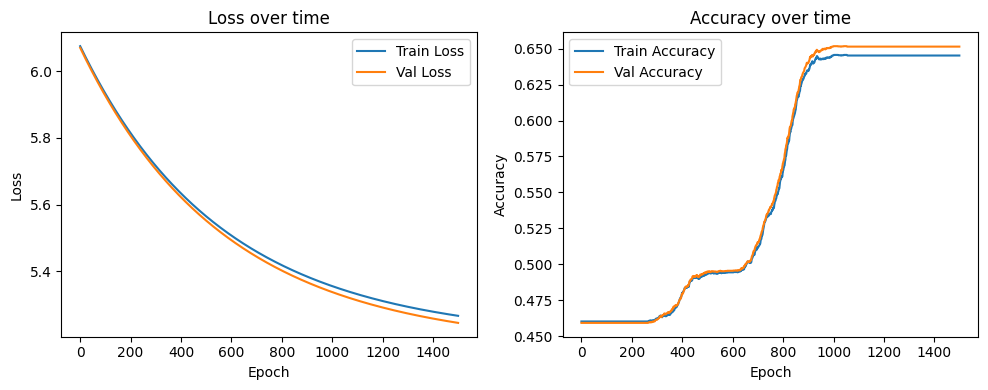

Epoch 0:
Train Loss 5.327093101090726
Train Acc 0.604375
Val Loss 5.301293065682372
Val Acc 0.61078125

Epoch 50:
Train Loss 5.2199194155696675
Train Acc 0.6452083333333334
Val Loss 5.193752193608618
Val Acc 0.65140625

Epoch 100:
Train Loss 5.198141913038161
Train Acc 0.6452083333333334
Val Loss 5.171840501983302
Val Acc 0.65140625

Epoch 150:
Train Loss 5.19226693490453
Train Acc 0.6452083333333334
Val Loss 5.165987318544738
Val Acc 0.65140625

Epoch 200:
Train Loss 5.189499777870542
Train Acc 0.6452083333333334
Val Loss 5.163337970586254
Val Acc 0.65140625

Epoch 250:
Train Loss 5.187351825576082
Train Acc 0.6452083333333334
Val Loss 5.1613520550502425
Val Acc 0.65140625

Epoch 300:
Train Loss 5.185340171909666
Train Acc 0.6452083333333334
Val Loss 5.159555253103878
Val Acc 0.65140625

Epoch 350:
Train Loss 5.1833518526265365
Train Acc 0.6452083333333334
Val Loss 5.1577798340139225
Val Acc 0.65140625

Epoch 400:
Train Loss 5.1813619930733585
Train Acc 0.6452083333333334
Val Loss 5.1

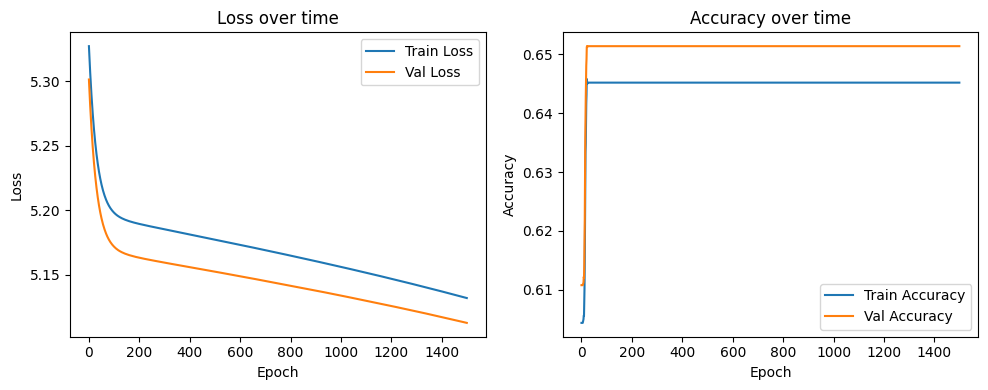

Epoch 0:
Train Loss 5.535242468059036
Train Acc 0.5472916666666667
Val Loss 5.532498473888518
Val Acc 0.54765625

Epoch 50:
Train Loss 5.194209499186766
Train Acc 0.6452083333333334
Val Loss 5.166947433303797
Val Acc 0.65140625

Epoch 100:
Train Loss 5.1891973605198425
Train Acc 0.6452083333333334
Val Loss 5.162764273911741
Val Acc 0.65140625

Epoch 150:
Train Loss 5.181665217148042
Train Acc 0.6452083333333334
Val Loss 5.156047517928252
Val Acc 0.65140625

Epoch 200:
Train Loss 5.169012522992457
Train Acc 0.6452083333333334
Val Loss 5.144574194342565
Val Acc 0.65140625

Epoch 250:
Train Loss 5.145332107869188
Train Acc 0.6452083333333334
Val Loss 5.123423328709729
Val Acc 0.65140625

Epoch 300:
Train Loss 5.097381795523339
Train Acc 0.6452083333333334
Val Loss 5.080420406564082
Val Acc 0.65140625

Epoch 350:
Train Loss 5.003737615172524
Train Acc 0.650625
Val Loss 4.997938676323855
Val Acc 0.6565624999999999

Epoch 400:
Train Loss 4.86629651332878
Train Acc 0.6775
Val Loss 4.877247130

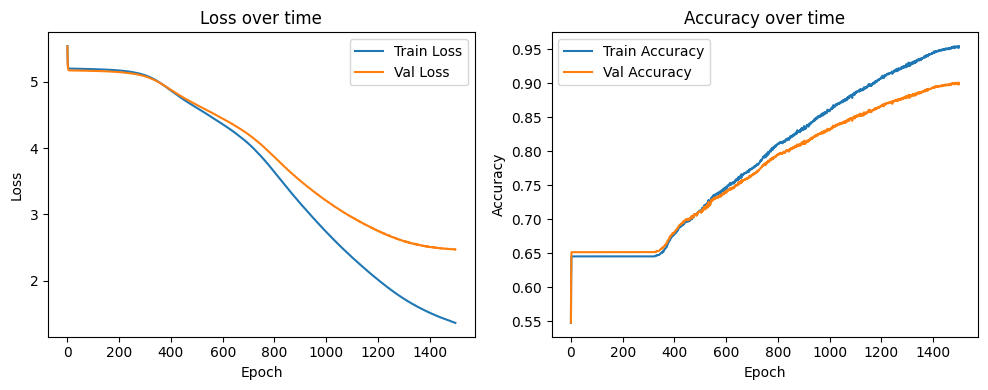

Epoch 0:
Train Loss 5.990749495032159
Train Acc 0.464375
Val Loss 6.009961768771835
Val Acc 0.4625

Epoch 50:
Train Loss 5.918183091434589
Train Acc 0.46354166666666663
Val Loss 5.935229138131993
Val Acc 0.45984375

Epoch 100:
Train Loss 5.8524611834700995
Train Acc 0.49583333333333335
Val Loss 5.867446735130105
Val Acc 0.4934375

Epoch 150:
Train Loss 5.792921155749535
Train Acc 0.49645833333333333
Val Loss 5.805946367624489
Val Acc 0.49390625

Epoch 200:
Train Loss 5.7389652865465255
Train Acc 0.49645833333333333
Val Loss 5.750125064211868
Val Acc 0.49390625

Epoch 250:
Train Loss 5.690054556668656
Train Acc 0.49645833333333333
Val Loss 5.699438861437718
Val Acc 0.49390625

Epoch 300:
Train Loss 5.645702981186737
Train Acc 0.49645833333333333
Val Loss 5.653397115528443
Val Acc 0.49390625

Epoch 350:
Train Loss 5.605472437215322
Train Acc 0.49645833333333333
Val Loss 5.61155731167423
Val Acc 0.49390625

Epoch 400:
Train Loss 5.568967958158255
Train Acc 0.5225
Val Loss 5.57352034113477

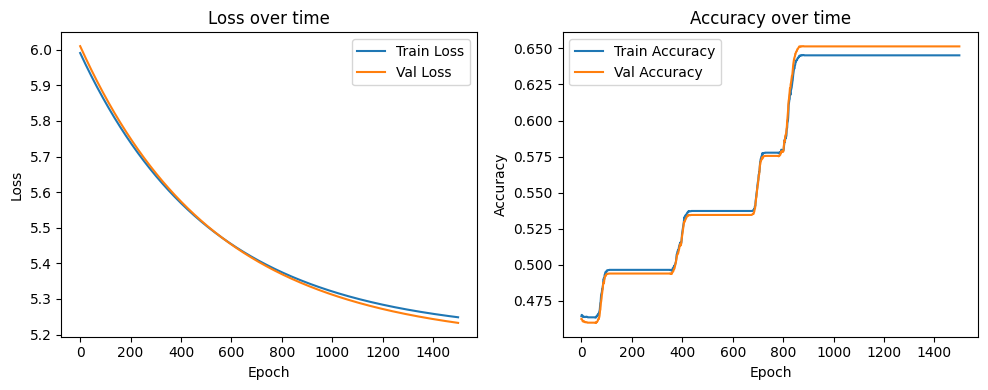

Epoch 0:
Train Loss 5.975730697435749
Train Acc 0.5014583333333333
Val Loss 5.989807679790049
Val Acc 0.49953125

Epoch 50:
Train Loss 5.324285659335487
Train Acc 0.6379166666666667
Val Loss 5.314190481069345
Val Acc 0.6428125

Epoch 100:
Train Loss 5.220065836060161
Train Acc 0.6452083333333334
Val Loss 5.200138788616637
Val Acc 0.65140625

Epoch 150:
Train Loss 5.202241418686533
Train Acc 0.6452083333333334
Val Loss 5.178235881568826
Val Acc 0.65140625

Epoch 200:
Train Loss 5.199042999547723
Train Acc 0.6452083333333334
Val Loss 5.173331007956176
Val Acc 0.65140625

Epoch 250:
Train Loss 5.198365745510404
Train Acc 0.6452083333333334
Val Loss 5.171948659375446
Val Acc 0.65140625

Epoch 300:
Train Loss 5.198134980643924
Train Acc 0.6452083333333334
Val Loss 5.17142307532952
Val Acc 0.65140625

Epoch 350:
Train Loss 5.1979866629302975
Train Acc 0.6452083333333334
Val Loss 5.1711386985536105
Val Acc 0.65140625

Epoch 400:
Train Loss 5.197856455502894
Train Acc 0.6452083333333334
Val Lo

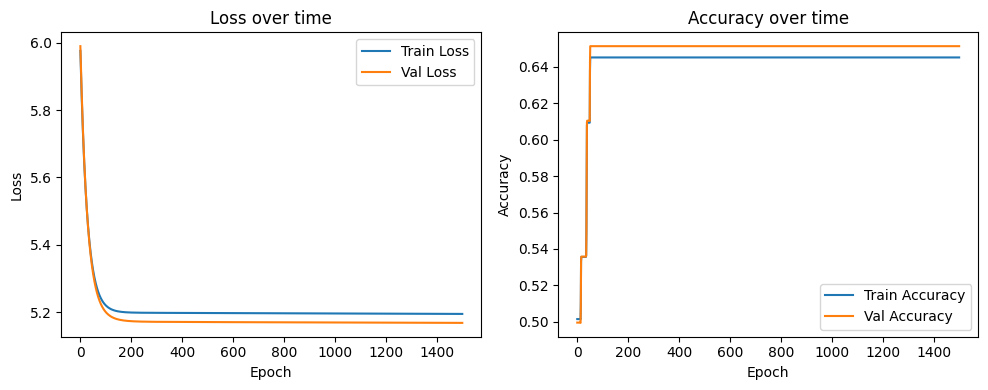

Epoch 0:
Train Loss 5.364111386736012
Train Acc 0.639375
Val Loss 5.359552423784546
Val Acc 0.64328125

Epoch 50:
Train Loss 4.494395550535803
Train Acc 0.7383333333333333
Val Loss 4.54964200469577
Val Acc 0.7365625

Epoch 100:
Train Loss 3.978466807991872
Train Acc 0.7737499999999999
Val Loss 4.115448915883507
Val Acc 0.7665625

Epoch 150:
Train Loss 3.5301066498382685
Train Acc 0.8033333333333333
Val Loss 3.770678041664386
Val Acc 0.78703125

Epoch 200:
Train Loss 3.0251236212309944
Train Acc 0.8558333333333333
Val Loss 3.3936692119429104
Val Acc 0.82921875

Epoch 250:
Train Loss 2.5360832960877002
Train Acc 0.8929166666666667
Val Loss 3.0396979537858364
Val Acc 0.85625

Epoch 300:
Train Loss 2.151470268789674
Train Acc 0.915625
Val Loss 2.7762861114338633
Val Acc 0.875

Epoch 350:
Train Loss 1.8820213674632797
Train Acc 0.9310416666666667
Val Loss 2.6199539111024306
Val Acc 0.884375

Epoch 400:
Train Loss 1.6827739223208944
Train Acc 0.9422916666666666
Val Loss 2.515352091907648
Val

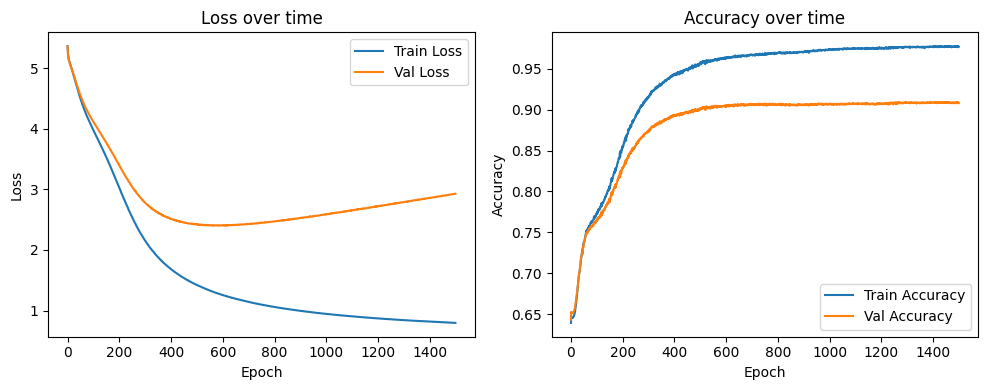

Epoch 0:
Train Loss 5.56019537234194
Train Acc 0.48687499999999995
Val Loss 5.557610268312487
Val Acc 0.489375

Epoch 50:
Train Loss 5.534403159853308
Train Acc 0.5252083333333333
Val Loss 5.531458682603138
Val Acc 0.53078125

Epoch 100:
Train Loss 5.511202743141761
Train Acc 0.5579166666666666
Val Loss 5.507901652025282
Val Acc 0.5615625

Epoch 150:
Train Loss 5.4902129398994655
Train Acc 0.5710416666666667
Val Loss 5.486557381107365
Val Acc 0.57640625

Epoch 200:
Train Loss 5.47111683644681
Train Acc 0.5860416666666667
Val Loss 5.467108692856084
Val Acc 0.59125

Epoch 250:
Train Loss 5.453651741292664
Train Acc 0.5972916666666667
Val Loss 5.449292866709616
Val Acc 0.60390625

Epoch 300:
Train Loss 5.4376000284787525
Train Acc 0.6018749999999999
Val Loss 5.432892399853599
Val Acc 0.60890625

Epoch 350:
Train Loss 5.422781145829672
Train Acc 0.6097916666666667
Val Loss 5.417726958168341
Val Acc 0.61609375

Epoch 400:
Train Loss 5.409044844409762
Train Acc 0.6141666666666667
Val Loss 5.

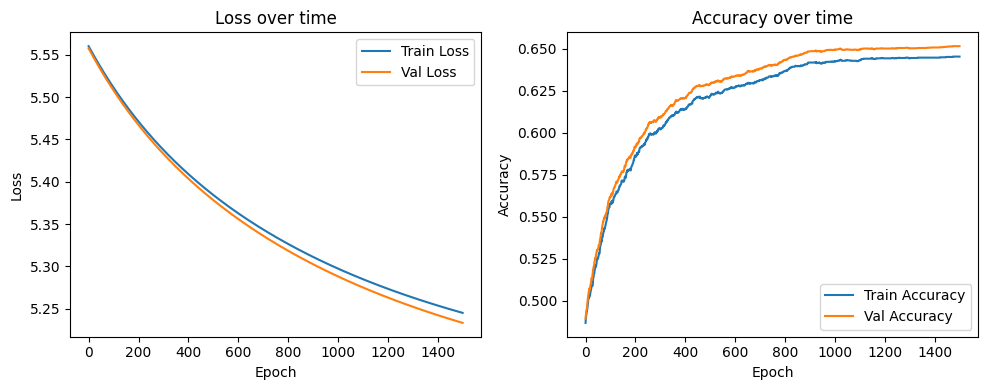

Epoch 0:
Train Loss 5.5661208967288625
Train Acc 0.49624999999999997
Val Loss 5.567766811595237
Val Acc 0.4928125

Epoch 50:
Train Loss 5.354866870260287
Train Acc 0.6425000000000001
Val Loss 5.348463773790372
Val Acc 0.64796875

Epoch 100:
Train Loss 5.245976929582113
Train Acc 0.6452083333333334
Val Loss 5.235193864533914
Val Acc 0.65140625

Epoch 150:
Train Loss 5.179397451692674
Train Acc 0.6452083333333334
Val Loss 5.166645988600035
Val Acc 0.65140625

Epoch 200:
Train Loss 5.135818783358882
Train Acc 0.6452083333333334
Val Loss 5.122908409001544
Val Acc 0.65140625

Epoch 250:
Train Loss 5.104116392130981
Train Acc 0.6452083333333334
Val Loss 5.092202375107252
Val Acc 0.65140625

Epoch 300:
Train Loss 5.078018327447929
Train Acc 0.645625
Val Loss 5.067830920577812
Val Acc 0.65171875

Epoch 350:
Train Loss 5.054496168143629
Train Acc 0.64625
Val Loss 5.0464315592773366
Val Acc 0.65234375

Epoch 400:
Train Loss 5.032046264112882
Train Acc 0.6477083333333333
Val Loss 5.02632389122576

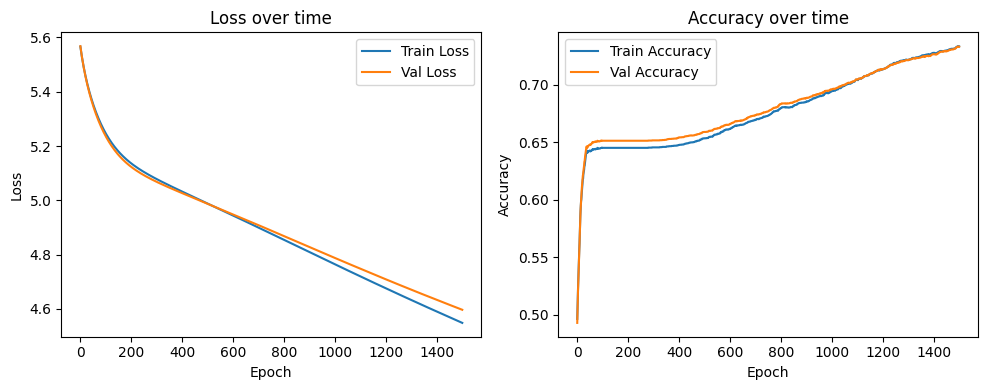

Epoch 0:
Train Loss 5.3615501505920955
Train Acc 0.6314583333333333
Val Loss 5.3551634813373274
Val Acc 0.63328125

Epoch 50:
Train Loss 4.367141856254255
Train Acc 0.7429166666666667
Val Loss 4.43443659520029
Val Acc 0.7428125

Epoch 100:
Train Loss 3.6104781392835608
Train Acc 0.79625
Val Loss 3.7944010340561487
Val Acc 0.7884375

Epoch 150:
Train Loss 2.8903575833566415
Train Acc 0.843125
Val Loss 3.2329094021628735
Val Acc 0.82359375

Epoch 200:
Train Loss 2.1255462672375773
Train Acc 0.923125
Val Loss 2.6657152174133905
Val Acc 0.88375

Epoch 250:
Train Loss 1.4327937218622981
Train Acc 0.985
Val Loss 2.1638902175241856
Val Acc 0.93078125

Epoch 300:
Train Loss 0.942223610620855
Train Acc 0.9977083333333333
Val Loss 1.8353487758041787
Val Acc 0.94078125

Epoch 350:
Train Loss 0.6423583949375723
Train Acc 0.9997916666666666
Val Loss 1.65271072905677
Val Acc 0.94109375

Epoch 400:
Train Loss 0.46323966393867494
Train Acc 1.0
Val Loss 1.566435643252084
Val Acc 0.9409375

Epoch 450:
T

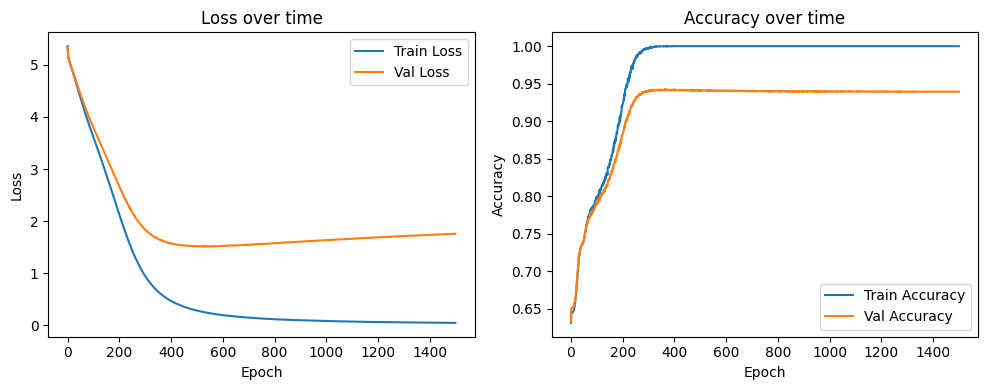

Epoch 0:
Train Loss 5.566015283712236
Train Acc 0.494375
Val Loss 5.565523366423762
Val Acc 0.49468749999999995

Epoch 50:
Train Loss 5.5485807136351895
Train Acc 0.5077083333333333
Val Loss 5.547283012402263
Val Acc 0.50921875

Epoch 100:
Train Loss 5.532419914309659
Train Acc 0.5231250000000001
Val Loss 5.530391314378988
Val Acc 0.5240625

Epoch 150:
Train Loss 5.517348464982288
Train Acc 0.5322916666666666
Val Loss 5.514656254014881
Val Acc 0.534375

Epoch 200:
Train Loss 5.503212834992909
Train Acc 0.54375
Val Loss 5.499917347816271
Val Acc 0.5453125

Epoch 250:
Train Loss 5.48988540791339
Train Acc 0.5525
Val Loss 5.486040664876854
Val Acc 0.55234375

Epoch 300:
Train Loss 5.477260165102318
Train Acc 0.5633333333333334
Val Loss 5.472914486364714
Val Acc 0.5643750000000001

Epoch 350:
Train Loss 5.46524900155305
Train Acc 0.5710416666666667
Val Loss 5.460445586014841
Val Acc 0.57296875

Epoch 400:
Train Loss 5.453778619839753
Train Acc 0.5802083333333333
Val Loss 5.448556082334456


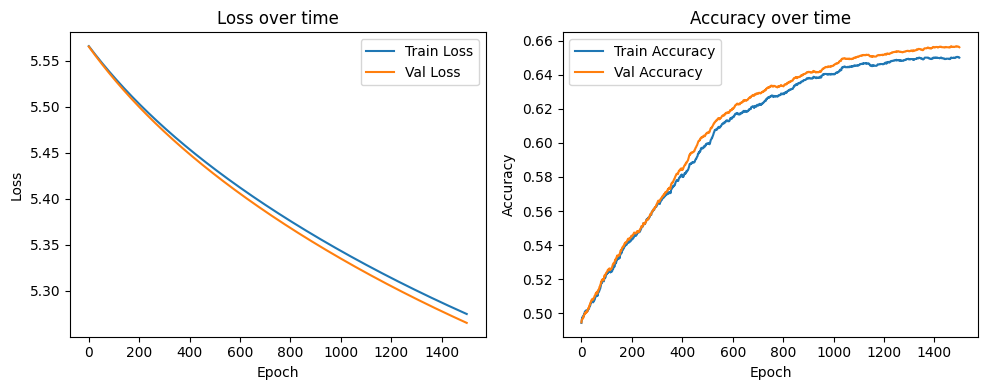

Epoch 0:
Train Loss 5.513178708191736
Train Acc 0.5289583333333333
Val Loss 5.5140554008037705
Val Acc 0.5265625

Epoch 50:
Train Loss 5.206877639662924
Train Acc 0.6454166666666667
Val Loss 5.191758281969786
Val Acc 0.6515625

Epoch 100:
Train Loss 5.146777123812002
Train Acc 0.6452083333333334
Val Loss 5.129730951254182
Val Acc 0.65140625

Epoch 150:
Train Loss 5.111093566401412
Train Acc 0.6452083333333334
Val Loss 5.095776820617215
Val Acc 0.65140625

Epoch 200:
Train Loss 5.080268651785009
Train Acc 0.6454166666666667
Val Loss 5.067738049439749
Val Acc 0.6515625

Epoch 250:
Train Loss 5.050954319636603
Train Acc 0.645625
Val Loss 5.041594538468349
Val Acc 0.65171875

Epoch 300:
Train Loss 5.022139694179482
Train Acc 0.64625
Val Loss 5.015966317195133
Val Acc 0.6521874999999999

Epoch 350:
Train Loss 4.993394973181355
Train Acc 0.6472916666666666
Val Loss 4.99048472669207
Val Acc 0.6528125

Epoch 400:
Train Loss 4.964562353237312
Train Acc 0.649375
Val Loss 4.964860121246919
Val Ac

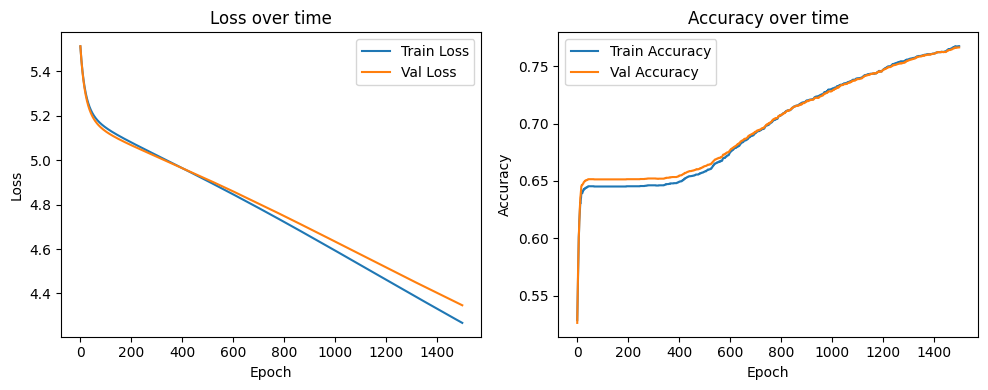

Epoch 0:
Train Loss 5.271598647014176
Train Acc 0.6439583333333334
Val Loss 5.260020303522101
Val Acc 0.6487499999999999

Epoch 50:
Train Loss 4.144791332236703
Train Acc 0.7722916666666666
Val Loss 4.252710960177151
Val Acc 0.76828125

Epoch 100:
Train Loss 2.480965268421822
Train Acc 0.8975
Val Loss 2.9780418764132675
Val Acc 0.8603125

Epoch 150:
Train Loss 0.9534895578882153
Train Acc 0.9904166666666667
Val Loss 1.9334356320197634
Val Acc 0.9321875

Epoch 200:
Train Loss 0.4359857657237229
Train Acc 0.9997916666666666
Val Loss 1.7667616442678367
Val Acc 0.93640625

Epoch 250:
Train Loss 0.2504845787847026
Train Acc 1.0
Val Loss 1.8313775366619813
Val Acc 0.93609375

Epoch 300:
Train Loss 0.1707703856065662
Train Acc 1.0
Val Loss 1.95235067164511
Val Acc 0.9339062499999999

Epoch 350:
Train Loss 0.12920796407934726
Train Acc 1.0
Val Loss 2.0706922961771053
Val Acc 0.93296875

Epoch 400:
Train Loss 0.10330863344185251
Train Acc 1.0
Val Loss 2.1839336409365857
Val Acc 0.93125

Epoch 4

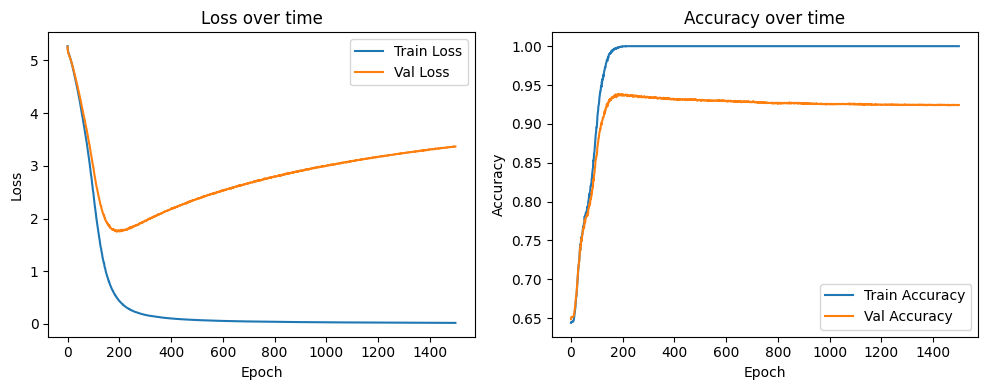

Epoch 0:
Train Loss 5.589360744390958
Train Acc 0.4664583333333333
Val Loss 5.584948918111608
Val Acc 0.47281249999999997

Epoch 50:
Train Loss 5.527511598975941
Train Acc 0.521875
Val Loss 5.520935366472267
Val Acc 0.52640625

Epoch 100:
Train Loss 5.477794932179211
Train Acc 0.5589583333333333
Val Loss 5.469348400986674
Val Acc 0.56578125

Epoch 150:
Train Loss 5.437404006781518
Train Acc 0.5910416666666667
Val Loss 5.427344495572697
Val Acc 0.59671875

Epoch 200:
Train Loss 5.404207261177824
Train Acc 0.6104166666666666
Val Loss 5.392756332341874
Val Acc 0.6134375000000001

Epoch 250:
Train Loss 5.376603243299739
Train Acc 0.6252083333333334
Val Loss 5.363950077019463
Val Acc 0.63109375

Epoch 300:
Train Loss 5.353390011984132
Train Acc 0.6364583333333333
Val Loss 5.339695665955917
Val Acc 0.64125

Epoch 350:
Train Loss 5.33366131595661
Train Acc 0.6397916666666666
Val Loss 5.319063005425421
Val Acc 0.64578125

Epoch 400:
Train Loss 5.316728537558549
Train Acc 0.6427083333333333
Val

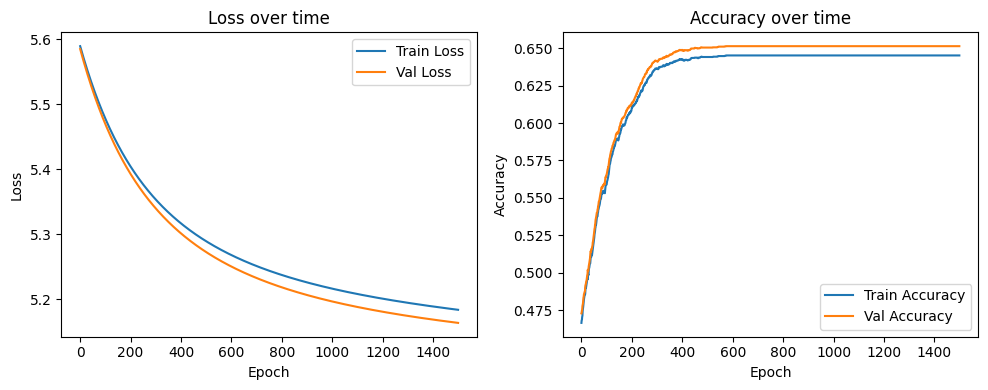

Epoch 0:
Train Loss 5.514781807028292
Train Acc 0.531875
Val Loss 5.5144569062773074
Val Acc 0.53078125

Epoch 50:
Train Loss 5.228511888980352
Train Acc 0.6454166666666667
Val Loss 5.2122939633550205
Val Acc 0.6515625

Epoch 100:
Train Loss 5.1752658125636595
Train Acc 0.6452083333333334
Val Loss 5.156674362874746
Val Acc 0.65140625

Epoch 150:
Train Loss 5.146552682026706
Train Acc 0.6452083333333334
Val Loss 5.129315861503979
Val Acc 0.65140625

Epoch 200:
Train Loss 5.122058151842097
Train Acc 0.6452083333333334
Val Loss 5.1074300901004595
Val Acc 0.65140625

Epoch 250:
Train Loss 5.0975050956247845
Train Acc 0.6452083333333334
Val Loss 5.086032363812967
Val Acc 0.65140625

Epoch 300:
Train Loss 5.071378071785439
Train Acc 0.6452083333333334
Val Loss 5.063368328579564
Val Acc 0.65140625

Epoch 350:
Train Loss 5.042919283428394
Train Acc 0.6454166666666667
Val Loss 5.038702419904263
Val Acc 0.6515625

Epoch 400:
Train Loss 5.011799484876441
Train Acc 0.6479166666666667
Val Loss 5.01

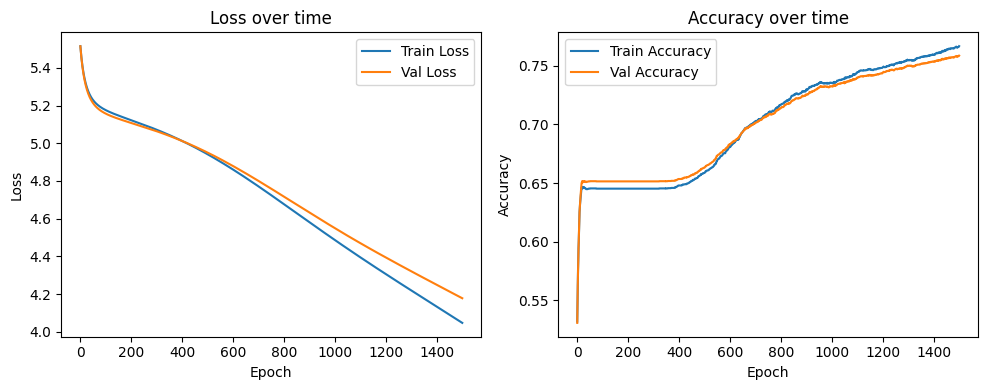

Epoch 0:
Train Loss 5.440218765008769
Train Acc 0.63125
Val Loss 5.437740696433067
Val Acc 0.6365624999999999

Epoch 50:
Train Loss 4.634885063285255
Train Acc 0.73125
Val Loss 4.663758330380643
Val Acc 0.7303124999999999

Epoch 100:
Train Loss 4.081278443367526
Train Acc 0.77875
Val Loss 4.189086044303756
Val Acc 0.7728125

Epoch 150:
Train Loss 3.584145814740422
Train Acc 0.8085416666666667
Val Loss 3.8188993523599994
Val Acc 0.7903125

Epoch 200:
Train Loss 3.0756986131575426
Train Acc 0.836875
Val Loss 3.4447904453398333
Val Acc 0.8128124999999999

Epoch 250:
Train Loss 2.6139932845311193
Train Acc 0.8814583333333333
Val Loss 3.1163415119019735
Val Acc 0.8446875

Epoch 300:
Train Loss 2.2481091032822236
Train Acc 0.9004166666666666
Val Loss 2.8709996311764074
Val Acc 0.8596874999999999

Epoch 350:
Train Loss 1.9866029954407827
Train Acc 0.9143749999999999
Val Loss 2.715115131989026
Val Acc 0.8709375

Epoch 400:
Train Loss 1.7915488137618552
Train Acc 0.9229166666666666
Val Loss 2.6

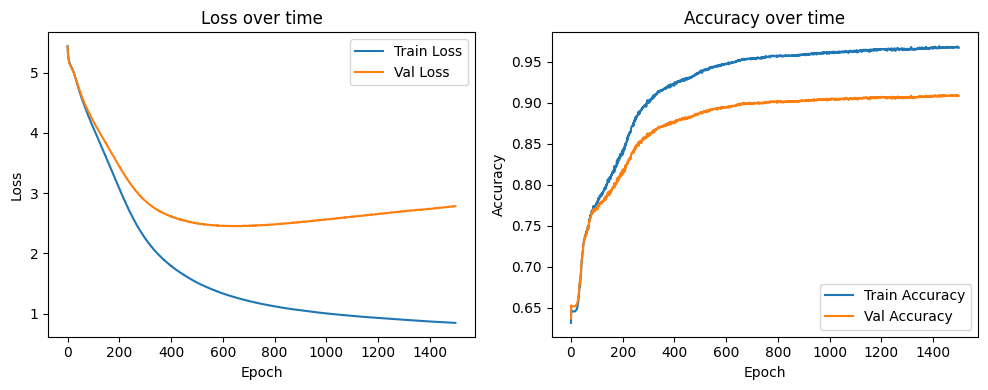

Epoch 0:
Train Loss 5.533977065223034
Train Acc 0.54125
Val Loss 5.534963349913348
Val Acc 0.54140625

Epoch 50:
Train Loss 5.522614833657316
Train Acc 0.576875
Val Loss 5.523015889639006
Val Acc 0.57765625

Epoch 100:
Train Loss 5.511537188444676
Train Acc 0.5908333333333333
Val Loss 5.511291258498548
Val Acc 0.5928125

Epoch 150:
Train Loss 5.500361881268671
Train Acc 0.6002083333333333
Val Loss 5.499458898908269
Val Acc 0.60390625

Epoch 200:
Train Loss 5.489247482899888
Train Acc 0.6056250000000001
Val Loss 5.487651761273768
Val Acc 0.610625

Epoch 250:
Train Loss 5.478016735176719
Train Acc 0.6108333333333333
Val Loss 5.47572696431694
Val Acc 0.615

Epoch 300:
Train Loss 5.466224202145357
Train Acc 0.6168750000000001
Val Loss 5.463241800340938
Val Acc 0.6203125

Epoch 350:
Train Loss 5.4539197774866235
Train Acc 0.6189583333333333
Val Loss 5.45025828947321
Val Acc 0.6229687500000001

Epoch 400:
Train Loss 5.441267592835569
Train Acc 0.6225
Val Loss 5.436988104568159
Val Acc 0.6259

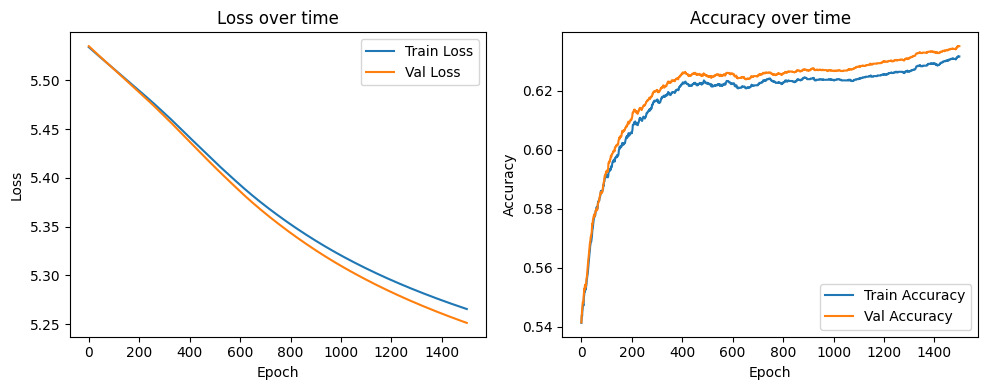

Epoch 0:
Train Loss 5.509335932505186
Train Acc 0.5516666666666667
Val Loss 5.50864300756664
Val Acc 0.55203125

Epoch 50:
Train Loss 5.316233204616009
Train Acc 0.64125
Val Loss 5.305942402238605
Val Acc 0.645625

Epoch 100:
Train Loss 5.222560557927799
Train Acc 0.645625
Val Loss 5.20848736455117
Val Acc 0.651875

Epoch 150:
Train Loss 5.1676412565753145
Train Acc 0.6458333333333333
Val Loss 5.153721936558338
Val Acc 0.651875

Epoch 200:
Train Loss 5.131216476343855
Train Acc 0.645625
Val Loss 5.1188515218800426
Val Acc 0.65171875

Epoch 250:
Train Loss 5.103388601404837
Train Acc 0.645625
Val Loss 5.093045343996562
Val Acc 0.65171875

Epoch 300:
Train Loss 5.079303035667626
Train Acc 0.645625
Val Loss 5.071487493652361
Val Acc 0.65171875

Epoch 350:
Train Loss 5.057300999358004
Train Acc 0.6460416666666666
Val Loss 5.0518821294846
Val Acc 0.6520312500000001

Epoch 400:
Train Loss 5.036242640335943
Train Acc 0.646875
Val Loss 5.033114453995974
Val Acc 0.65296875

Epoch 450:
Train Los

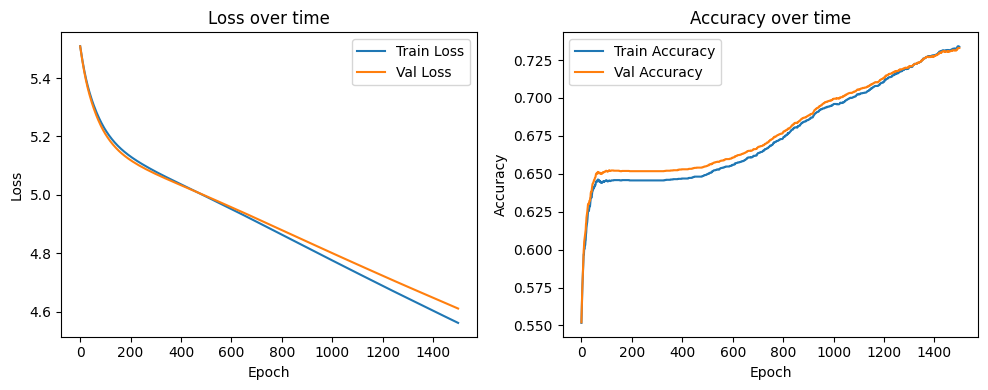

Epoch 0:
Train Loss 5.336058754691359
Train Acc 0.6425000000000001
Val Loss 5.327360964634497
Val Acc 0.6478125

Epoch 50:
Train Loss 4.357774418418697
Train Acc 0.7508333333333334
Val Loss 4.440266497091335
Val Acc 0.74828125

Epoch 100:
Train Loss 3.4972069561617114
Train Acc 0.8054166666666667
Val Loss 3.719130793324071
Val Acc 0.79453125

Epoch 150:
Train Loss 2.7028251781498907
Train Acc 0.8604166666666666
Val Loss 3.110979093178732
Val Acc 0.83546875

Epoch 200:
Train Loss 1.9347391973687869
Train Acc 0.9385416666666667
Val Loss 2.5574154591468243
Val Acc 0.89296875

Epoch 250:
Train Loss 1.2756313345145185
Train Acc 0.98125
Val Loss 2.0932290422508886
Val Acc 0.92765625

Epoch 300:
Train Loss 0.8380511095754858
Train Acc 0.995625
Val Loss 1.817193646204512
Val Acc 0.938125

Epoch 350:
Train Loss 0.5705868183417909
Train Acc 0.99875
Val Loss 1.6755353991137516
Val Acc 0.93984375

Epoch 400:
Train Loss 0.4082972749123333
Train Acc 0.9995833333333334
Val Loss 1.6121146079185769
Val

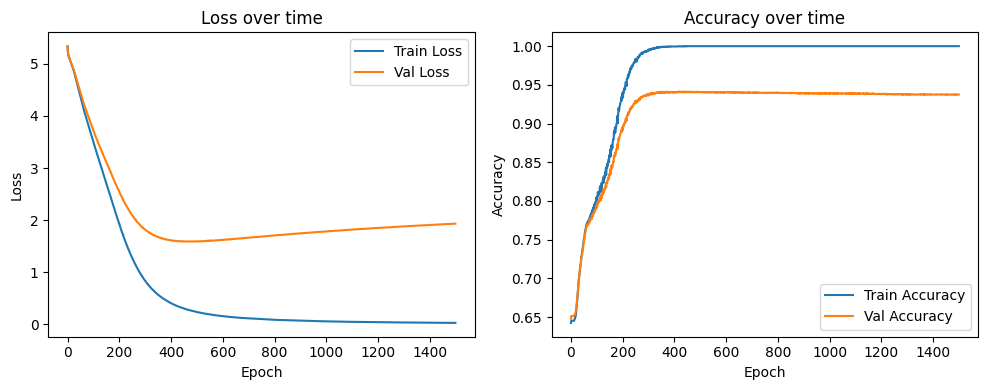

Epoch 0:
Train Loss 5.55487071230505
Train Acc 0.49145833333333333
Val Loss 5.553718863538316
Val Acc 0.49687499999999996

Epoch 50:
Train Loss 5.538758447237962
Train Acc 0.525625
Val Loss 5.537205423425113
Val Acc 0.53296875

Epoch 100:
Train Loss 5.524424020332168
Train Acc 0.5591666666666666
Val Loss 5.522543620217424
Val Acc 0.565

Epoch 150:
Train Loss 5.511724120730798
Train Acc 0.5760416666666667
Val Loss 5.509477150282598
Val Acc 0.58375

Epoch 200:
Train Loss 5.500099198485173
Train Acc 0.593125
Val Loss 5.497522716086009
Val Acc 0.59828125

Epoch 250:
Train Loss 5.489197122373641
Train Acc 0.6064583333333333
Val Loss 5.486329635250272
Val Acc 0.6114062499999999

Epoch 300:
Train Loss 5.478858039237503
Train Acc 0.6133333333333333
Val Loss 5.475662645371483
Val Acc 0.6184375

Epoch 350:
Train Loss 5.468925881444058
Train Acc 0.6204166666666666
Val Loss 5.465396602584957
Val Acc 0.62578125

Epoch 400:
Train Loss 5.459328566738683
Train Acc 0.6268750000000001
Val Loss 5.4554860

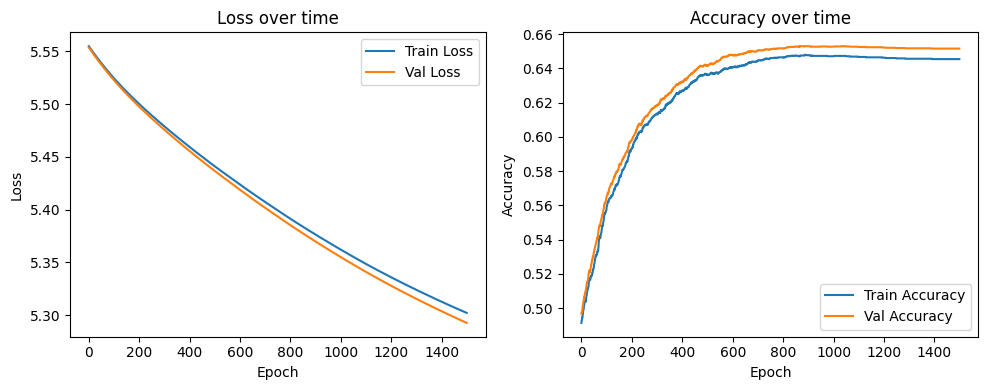

Epoch 0:
Train Loss 5.611260373744258
Train Acc 0.431875
Val Loss 5.615315449684649
Val Acc 0.42718750000000005

Epoch 50:
Train Loss 5.414854325727181
Train Acc 0.6433333333333333
Val Loss 5.410194846214592
Val Acc 0.6482812499999999

Epoch 100:
Train Loss 5.327839868852666
Train Acc 0.6452083333333334
Val Loss 5.3188681643637254
Val Acc 0.65140625

Epoch 150:
Train Loss 5.273248268109733
Train Acc 0.6452083333333334
Val Loss 5.261205240150159
Val Acc 0.65140625

Epoch 200:
Train Loss 5.2367426515426985
Train Acc 0.6452083333333334
Val Loss 5.222553923722449
Val Acc 0.65140625

Epoch 250:
Train Loss 5.210961689259232
Train Acc 0.6452083333333334
Val Loss 5.195339515885082
Val Acc 0.65140625

Epoch 300:
Train Loss 5.1908152345582605
Train Acc 0.6452083333333334
Val Loss 5.174789731979602
Val Acc 0.65140625

Epoch 350:
Train Loss 5.1741251087779725
Train Acc 0.6452083333333334
Val Loss 5.157920745295237
Val Acc 0.65140625

Epoch 400:
Train Loss 5.159017097954848
Train Acc 0.645208333333

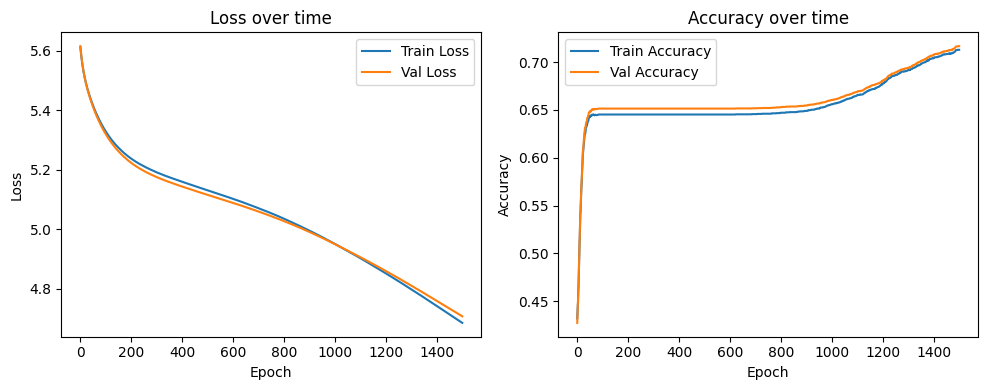

Epoch 0:
Train Loss 5.406313953668003
Train Acc 0.6375
Val Loss 5.40087986737981
Val Acc 0.6425000000000001

Epoch 50:
Train Loss 4.55403761059028
Train Acc 0.7270833333333333
Val Loss 4.599458989579031
Val Acc 0.7265625

Epoch 100:
Train Loss 3.5513021490753385
Train Acc 0.8135416666666666
Val Loss 3.8086927010603273
Val Acc 0.79984375



KeyboardInterrupt: 

In [37]:
for lr in learning_rates_multi:
    for epochs in num_epochs_multi:
        for activation in activations_multi:
            for layers in hidden_layers_multi:
                for optimizer_name, optimizer_function in optimizers_multi.items():
                    wandb.init(project="MLP with Multiple Classes")

                    model = MLPMultiLabel(X_train_normalized.shape[1], layers, y_train.shape[1], learning_rate=lr, activation=activation, log_flag=1)
                    optimizer_function(model, X_train_normalized, y_train, X_val_normalized, y_val, epochs=epochs)

                    y_pred = model.predict(X_val_normalized)
                    y_labels_pred = np.argmax(y_pred, axis=1)
                    y_val_labels = np.argmax(y_val, axis=1)
                    accuracy = accuracy_score(y_val_labels, y_labels_pred)
                    wandb.log({"validation_accuracy": accuracy})

                    if accuracy > best_accuracy_multi:
                        best_accuracy_mutli = accuracy
                        best_model_mutli = model
                        best_hyperparameters_multi = {
                            "learning_rate": lr,
                            "num_epochs": epochs,
                            "activation": activation,
                            "hidden_layers": layers,
                            "optimizer": optimizer_name
                        }

                    # Finish the run
                    wandb.finish()